In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device(0)

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA TITAN RTX'

In [7]:
#Building a Recurrent Neural Neural Network to classify stock price predictions based on volume of percentage changes between open and close with respect to the volume as well
# What components do we need then to determine when to buy, sell, hold, or short
# the data: we got the prices between open and close
#The NN will have 4 actions of categories in order to hav ethe goal of making a profit of 16.59% on the daily, with a specific series of prices overtime by minute, we stop the profit at 16.59% and stop further action
#To categorize the four actions we need to know when there is a signifigant change of percentage that can get us to 16.59% profit weather from buying, holding, selling, or shorting our given GBP/USD security and trading on the
# pips

In [8]:
#Install any necessary libraries
!pip install scikit-learn

In [9]:
!pip install pandas

In [10]:
!pip install tqdm

In [11]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Set the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load data for each time frame from CSV files
data_m1 = pd.read_csv('C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute1_trained.csv', parse_dates=['DateTime'], index_col='DateTime')
data_m5 = pd.read_csv('C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute5_trained.csv', parse_dates=['DateTime'], index_col='DateTime')
data_m15 = pd.read_csv('C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute15_trained.csv', parse_dates=['DateTime'], index_col='DateTime')
data_m30 = pd.read_csv('C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/minute30_trained.csv', parse_dates=['DateTime'], index_col='DateTime')


#hmmm would it also help if keeping the calculation the same I can diverse the portfolio for the model instead of just percentages from bitcoin prices
#going to the need the same for forex or stock prices
#do them based on minutes too 
#Forex


#Specific Stock



#Domain Stocks 


# Clean data by forward filling missing values
data_frames = [data_m1, data_m5, data_m15, data_m30]
for df in data_frames:
    df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing data

# Initialize tracking variables
trades_completed = 0
daily_profit = 0.0
current_position = None  # Tracks the current position: 'long', 'short', or None


#okay so our calculate action needs to be changed to consider for margin trading and we are definetly going to make sure our mdoel is going to have a 99% accuracy prior to implementing on metatrader5

#When doing so we are going to be focusing on the following

"""

Ideas:
1. We will be doing a 1:100 leverage because the percentages are too low to accumulate for a key percentage

Really the percentage we are getting is as a result from the 1:100 leverage of tacking $1000 and turn it to 100,000

That means we will have a recurrent neural network that for the profit of 1


2.

So we can actually first start with a different series of training
We can first start with binary classification
Maybe do a different neural network architecture to start
And what we need to do is based on the change of the open_close we will then determine 
if the next change for the open-close position is going to go down 

However, we do not know if the market is going up or down because its moving consistently 
We need to trade on margin for us to grow 


3.

How do we calculate the probabilities  of prices going up or prices going down?

So actually we arent just looking at the different time series of just 1 wave for 30 minutes
We are also looking at the different time series for each of the data points. So for instnace if we see per minute that the data is going down 


"""

# Define the action calculation function
def calculate_action(current_date, last_trade_date, trades_completed, daily_profit, current_position, multi_time_frame_data, target_daily_profit=0.165, max_trades=100):
    # Reset daily counters if it's a new trading day
    if last_trade_date is None or current_date.date() != last_trade_date.date():
        trades_completed = 0
        daily_profit = 0.0
        last_trade_date = current_date

    # Check if the daily profit target or max trades have been reached
    if daily_profit >= target_daily_profit or trades_completed >= max_trades:
        return 'Hold', current_position, trades_completed, daily_profit, last_trade_date

    # Define buy and sell thresholds for different time frames
    buy_thresholds = {'1min': -0.01, '5min': -0.03, '15min': -0.1, '30min': -0.2}
    sell_thresholds = {'1min': 0.01, '5min': 0.03, '15min': 0.1, '30min': 0.2}

    action = 'Hold'

    # Process each timeframe's percentage change and determine actions
    for time_frame, pct_change in multi_time_frame_data.items():
        if current_position == 'long':
            if pct_change >= sell_thresholds[time_frame]:
                action = 'Sell'
                current_position = None
                daily_profit += pct_change  # Update profit when selling
                break
        elif current_position == 'short':
            if pct_change <= buy_thresholds[time_frame]:
                action = 'Close Short'
                current_position = None
                daily_profit += -pct_change  # Assuming short profits are inverse
                break
        else:
            if pct_change <= buy_thresholds[time_frame]:
                action = 'Buy'
                current_position = 'long'
            elif pct_change >= sell_thresholds[time_frame]:
                action = 'Short'
                current_position = 'short'

        # Only increment trades_completed if an action changes the position
        if action != 'Hold':
            trades_completed += 1

    return action, current_position, trades_completed, daily_profit, last_trade_date


Using device: cuda


In [21]:
import pandas as pd

# Paths to the CSV files for each time frame
path_1min = r"C:\Users\gunne\OneDrive\Desktop\bitcoin\trained\1walk_cleaned.csv"
path_5min = r"C:\Users\gunne\OneDrive\Desktop\bitcoin\trained\5walk_cleaned.csv"
path_15min = r"C:\Users\gunne\OneDrive\Desktop\bitcoin\trained\15walk_cleaned.csv"
path_30min = r"C:\Users\gunne\OneDrive\Desktop\bitcoin\trained\30walk_cleaned.csv"

# Load data from CSV files
data_1min = pd.read_csv(path_1min)
data_5min = pd.read_csv(path_5min)
data_15min = pd.read_csv(path_15min)
data_30min = pd.read_csv(path_30min)

# Assuming each CSV file contains a column 'Change_Open_Close' with the percentage changes
df = pd.DataFrame({
    '1min': data_1min['Change_Open_Close'],
    '5min': data_5min['Change_Open_Close'],
    '15min': data_15min['Change_Open_Close'],
    '30min': data_30min['Change_Open_Close']
})

current_position = None
daily_profit = 0.0  # This is a percentage of the leveraged amount
trades_completed = 0
current_date = pd.Timestamp('2024-05-10 09:00')
last_trade_date = pd.Timestamp('2024-05-10 08:30')

initial_capital = 1000
leverage = 100
leveraged_amount = initial_capital * leverage

def simulate_trading(df, current_date, last_trade_date, trades_completed, daily_profit, current_position):
    results = []
    for index, row in df.iterrows():
        multi_time_frame_data = row.to_dict()
        action, current_position, trades_completed, daily_profit, last_trade_date = calculate_action(
            current_date, last_trade_date, trades_completed, daily_profit, current_position, multi_time_frame_data
        )
        results.append({
            'Time': current_date.strftime('%Y-%m-%d %H:%M:%S'),
            'Action': action,
            'Position': current_position,
            'Trades Completed': trades_completed,
            'Leveraged Profit ($)': f"${daily_profit * leveraged_amount:.2f}",
            'Daily Profit (%)': f"{daily_profit:.2%}"
        })
        current_date += pd.Timedelta(minutes=30)  # Increment time
    return results

test_results = simulate_trading(df, current_date, last_trade_date, trades_completed, daily_profit, current_position)
results_df = pd.DataFrame(test_results)

# Save the results to a CSV file
results_df.to_csv("trading_simulation_results.csv", index=False)

results_df.to_csv(r"C:\Users\gunne\OneDrive\Desktop\trading_simulation_results.csv", index=False)


print("Results saved to 'trading_simulation_results.csv'.")



Results saved to 'trading_simulation_results.csv'.


In [11]:
# Load and prepare data as previously detailed
#I got the data from MetaTrader5 and used their platform to get the ddata, the data needs to be cleaned and also put in the parameters for the percentages of open-clsoe, high-low
# Part 2: Load and prepare data as previously detailed
# Assume all data frames are already loaded and processed as per Part 1
import numpy as np

actions = []
features = []

trades_completed = 0
daily_profit = 0.0
current_position = None
last_trade_date = None

# If all DataFrame are synchronized and aligned as assumed
# Calculate the minimum length of all dataframes to avoid index errors
min_length = min(len(data_m1), len(data_m5), len(data_m15), len(data_m30))

# Loop through each entry in the dataframes up to the minimum length
for i in range(min_length):
    current_date = data_m1.index[i]  # Assuming the index is the same across all dataframes and is datetime
    multi_time_frame_data = {
        '1min': data_m1.iloc[i]['Change_Open_Close'],
        '5min': data_m5.iloc[i]['Change_Open_Close'],
        '15min': data_m15.iloc[i]['Change_Open_Close'],
        '30min': data_m30.iloc[i]['Change_Open_Close'],
    }
    
    # Extract all required outputs from the calculate_action function
    action, current_position, trades_completed, daily_profit, last_trade_date = calculate_action(
        current_date=current_date, 
        last_trade_date=last_trade_date, 
        trades_completed=trades_completed, 
        daily_profit=daily_profit, 
        current_position=current_position, 
        multi_time_frame_data=multi_time_frame_data,
        target_daily_profit=16.5,  # Your daily profit target
        max_trades=100  # Your maximum trades per day
    )
    
    actions.append(action)
    feature_row = [
        data_m1.iloc[i]['Change_Open_Close'],
        data_m5.iloc[i]['Change_Open_Close'],
        data_m15.iloc[i]['Change_Open_Close'],
        data_m30.iloc[i]['Change_Open_Close'],
    ]
    features.append(feature_row)


# Convert actions to numeric labels and ensure they match the output size of your network
labels = pd.factorize(actions)[0]
# Assuming your network predicts 3 classes, ensure labels are within [0, 1, 2]
labels = np.clip(labels, 0, 2)

# Convert lists of features and labels into tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features_tensor, labels_tensor, test_size=0.2, random_state=42)

# Load tensors to the appropriate device
train_features_tensor = train_features.to(device)
train_labels_tensor = train_labels.to(device)
test_features_tensor = test_features.to(device)
test_labels_tensor = test_labels.to(device)

# Setup DataLoader
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=12288, shuffle=True)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=12288, shuffle=False)

print("DataLoader setup complete. Ready to train the model.")

DataLoader setup complete. Ready to train the model.


In [12]:
# Model definition with device assignment
class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=4, hidden_size=50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, 5)  # 5 actions
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x, _ = self.rnn(x)
        if x.dim() == 3:  # Proper 3D tensor (batch, sequence, features)
            x = x[:, -1, :]
        x = self.leaky_relu(x)
        x = self.fc(x)
        return x

model = StockRNN().to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Epoch 1/3000: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.84it/s, loss=1.47]


Completed Epoch 1, Loss: 1.5008, Duration: 0.88 seconds


Epoch 2/3000: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=1.34]


Completed Epoch 2, Loss: 1.4100, Duration: 0.60 seconds


Epoch 3/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.763]


Completed Epoch 3, Loss: 1.0318, Duration: 0.62 seconds


Epoch 4/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.473]


Completed Epoch 4, Loss: 0.5685, Duration: 0.65 seconds


Epoch 5/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s, loss=0.375]


Completed Epoch 5, Loss: 0.4079, Duration: 0.61 seconds


Epoch 6/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.286]


Completed Epoch 6, Loss: 0.3263, Duration: 0.60 seconds


Epoch 7/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.274]


Completed Epoch 7, Loss: 0.2844, Duration: 0.67 seconds


Epoch 8/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.88it/s, loss=0.266]


Completed Epoch 8, Loss: 0.2574, Duration: 0.55 seconds


Epoch 9/3000: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.26]


Completed Epoch 9, Loss: 0.2390, Duration: 0.62 seconds


Epoch 10/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.219]


Completed Epoch 10, Loss: 0.2203, Duration: 0.64 seconds


Epoch 11/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.226]


Completed Epoch 11, Loss: 0.2119, Duration: 0.65 seconds


Epoch 12/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.197]


Completed Epoch 12, Loss: 0.2004, Duration: 0.64 seconds


Epoch 13/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.206]


Completed Epoch 13, Loss: 0.1961, Duration: 0.64 seconds


Epoch 14/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.186]


Completed Epoch 14, Loss: 0.1885, Duration: 0.62 seconds


Epoch 15/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.163]


Completed Epoch 15, Loss: 0.1814, Duration: 0.64 seconds


Epoch 16/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.186]


Completed Epoch 16, Loss: 0.1816, Duration: 0.66 seconds


Epoch 17/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s, loss=0.172]


Completed Epoch 17, Loss: 0.1769, Duration: 0.68 seconds


Epoch 18/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s, loss=0.173]


Completed Epoch 18, Loss: 0.1748, Duration: 0.61 seconds


Epoch 19/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.152]


Completed Epoch 19, Loss: 0.1698, Duration: 0.63 seconds


Epoch 20/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.189]


Completed Epoch 20, Loss: 0.1737, Duration: 0.63 seconds


Epoch 21/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.16]


Completed Epoch 21, Loss: 0.1678, Duration: 0.60 seconds


Epoch 22/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.159]


Completed Epoch 22, Loss: 0.1663, Duration: 0.62 seconds


Epoch 23/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.185]


Completed Epoch 23, Loss: 0.1690, Duration: 0.61 seconds


Epoch 24/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.147]


Completed Epoch 24, Loss: 0.1624, Duration: 0.66 seconds


Epoch 25/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.54it/s, loss=0.153]


Completed Epoch 25, Loss: 0.1624, Duration: 0.70 seconds


Epoch 26/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.182]


Completed Epoch 26, Loss: 0.1658, Duration: 0.59 seconds


Epoch 27/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.155]


Completed Epoch 27, Loss: 0.1611, Duration: 0.62 seconds


Epoch 28/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.61it/s, loss=0.184]


Completed Epoch 28, Loss: 0.1648, Duration: 0.57 seconds


Epoch 29/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.187]


Completed Epoch 29, Loss: 0.1646, Duration: 0.63 seconds


Epoch 30/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.193]


Completed Epoch 30, Loss: 0.1651, Duration: 0.63 seconds


Epoch 31/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.171]


Completed Epoch 31, Loss: 0.1612, Duration: 0.68 seconds


Epoch 32/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.147]


Completed Epoch 32, Loss: 0.1571, Duration: 0.59 seconds


Epoch 33/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.17]


Completed Epoch 33, Loss: 0.1601, Duration: 0.65 seconds


Epoch 34/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.141]


Completed Epoch 34, Loss: 0.1554, Duration: 0.67 seconds


Epoch 35/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.71it/s, loss=0.152]


Completed Epoch 35, Loss: 0.1567, Duration: 0.69 seconds


Epoch 36/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.16]


Completed Epoch 36, Loss: 0.1576, Duration: 0.67 seconds


Epoch 37/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.39it/s, loss=0.169]


Completed Epoch 37, Loss: 0.1587, Duration: 0.58 seconds


Epoch 38/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.154]


Completed Epoch 38, Loss: 0.1560, Duration: 0.63 seconds


Epoch 39/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.147]


Completed Epoch 39, Loss: 0.1548, Duration: 0.66 seconds


Epoch 40/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.188]


Completed Epoch 40, Loss: 0.1605, Duration: 0.65 seconds


Epoch 41/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.165]


Completed Epoch 41, Loss: 0.1570, Duration: 0.67 seconds


Epoch 42/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.175]


Completed Epoch 42, Loss: 0.1582, Duration: 0.59 seconds


Epoch 43/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.136]


Completed Epoch 43, Loss: 0.1523, Duration: 0.65 seconds


Epoch 44/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.158]


Completed Epoch 44, Loss: 0.1553, Duration: 0.63 seconds


Epoch 45/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.155]


Completed Epoch 45, Loss: 0.1546, Duration: 0.64 seconds


Epoch 46/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.131]


Completed Epoch 46, Loss: 0.1510, Duration: 0.67 seconds


Epoch 47/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.159]


Completed Epoch 47, Loss: 0.1549, Duration: 0.59 seconds


Epoch 48/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.187]


Completed Epoch 48, Loss: 0.1590, Duration: 0.65 seconds


Epoch 49/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.147]


Completed Epoch 49, Loss: 0.1528, Duration: 0.65 seconds


Epoch 50/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.184]


Completed Epoch 50, Loss: 0.1581, Duration: 0.64 seconds


Epoch 51/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.16]


Completed Epoch 51, Loss: 0.1545, Duration: 0.64 seconds


Epoch 52/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.156]


Completed Epoch 52, Loss: 0.1538, Duration: 0.58 seconds


Epoch 53/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.174]


Completed Epoch 53, Loss: 0.1562, Duration: 0.64 seconds


Epoch 54/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.174]


Completed Epoch 54, Loss: 0.1563, Duration: 0.66 seconds


Epoch 55/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.13]


Completed Epoch 55, Loss: 0.1496, Duration: 0.59 seconds


Epoch 56/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.133]


Completed Epoch 56, Loss: 0.1498, Duration: 0.65 seconds


Epoch 57/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s, loss=0.146]


Completed Epoch 57, Loss: 0.1516, Duration: 0.57 seconds


Epoch 58/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.151]


Completed Epoch 58, Loss: 0.1524, Duration: 0.62 seconds


Epoch 59/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.173]


Completed Epoch 59, Loss: 0.1555, Duration: 0.62 seconds


Epoch 60/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.143]


Completed Epoch 60, Loss: 0.1510, Duration: 0.65 seconds


Epoch 61/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.159]


Completed Epoch 61, Loss: 0.1532, Duration: 0.65 seconds


Epoch 62/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.82it/s, loss=0.133]


Completed Epoch 62, Loss: 0.1493, Duration: 0.56 seconds


Epoch 63/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.146]


Completed Epoch 63, Loss: 0.1511, Duration: 0.61 seconds


Epoch 64/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.173]


Completed Epoch 64, Loss: 0.1550, Duration: 0.62 seconds


Epoch 65/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.168]


Completed Epoch 65, Loss: 0.1542, Duration: 0.59 seconds


Epoch 66/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s, loss=0.156]


Completed Epoch 66, Loss: 0.1524, Duration: 0.61 seconds


Epoch 67/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.151]


Completed Epoch 67, Loss: 0.1515, Duration: 0.60 seconds


Epoch 68/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.111]


Completed Epoch 68, Loss: 0.1455, Duration: 0.64 seconds


Epoch 69/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.149]


Completed Epoch 69, Loss: 0.1511, Duration: 0.66 seconds


Epoch 70/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.117]


Completed Epoch 70, Loss: 0.1463, Duration: 0.64 seconds


Epoch 71/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.166]


Completed Epoch 71, Loss: 0.1534, Duration: 0.63 seconds


Epoch 72/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=0.189]


Completed Epoch 72, Loss: 0.1569, Duration: 0.54 seconds


Epoch 73/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.142]


Completed Epoch 73, Loss: 0.1498, Duration: 0.62 seconds


Epoch 74/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.174]


Completed Epoch 74, Loss: 0.1545, Duration: 0.62 seconds


Epoch 75/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.148]


Completed Epoch 75, Loss: 0.1505, Duration: 0.65 seconds


Epoch 76/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.147]


Completed Epoch 76, Loss: 0.1503, Duration: 0.65 seconds


Epoch 77/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.143]


Completed Epoch 77, Loss: 0.1498, Duration: 0.60 seconds


Epoch 78/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.16]


Completed Epoch 78, Loss: 0.1523, Duration: 0.65 seconds


Epoch 79/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.164]


Completed Epoch 79, Loss: 0.1528, Duration: 0.65 seconds


Epoch 80/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.17]


Completed Epoch 80, Loss: 0.1537, Duration: 0.63 seconds


Epoch 81/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.155]


Completed Epoch 81, Loss: 0.1513, Duration: 0.64 seconds


Epoch 82/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.63it/s, loss=0.183]


Completed Epoch 82, Loss: 0.1554, Duration: 0.57 seconds


Epoch 83/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.94it/s, loss=0.185]


Completed Epoch 83, Loss: 0.1556, Duration: 0.61 seconds


Epoch 84/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.126]


Completed Epoch 84, Loss: 0.1468, Duration: 0.63 seconds


Epoch 85/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.189]


Completed Epoch 85, Loss: 0.1562, Duration: 0.63 seconds


Epoch 86/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.148]


Completed Epoch 86, Loss: 0.1501, Duration: 0.60 seconds


Epoch 87/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.155]


Completed Epoch 87, Loss: 0.1510, Duration: 0.58 seconds


Epoch 88/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.152]


Completed Epoch 88, Loss: 0.1505, Duration: 0.63 seconds


Epoch 89/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.18]


Completed Epoch 89, Loss: 0.1547, Duration: 0.63 seconds


Epoch 90/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.178]


Completed Epoch 90, Loss: 0.1544, Duration: 0.64 seconds


Epoch 91/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.173]


Completed Epoch 91, Loss: 0.1536, Duration: 0.61 seconds


Epoch 92/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.46it/s, loss=0.149]


Completed Epoch 92, Loss: 0.1500, Duration: 0.53 seconds


Epoch 93/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.15]


Completed Epoch 93, Loss: 0.1502, Duration: 0.59 seconds


Epoch 94/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.139]


Completed Epoch 94, Loss: 0.1483, Duration: 0.63 seconds


Epoch 95/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.161]


Completed Epoch 95, Loss: 0.1517, Duration: 0.66 seconds


Epoch 96/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.155]


Completed Epoch 96, Loss: 0.1507, Duration: 0.64 seconds


Epoch 97/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.71it/s, loss=0.15]


Completed Epoch 97, Loss: 0.1500, Duration: 0.56 seconds


Epoch 98/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.15]


Completed Epoch 98, Loss: 0.1498, Duration: 0.60 seconds


Epoch 99/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.125]


Completed Epoch 99, Loss: 0.1462, Duration: 0.64 seconds


Epoch 100/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.142]


Completed Epoch 100, Loss: 0.1487, Duration: 0.66 seconds


Epoch 101/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.84it/s, loss=0.157]


Completed Epoch 101, Loss: 0.1509, Duration: 0.68 seconds


Epoch 102/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.13it/s, loss=0.155]


Completed Epoch 102, Loss: 0.1506, Duration: 0.59 seconds


Epoch 103/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.167]


Completed Epoch 103, Loss: 0.1523, Duration: 0.63 seconds


Epoch 104/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.176]


Completed Epoch 104, Loss: 0.1536, Duration: 0.66 seconds


Epoch 105/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.164]


Completed Epoch 105, Loss: 0.1517, Duration: 0.65 seconds


Epoch 106/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.143]


Completed Epoch 106, Loss: 0.1486, Duration: 0.66 seconds


Epoch 107/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.134]


Completed Epoch 107, Loss: 0.1473, Duration: 0.59 seconds


Epoch 108/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.138]


Completed Epoch 108, Loss: 0.1478, Duration: 0.64 seconds


Epoch 109/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.16]


Completed Epoch 109, Loss: 0.1510, Duration: 0.66 seconds


Epoch 110/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.15]


Completed Epoch 110, Loss: 0.1496, Duration: 0.63 seconds


Epoch 111/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.131]


Completed Epoch 111, Loss: 0.1467, Duration: 0.62 seconds


Epoch 112/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.148]


Completed Epoch 112, Loss: 0.1492, Duration: 0.58 seconds


Epoch 113/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.151]


Completed Epoch 113, Loss: 0.1496, Duration: 0.62 seconds


Epoch 114/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.148]


Completed Epoch 114, Loss: 0.1492, Duration: 0.65 seconds


Epoch 115/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.158]


Completed Epoch 115, Loss: 0.1506, Duration: 0.62 seconds


Epoch 116/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.122]


Completed Epoch 116, Loss: 0.1453, Duration: 0.64 seconds


Epoch 117/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.78it/s, loss=0.136]


Completed Epoch 117, Loss: 0.1474, Duration: 0.56 seconds


Epoch 118/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.152]


Completed Epoch 118, Loss: 0.1496, Duration: 0.63 seconds


Epoch 119/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.134]


Completed Epoch 119, Loss: 0.1470, Duration: 0.63 seconds


Epoch 120/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.194]


Completed Epoch 120, Loss: 0.1559, Duration: 0.64 seconds


Epoch 121/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.158]


Completed Epoch 121, Loss: 0.1506, Duration: 0.65 seconds


Epoch 122/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.42it/s, loss=0.154]


Completed Epoch 122, Loss: 0.1499, Duration: 0.53 seconds


Epoch 123/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.175]


Completed Epoch 123, Loss: 0.1530, Duration: 0.61 seconds


Epoch 124/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.155]


Completed Epoch 124, Loss: 0.1501, Duration: 0.66 seconds


Epoch 125/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.167]


Completed Epoch 125, Loss: 0.1518, Duration: 0.64 seconds


Epoch 126/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.152]


Completed Epoch 126, Loss: 0.1495, Duration: 0.66 seconds


Epoch 127/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.107]


Completed Epoch 127, Loss: 0.1428, Duration: 0.60 seconds


Epoch 128/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.135]


Completed Epoch 128, Loss: 0.1471, Duration: 0.60 seconds


Epoch 129/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.14]


Completed Epoch 129, Loss: 0.1477, Duration: 0.66 seconds


Epoch 130/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.124]


Completed Epoch 130, Loss: 0.1453, Duration: 0.65 seconds


Epoch 131/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.122]


Completed Epoch 131, Loss: 0.1450, Duration: 0.64 seconds


Epoch 132/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.47it/s, loss=0.145]


Completed Epoch 132, Loss: 0.1484, Duration: 0.58 seconds


Epoch 133/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.187]


Completed Epoch 133, Loss: 0.1546, Duration: 0.59 seconds


Epoch 134/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.128]


Completed Epoch 134, Loss: 0.1457, Duration: 0.62 seconds


Epoch 135/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.128]


Completed Epoch 135, Loss: 0.1458, Duration: 0.63 seconds


Epoch 136/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.132]


Completed Epoch 136, Loss: 0.1465, Duration: 0.67 seconds


Epoch 137/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.14it/s, loss=0.124]


Completed Epoch 137, Loss: 0.1452, Duration: 0.54 seconds


Epoch 138/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.183]


Completed Epoch 138, Loss: 0.1540, Duration: 0.59 seconds


Epoch 139/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.137]


Completed Epoch 139, Loss: 0.1470, Duration: 0.63 seconds


Epoch 140/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s, loss=0.152]


Completed Epoch 140, Loss: 0.1493, Duration: 0.68 seconds


Epoch 141/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.174]


Completed Epoch 141, Loss: 0.1527, Duration: 0.60 seconds


Epoch 142/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.126]


Completed Epoch 142, Loss: 0.1455, Duration: 0.59 seconds


Epoch 143/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.96it/s, loss=0.127]


Completed Epoch 143, Loss: 0.1456, Duration: 0.67 seconds


Epoch 144/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.169]


Completed Epoch 144, Loss: 0.1518, Duration: 0.64 seconds


Epoch 145/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.181]


Completed Epoch 145, Loss: 0.1536, Duration: 0.66 seconds


Epoch 146/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.129]


Completed Epoch 146, Loss: 0.1457, Duration: 0.66 seconds


Epoch 147/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.11it/s, loss=0.152]


Completed Epoch 147, Loss: 0.1492, Duration: 0.54 seconds


Epoch 148/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.136]


Completed Epoch 148, Loss: 0.1468, Duration: 0.62 seconds


Epoch 149/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.13]


Completed Epoch 149, Loss: 0.1460, Duration: 0.65 seconds


Epoch 150/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s, loss=0.178]


Completed Epoch 150, Loss: 0.1531, Duration: 0.61 seconds


Epoch 151/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.133]


Completed Epoch 151, Loss: 0.1464, Duration: 0.62 seconds


Epoch 152/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s, loss=0.166]


Completed Epoch 152, Loss: 0.1512, Duration: 0.57 seconds


Epoch 153/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.145]


Completed Epoch 153, Loss: 0.1482, Duration: 0.62 seconds


Epoch 154/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.145]


Completed Epoch 154, Loss: 0.1481, Duration: 0.63 seconds


Epoch 155/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.147]


Completed Epoch 155, Loss: 0.1484, Duration: 0.60 seconds


Epoch 156/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.14]


Completed Epoch 156, Loss: 0.1473, Duration: 0.62 seconds


Epoch 157/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.39it/s, loss=0.188]


Completed Epoch 157, Loss: 0.1545, Duration: 0.58 seconds


Epoch 158/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.151]


Completed Epoch 158, Loss: 0.1489, Duration: 0.62 seconds


Epoch 159/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.181]


Completed Epoch 159, Loss: 0.1534, Duration: 0.64 seconds


Epoch 160/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.137]


Completed Epoch 160, Loss: 0.1468, Duration: 0.63 seconds


Epoch 161/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.99it/s, loss=0.139]


Completed Epoch 161, Loss: 0.1472, Duration: 0.60 seconds


Epoch 162/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=0.143]


Completed Epoch 162, Loss: 0.1478, Duration: 0.53 seconds


Epoch 163/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.164]


Completed Epoch 163, Loss: 0.1508, Duration: 0.61 seconds


Epoch 164/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.0947]


Completed Epoch 164, Loss: 0.1405, Duration: 0.60 seconds


Epoch 165/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.136]


Completed Epoch 165, Loss: 0.1466, Duration: 0.59 seconds


Epoch 166/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.147]


Completed Epoch 166, Loss: 0.1483, Duration: 0.59 seconds


Epoch 167/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.191]


Completed Epoch 167, Loss: 0.1549, Duration: 0.57 seconds


Epoch 168/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.131]


Completed Epoch 168, Loss: 0.1457, Duration: 0.62 seconds


Epoch 169/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.19]


Completed Epoch 169, Loss: 0.1547, Duration: 0.64 seconds


Epoch 170/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.142]


Completed Epoch 170, Loss: 0.1475, Duration: 0.63 seconds


Epoch 171/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.143]


Completed Epoch 171, Loss: 0.1476, Duration: 0.61 seconds


Epoch 172/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.17it/s, loss=0.171]


Completed Epoch 172, Loss: 0.1519, Duration: 0.54 seconds


Epoch 173/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.16]


Completed Epoch 173, Loss: 0.1501, Duration: 0.63 seconds


Epoch 174/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.171]


Completed Epoch 174, Loss: 0.1518, Duration: 0.63 seconds


Epoch 175/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.173]


Completed Epoch 175, Loss: 0.1522, Duration: 0.63 seconds


Epoch 176/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.146]


Completed Epoch 176, Loss: 0.1481, Duration: 0.63 seconds


Epoch 177/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.146]


Completed Epoch 177, Loss: 0.1480, Duration: 0.59 seconds


Epoch 178/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.108]


Completed Epoch 178, Loss: 0.1424, Duration: 0.62 seconds


Epoch 179/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.155]


Completed Epoch 179, Loss: 0.1494, Duration: 0.67 seconds


Epoch 180/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.137]


Completed Epoch 180, Loss: 0.1467, Duration: 0.64 seconds


Epoch 181/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.132]


Completed Epoch 181, Loss: 0.1459, Duration: 0.65 seconds


Epoch 182/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.14it/s, loss=0.147]


Completed Epoch 182, Loss: 0.1482, Duration: 0.54 seconds


Epoch 183/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.179]


Completed Epoch 183, Loss: 0.1530, Duration: 0.63 seconds


Epoch 184/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.148]


Completed Epoch 184, Loss: 0.1483, Duration: 0.63 seconds


Epoch 185/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.159]


Completed Epoch 185, Loss: 0.1499, Duration: 0.64 seconds


Epoch 186/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.115]


Completed Epoch 186, Loss: 0.1434, Duration: 0.61 seconds


Epoch 187/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.01it/s, loss=0.158]


Completed Epoch 187, Loss: 0.1497, Duration: 0.55 seconds


Epoch 188/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.128]


Completed Epoch 188, Loss: 0.1452, Duration: 0.61 seconds


Epoch 189/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.169]


Completed Epoch 189, Loss: 0.1515, Duration: 0.63 seconds


Epoch 190/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.156]


Completed Epoch 190, Loss: 0.1494, Duration: 0.61 seconds


Epoch 191/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.18]


Completed Epoch 191, Loss: 0.1531, Duration: 0.64 seconds


Epoch 192/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.50it/s, loss=0.16]


Completed Epoch 192, Loss: 0.1501, Duration: 0.52 seconds


Epoch 193/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.152]


Completed Epoch 193, Loss: 0.1488, Duration: 0.62 seconds


Epoch 194/3000: 100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.2]


Completed Epoch 194, Loss: 0.1560, Duration: 0.60 seconds


Epoch 195/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.157]


Completed Epoch 195, Loss: 0.1496, Duration: 0.63 seconds


Epoch 196/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.122]


Completed Epoch 196, Loss: 0.1443, Duration: 0.63 seconds


Epoch 197/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.143]


Completed Epoch 197, Loss: 0.1474, Duration: 0.59 seconds


Epoch 198/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.16]


Completed Epoch 198, Loss: 0.1500, Duration: 0.65 seconds


Epoch 199/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.147]


Completed Epoch 199, Loss: 0.1481, Duration: 0.66 seconds


Epoch 200/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.174]


Completed Epoch 200, Loss: 0.1521, Duration: 0.66 seconds


Epoch 201/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.165]


Completed Epoch 201, Loss: 0.1507, Duration: 0.67 seconds


Epoch 202/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.138]


Completed Epoch 202, Loss: 0.1468, Duration: 0.60 seconds


Epoch 203/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.137]


Completed Epoch 203, Loss: 0.1465, Duration: 0.66 seconds


Epoch 204/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.146]


Completed Epoch 204, Loss: 0.1479, Duration: 0.63 seconds


Epoch 205/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.145]


Completed Epoch 205, Loss: 0.1477, Duration: 0.64 seconds


Epoch 206/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.15]


Completed Epoch 206, Loss: 0.1485, Duration: 0.63 seconds


Epoch 207/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.146]


Completed Epoch 207, Loss: 0.1478, Duration: 0.59 seconds


Epoch 208/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.177]


Completed Epoch 208, Loss: 0.1525, Duration: 0.63 seconds


Epoch 209/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.138]


Completed Epoch 209, Loss: 0.1467, Duration: 0.63 seconds


Epoch 210/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.14]


Completed Epoch 210, Loss: 0.1470, Duration: 0.63 seconds


Epoch 211/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.154]


Completed Epoch 211, Loss: 0.1490, Duration: 0.62 seconds


Epoch 212/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.11]


Completed Epoch 212, Loss: 0.1424, Duration: 0.57 seconds


Epoch 213/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.152]


Completed Epoch 213, Loss: 0.1488, Duration: 0.60 seconds


Epoch 214/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.155]


Completed Epoch 214, Loss: 0.1491, Duration: 0.66 seconds


Epoch 215/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.161]


Completed Epoch 215, Loss: 0.1500, Duration: 0.66 seconds


Epoch 216/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.104]


Completed Epoch 216, Loss: 0.1416, Duration: 0.65 seconds


Epoch 217/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.132]


Completed Epoch 217, Loss: 0.1457, Duration: 0.58 seconds


Epoch 218/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.141]


Completed Epoch 218, Loss: 0.1472, Duration: 0.62 seconds


Epoch 219/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.118]


Completed Epoch 219, Loss: 0.1437, Duration: 0.65 seconds


Epoch 220/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.16]


Completed Epoch 220, Loss: 0.1498, Duration: 0.64 seconds


Epoch 221/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.133]


Completed Epoch 221, Loss: 0.1459, Duration: 0.64 seconds


Epoch 222/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s, loss=0.129]


Completed Epoch 222, Loss: 0.1453, Duration: 0.57 seconds


Epoch 223/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.134]


Completed Epoch 223, Loss: 0.1460, Duration: 0.63 seconds


Epoch 224/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.148]


Completed Epoch 224, Loss: 0.1481, Duration: 0.64 seconds


Epoch 225/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.141]


Completed Epoch 225, Loss: 0.1470, Duration: 0.60 seconds


Epoch 226/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.174]


Completed Epoch 226, Loss: 0.1519, Duration: 0.61 seconds


Epoch 227/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.17]


Completed Epoch 227, Loss: 0.1514, Duration: 0.59 seconds


Epoch 228/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.116]


Completed Epoch 228, Loss: 0.1432, Duration: 0.63 seconds


Epoch 229/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.141]


Completed Epoch 229, Loss: 0.1470, Duration: 0.63 seconds


Epoch 230/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.143]


Completed Epoch 230, Loss: 0.1473, Duration: 0.64 seconds


Epoch 231/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.157]


Completed Epoch 231, Loss: 0.1494, Duration: 0.63 seconds


Epoch 232/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.16it/s, loss=0.162]


Completed Epoch 232, Loss: 0.1502, Duration: 0.54 seconds


Epoch 233/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.136]


Completed Epoch 233, Loss: 0.1463, Duration: 0.63 seconds


Epoch 234/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.145]


Completed Epoch 234, Loss: 0.1475, Duration: 0.64 seconds


Epoch 235/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.145]


Completed Epoch 235, Loss: 0.1476, Duration: 0.66 seconds


Epoch 236/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.125]


Completed Epoch 236, Loss: 0.1446, Duration: 0.62 seconds


Epoch 237/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.51it/s, loss=0.144]


Completed Epoch 237, Loss: 0.1474, Duration: 0.57 seconds


Epoch 238/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.169]


Completed Epoch 238, Loss: 0.1512, Duration: 0.63 seconds


Epoch 239/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.162]


Completed Epoch 239, Loss: 0.1502, Duration: 0.64 seconds


Epoch 240/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.155]


Completed Epoch 240, Loss: 0.1491, Duration: 0.62 seconds


Epoch 241/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.184]


Completed Epoch 241, Loss: 0.1533, Duration: 0.61 seconds


Epoch 242/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.47it/s, loss=0.137]


Completed Epoch 242, Loss: 0.1464, Duration: 0.58 seconds


Epoch 243/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.132]


Completed Epoch 243, Loss: 0.1456, Duration: 0.62 seconds


Epoch 244/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.152]


Completed Epoch 244, Loss: 0.1487, Duration: 0.64 seconds


Epoch 245/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.136]


Completed Epoch 245, Loss: 0.1462, Duration: 0.61 seconds


Epoch 246/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.159]


Completed Epoch 246, Loss: 0.1495, Duration: 0.63 seconds


Epoch 247/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.52it/s, loss=0.104]


Completed Epoch 247, Loss: 0.1414, Duration: 0.57 seconds


Epoch 248/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.151]


Completed Epoch 248, Loss: 0.1485, Duration: 0.64 seconds


Epoch 249/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.143]


Completed Epoch 249, Loss: 0.1472, Duration: 0.65 seconds


Epoch 250/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.154]


Completed Epoch 250, Loss: 0.1488, Duration: 0.64 seconds


Epoch 251/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.153]


Completed Epoch 251, Loss: 0.1488, Duration: 0.66 seconds


Epoch 252/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.128]


Completed Epoch 252, Loss: 0.1449, Duration: 0.60 seconds


Epoch 253/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.14]


Completed Epoch 253, Loss: 0.1467, Duration: 0.65 seconds


Epoch 254/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.132]


Completed Epoch 254, Loss: 0.1455, Duration: 0.65 seconds


Epoch 255/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.15]


Completed Epoch 255, Loss: 0.1483, Duration: 0.66 seconds


Epoch 256/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.138]


Completed Epoch 256, Loss: 0.1464, Duration: 0.64 seconds


Epoch 257/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.153]


Completed Epoch 257, Loss: 0.1486, Duration: 0.59 seconds


Epoch 258/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.162]


Completed Epoch 258, Loss: 0.1500, Duration: 0.64 seconds


Epoch 259/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.157]


Completed Epoch 259, Loss: 0.1493, Duration: 0.65 seconds


Epoch 260/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.143]


Completed Epoch 260, Loss: 0.1472, Duration: 0.63 seconds


Epoch 261/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.12]


Completed Epoch 261, Loss: 0.1438, Duration: 0.63 seconds


Epoch 262/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.83it/s, loss=0.151]


Completed Epoch 262, Loss: 0.1483, Duration: 0.55 seconds


Epoch 263/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.22it/s, loss=0.152]


Completed Epoch 263, Loss: 0.1485, Duration: 0.59 seconds


Epoch 264/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.137]


Completed Epoch 264, Loss: 0.1462, Duration: 0.66 seconds


Epoch 265/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.126]


Completed Epoch 265, Loss: 0.1447, Duration: 0.64 seconds


Epoch 266/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.149]


Completed Epoch 266, Loss: 0.1481, Duration: 0.64 seconds


Epoch 267/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.164]


Completed Epoch 267, Loss: 0.1503, Duration: 0.58 seconds


Epoch 268/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.161]


Completed Epoch 268, Loss: 0.1499, Duration: 0.63 seconds


Epoch 269/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.14]


Completed Epoch 269, Loss: 0.1467, Duration: 0.64 seconds


Epoch 270/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.17]


Completed Epoch 270, Loss: 0.1512, Duration: 0.63 seconds


Epoch 271/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.158]


Completed Epoch 271, Loss: 0.1494, Duration: 0.62 seconds


Epoch 272/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.137]


Completed Epoch 272, Loss: 0.1462, Duration: 0.58 seconds


Epoch 273/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.167]


Completed Epoch 273, Loss: 0.1506, Duration: 0.63 seconds


Epoch 274/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.15]


Completed Epoch 274, Loss: 0.1482, Duration: 0.65 seconds


Epoch 275/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.157]


Completed Epoch 275, Loss: 0.1492, Duration: 0.65 seconds


Epoch 276/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.147]


Completed Epoch 276, Loss: 0.1478, Duration: 0.65 seconds


Epoch 277/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.42it/s, loss=0.16]


Completed Epoch 277, Loss: 0.1497, Duration: 0.58 seconds


Epoch 278/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.125]


Completed Epoch 278, Loss: 0.1445, Duration: 0.60 seconds


Epoch 279/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.153]


Completed Epoch 279, Loss: 0.1486, Duration: 0.66 seconds


Epoch 280/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.153]


Completed Epoch 280, Loss: 0.1486, Duration: 0.65 seconds


Epoch 281/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.156]


Completed Epoch 281, Loss: 0.1491, Duration: 0.64 seconds


Epoch 282/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.77it/s, loss=0.152]


Completed Epoch 282, Loss: 0.1484, Duration: 0.56 seconds


Epoch 283/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.111]


Completed Epoch 283, Loss: 0.1423, Duration: 0.61 seconds


Epoch 284/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.159]


Completed Epoch 284, Loss: 0.1495, Duration: 0.63 seconds


Epoch 285/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.145]


Completed Epoch 285, Loss: 0.1474, Duration: 0.63 seconds


Epoch 286/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.167]


Completed Epoch 286, Loss: 0.1506, Duration: 0.64 seconds


Epoch 287/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.82it/s, loss=0.147]


Completed Epoch 287, Loss: 0.1476, Duration: 0.56 seconds


Epoch 288/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s, loss=0.153]


Completed Epoch 288, Loss: 0.1486, Duration: 0.60 seconds


Epoch 289/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.156]


Completed Epoch 289, Loss: 0.1491, Duration: 0.59 seconds


Epoch 290/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.167]


Completed Epoch 290, Loss: 0.1508, Duration: 0.63 seconds


Epoch 291/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.159]


Completed Epoch 291, Loss: 0.1494, Duration: 0.65 seconds


Epoch 292/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.182]


Completed Epoch 292, Loss: 0.1529, Duration: 0.60 seconds


Epoch 293/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.151]


Completed Epoch 293, Loss: 0.1483, Duration: 0.65 seconds


Epoch 294/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.169]


Completed Epoch 294, Loss: 0.1509, Duration: 0.63 seconds


Epoch 295/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.156]


Completed Epoch 295, Loss: 0.1490, Duration: 0.62 seconds


Epoch 296/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.137]


Completed Epoch 296, Loss: 0.1462, Duration: 0.63 seconds


Epoch 297/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.20it/s, loss=0.136]


Completed Epoch 297, Loss: 0.1460, Duration: 0.54 seconds


Epoch 298/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.166]


Completed Epoch 298, Loss: 0.1505, Duration: 0.61 seconds


Epoch 299/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.125]


Completed Epoch 299, Loss: 0.1443, Duration: 0.65 seconds


Epoch 300/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.193]


Completed Epoch 300, Loss: 0.1546, Duration: 0.65 seconds


Epoch 301/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.136]


Completed Epoch 301, Loss: 0.1461, Duration: 0.65 seconds


Epoch 302/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.99it/s, loss=0.162]


Completed Epoch 302, Loss: 0.1499, Duration: 0.60 seconds


Epoch 303/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.154]


Completed Epoch 303, Loss: 0.1487, Duration: 0.64 seconds


Epoch 304/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.129]


Completed Epoch 304, Loss: 0.1450, Duration: 0.67 seconds


Epoch 305/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.154]


Completed Epoch 305, Loss: 0.1487, Duration: 0.62 seconds


Epoch 306/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.131]


Completed Epoch 306, Loss: 0.1452, Duration: 0.67 seconds


Epoch 307/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.81it/s, loss=0.142]


Completed Epoch 307, Loss: 0.1470, Duration: 0.56 seconds


Epoch 308/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.124]


Completed Epoch 308, Loss: 0.1442, Duration: 0.63 seconds


Epoch 309/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.143]


Completed Epoch 309, Loss: 0.1471, Duration: 0.63 seconds


Epoch 310/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.161]


Completed Epoch 310, Loss: 0.1498, Duration: 0.62 seconds


Epoch 311/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.117]


Completed Epoch 311, Loss: 0.1432, Duration: 0.66 seconds


Epoch 312/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.159]


Completed Epoch 312, Loss: 0.1494, Duration: 0.57 seconds


Epoch 313/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.0973]


Completed Epoch 313, Loss: 0.1402, Duration: 0.62 seconds


Epoch 314/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.157]


Completed Epoch 314, Loss: 0.1491, Duration: 0.64 seconds


Epoch 315/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.162]


Completed Epoch 315, Loss: 0.1499, Duration: 0.58 seconds


Epoch 316/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.125]


Completed Epoch 316, Loss: 0.1444, Duration: 0.64 seconds


Epoch 317/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.148]


Completed Epoch 317, Loss: 0.1478, Duration: 0.57 seconds


Epoch 318/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.152]


Completed Epoch 318, Loss: 0.1483, Duration: 0.64 seconds


Epoch 319/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.135]


Completed Epoch 319, Loss: 0.1458, Duration: 0.61 seconds


Epoch 320/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.159]


Completed Epoch 320, Loss: 0.1495, Duration: 0.64 seconds


Epoch 321/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.133]


Completed Epoch 321, Loss: 0.1454, Duration: 0.65 seconds


Epoch 322/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.135]


Completed Epoch 322, Loss: 0.1458, Duration: 0.59 seconds


Epoch 323/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.167]


Completed Epoch 323, Loss: 0.1505, Duration: 0.65 seconds


Epoch 324/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.152]


Completed Epoch 324, Loss: 0.1483, Duration: 0.64 seconds


Epoch 325/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.154]


Completed Epoch 325, Loss: 0.1487, Duration: 0.61 seconds


Epoch 326/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.129]


Completed Epoch 326, Loss: 0.1450, Duration: 0.59 seconds


Epoch 327/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.56it/s, loss=0.138]


Completed Epoch 327, Loss: 0.1463, Duration: 0.52 seconds


Epoch 328/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.191]


Completed Epoch 328, Loss: 0.1542, Duration: 0.63 seconds


Epoch 329/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.148]


Completed Epoch 329, Loss: 0.1478, Duration: 0.65 seconds


Epoch 330/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.13]


Completed Epoch 330, Loss: 0.1452, Duration: 0.64 seconds


Epoch 331/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.157]


Completed Epoch 331, Loss: 0.1490, Duration: 0.64 seconds


Epoch 332/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.30it/s, loss=0.124]


Completed Epoch 332, Loss: 0.1442, Duration: 0.58 seconds


Epoch 333/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.177]


Completed Epoch 333, Loss: 0.1522, Duration: 0.61 seconds


Epoch 334/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.163]


Completed Epoch 334, Loss: 0.1501, Duration: 0.63 seconds


Epoch 335/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.177]


Completed Epoch 335, Loss: 0.1521, Duration: 0.63 seconds


Epoch 336/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.15]


Completed Epoch 336, Loss: 0.1481, Duration: 0.64 seconds


Epoch 337/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.157]


Completed Epoch 337, Loss: 0.1491, Duration: 0.59 seconds


Epoch 338/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.167]


Completed Epoch 338, Loss: 0.1505, Duration: 0.65 seconds


Epoch 339/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.139]


Completed Epoch 339, Loss: 0.1464, Duration: 0.63 seconds


Epoch 340/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.187]


Completed Epoch 340, Loss: 0.1535, Duration: 0.65 seconds


Epoch 341/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s, loss=0.154]


Completed Epoch 341, Loss: 0.1487, Duration: 0.61 seconds


Epoch 342/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.132]


Completed Epoch 342, Loss: 0.1454, Duration: 0.59 seconds


Epoch 343/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.179]


Completed Epoch 343, Loss: 0.1523, Duration: 0.62 seconds


Epoch 344/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s, loss=0.136]


Completed Epoch 344, Loss: 0.1460, Duration: 0.61 seconds


Epoch 345/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.168]


Completed Epoch 345, Loss: 0.1507, Duration: 0.63 seconds


Epoch 346/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.157]


Completed Epoch 346, Loss: 0.1491, Duration: 0.62 seconds


Epoch 347/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.87it/s, loss=0.13]


Completed Epoch 347, Loss: 0.1450, Duration: 0.55 seconds


Epoch 348/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.168]


Completed Epoch 348, Loss: 0.1507, Duration: 0.63 seconds


Epoch 349/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.158]


Completed Epoch 349, Loss: 0.1492, Duration: 0.64 seconds


Epoch 350/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.16]


Completed Epoch 350, Loss: 0.1495, Duration: 0.64 seconds


Epoch 351/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.153]


Completed Epoch 351, Loss: 0.1484, Duration: 0.63 seconds


Epoch 352/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.98it/s, loss=0.152]


Completed Epoch 352, Loss: 0.1483, Duration: 0.55 seconds


Epoch 353/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.167]


Completed Epoch 353, Loss: 0.1506, Duration: 0.61 seconds


Epoch 354/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.163]


Completed Epoch 354, Loss: 0.1499, Duration: 0.62 seconds


Epoch 355/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.133]


Completed Epoch 355, Loss: 0.1455, Duration: 0.65 seconds


Epoch 356/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.175]


Completed Epoch 356, Loss: 0.1518, Duration: 0.65 seconds


Epoch 357/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.155]


Completed Epoch 357, Loss: 0.1487, Duration: 0.58 seconds


Epoch 358/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.15]


Completed Epoch 358, Loss: 0.1480, Duration: 0.62 seconds


Epoch 359/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.127]


Completed Epoch 359, Loss: 0.1445, Duration: 0.63 seconds


Epoch 360/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.127]


Completed Epoch 360, Loss: 0.1446, Duration: 0.63 seconds


Epoch 361/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.123]


Completed Epoch 361, Loss: 0.1440, Duration: 0.63 seconds


Epoch 362/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.94it/s, loss=0.169]


Completed Epoch 362, Loss: 0.1509, Duration: 0.55 seconds


Epoch 363/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.124]


Completed Epoch 363, Loss: 0.1441, Duration: 0.65 seconds


Epoch 364/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.135]


Completed Epoch 364, Loss: 0.1458, Duration: 0.65 seconds


Epoch 365/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.15]


Completed Epoch 365, Loss: 0.1479, Duration: 0.63 seconds


Epoch 366/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.132]


Completed Epoch 366, Loss: 0.1454, Duration: 0.65 seconds


Epoch 367/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.39it/s, loss=0.132]


Completed Epoch 367, Loss: 0.1453, Duration: 0.58 seconds


Epoch 368/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.147]


Completed Epoch 368, Loss: 0.1476, Duration: 0.63 seconds


Epoch 369/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.131]


Completed Epoch 369, Loss: 0.1451, Duration: 0.63 seconds


Epoch 370/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.135]


Completed Epoch 370, Loss: 0.1458, Duration: 0.63 seconds


Epoch 371/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.146]


Completed Epoch 371, Loss: 0.1475, Duration: 0.64 seconds


Epoch 372/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.47it/s, loss=0.174]


Completed Epoch 372, Loss: 0.1515, Duration: 0.58 seconds


Epoch 373/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.13]


Completed Epoch 373, Loss: 0.1449, Duration: 0.62 seconds


Epoch 374/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.152]


Completed Epoch 374, Loss: 0.1482, Duration: 0.64 seconds


Epoch 375/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.129]


Completed Epoch 375, Loss: 0.1449, Duration: 0.64 seconds


Epoch 376/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.154]


Completed Epoch 376, Loss: 0.1486, Duration: 0.65 seconds


Epoch 377/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.159]


Completed Epoch 377, Loss: 0.1493, Duration: 0.57 seconds


Epoch 378/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.152]


Completed Epoch 378, Loss: 0.1483, Duration: 0.62 seconds


Epoch 379/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.141]


Completed Epoch 379, Loss: 0.1466, Duration: 0.64 seconds


Epoch 380/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.155]


Completed Epoch 380, Loss: 0.1488, Duration: 0.63 seconds


Epoch 381/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.132]


Completed Epoch 381, Loss: 0.1453, Duration: 0.66 seconds


Epoch 382/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.27it/s, loss=0.14]


Completed Epoch 382, Loss: 0.1466, Duration: 0.49 seconds


Epoch 383/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.126]


Completed Epoch 383, Loss: 0.1443, Duration: 0.61 seconds


Epoch 384/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.144]


Completed Epoch 384, Loss: 0.1471, Duration: 0.64 seconds


Epoch 385/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.128]


Completed Epoch 385, Loss: 0.1448, Duration: 0.66 seconds


Epoch 386/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.182]


Completed Epoch 386, Loss: 0.1527, Duration: 0.63 seconds


Epoch 387/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.73it/s, loss=0.177]


Completed Epoch 387, Loss: 0.1519, Duration: 0.56 seconds


Epoch 388/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.139]


Completed Epoch 388, Loss: 0.1463, Duration: 0.62 seconds


Epoch 389/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.148]


Completed Epoch 389, Loss: 0.1477, Duration: 0.65 seconds


Epoch 390/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.14]


Completed Epoch 390, Loss: 0.1465, Duration: 0.64 seconds


Epoch 391/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s, loss=0.178]


Completed Epoch 391, Loss: 0.1522, Duration: 0.59 seconds


Epoch 392/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.93it/s, loss=0.143]


Completed Epoch 392, Loss: 0.1469, Duration: 0.55 seconds


Epoch 393/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.147]


Completed Epoch 393, Loss: 0.1474, Duration: 0.61 seconds


Epoch 394/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.131]


Completed Epoch 394, Loss: 0.1451, Duration: 0.58 seconds


Epoch 395/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.122]


Completed Epoch 395, Loss: 0.1439, Duration: 0.64 seconds


Epoch 396/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.153]


Completed Epoch 396, Loss: 0.1485, Duration: 0.66 seconds


Epoch 397/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s, loss=0.133]


Completed Epoch 397, Loss: 0.1454, Duration: 0.61 seconds


Epoch 398/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.162]


Completed Epoch 398, Loss: 0.1498, Duration: 0.65 seconds


Epoch 399/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.174]


Completed Epoch 399, Loss: 0.1515, Duration: 0.66 seconds


Epoch 400/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.142]


Completed Epoch 400, Loss: 0.1468, Duration: 0.64 seconds


Epoch 401/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.163]


Completed Epoch 401, Loss: 0.1500, Duration: 0.62 seconds


Epoch 402/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.143]


Completed Epoch 402, Loss: 0.1469, Duration: 0.57 seconds


Epoch 403/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.141]


Completed Epoch 403, Loss: 0.1466, Duration: 0.63 seconds


Epoch 404/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.153]


Completed Epoch 404, Loss: 0.1485, Duration: 0.61 seconds


Epoch 405/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.113]


Completed Epoch 405, Loss: 0.1424, Duration: 0.59 seconds


Epoch 406/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.14]


Completed Epoch 406, Loss: 0.1465, Duration: 0.63 seconds


Epoch 407/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.70it/s, loss=0.163]


Completed Epoch 407, Loss: 0.1499, Duration: 0.56 seconds


Epoch 408/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.179]


Completed Epoch 408, Loss: 0.1522, Duration: 0.62 seconds


Epoch 409/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.116]


Completed Epoch 409, Loss: 0.1429, Duration: 0.62 seconds


Epoch 410/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.184]


Completed Epoch 410, Loss: 0.1531, Duration: 0.63 seconds


Epoch 411/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.153]


Completed Epoch 411, Loss: 0.1484, Duration: 0.64 seconds


Epoch 412/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s, loss=0.141]


Completed Epoch 412, Loss: 0.1466, Duration: 0.57 seconds


Epoch 413/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.132]


Completed Epoch 413, Loss: 0.1453, Duration: 0.62 seconds


Epoch 414/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.15]


Completed Epoch 414, Loss: 0.1480, Duration: 0.66 seconds


Epoch 415/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.39it/s, loss=0.161]


Completed Epoch 415, Loss: 0.1496, Duration: 0.58 seconds


Epoch 416/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.15]


Completed Epoch 416, Loss: 0.1480, Duration: 0.64 seconds


Epoch 417/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.37it/s, loss=0.145]


Completed Epoch 417, Loss: 0.1473, Duration: 0.53 seconds


Epoch 418/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.149]


Completed Epoch 418, Loss: 0.1477, Duration: 0.62 seconds


Epoch 419/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.162]


Completed Epoch 419, Loss: 0.1497, Duration: 0.65 seconds


Epoch 420/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.02it/s, loss=0.168]


Completed Epoch 420, Loss: 0.1507, Duration: 0.60 seconds


Epoch 421/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.144]


Completed Epoch 421, Loss: 0.1470, Duration: 0.62 seconds


Epoch 422/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.57it/s, loss=0.141]


Completed Epoch 422, Loss: 0.1465, Duration: 0.57 seconds


Epoch 423/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.129]


Completed Epoch 423, Loss: 0.1447, Duration: 0.63 seconds


Epoch 424/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.128]


Completed Epoch 424, Loss: 0.1447, Duration: 0.63 seconds


Epoch 425/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.123]


Completed Epoch 425, Loss: 0.1439, Duration: 0.63 seconds


Epoch 426/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.156]


Completed Epoch 426, Loss: 0.1489, Duration: 0.62 seconds


Epoch 427/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.80it/s, loss=0.148]


Completed Epoch 427, Loss: 0.1475, Duration: 0.56 seconds


Epoch 428/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.149]


Completed Epoch 428, Loss: 0.1478, Duration: 0.61 seconds


Epoch 429/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.161]


Completed Epoch 429, Loss: 0.1496, Duration: 0.64 seconds


Epoch 430/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.122]


Completed Epoch 430, Loss: 0.1438, Duration: 0.63 seconds


Epoch 431/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.143]


Completed Epoch 431, Loss: 0.1470, Duration: 0.65 seconds


Epoch 432/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.72it/s, loss=0.158]


Completed Epoch 432, Loss: 0.1491, Duration: 0.56 seconds


Epoch 433/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.14]


Completed Epoch 433, Loss: 0.1465, Duration: 0.63 seconds


Epoch 434/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.132]


Completed Epoch 434, Loss: 0.1452, Duration: 0.65 seconds


Epoch 435/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.123]


Completed Epoch 435, Loss: 0.1439, Duration: 0.65 seconds


Epoch 436/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.165]


Completed Epoch 436, Loss: 0.1503, Duration: 0.65 seconds


Epoch 437/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.51it/s, loss=0.161]


Completed Epoch 437, Loss: 0.1495, Duration: 0.57 seconds


Epoch 438/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.113]


Completed Epoch 438, Loss: 0.1424, Duration: 0.61 seconds


Epoch 439/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.13it/s, loss=0.153]


Completed Epoch 439, Loss: 0.1484, Duration: 0.59 seconds


Epoch 440/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.147]


Completed Epoch 440, Loss: 0.1474, Duration: 0.64 seconds


Epoch 441/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.148]


Completed Epoch 441, Loss: 0.1477, Duration: 0.58 seconds


Epoch 442/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.136]


Completed Epoch 442, Loss: 0.1458, Duration: 0.58 seconds


Epoch 443/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.174]


Completed Epoch 443, Loss: 0.1516, Duration: 0.61 seconds


Epoch 444/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.136]


Completed Epoch 444, Loss: 0.1459, Duration: 0.63 seconds


Epoch 445/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.145]


Completed Epoch 445, Loss: 0.1472, Duration: 0.63 seconds


Epoch 446/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.131]


Completed Epoch 446, Loss: 0.1451, Duration: 0.64 seconds


Epoch 447/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.08it/s, loss=0.15]


Completed Epoch 447, Loss: 0.1479, Duration: 0.54 seconds


Epoch 448/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.136]


Completed Epoch 448, Loss: 0.1459, Duration: 0.64 seconds


Epoch 449/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.146]


Completed Epoch 449, Loss: 0.1473, Duration: 0.65 seconds


Epoch 450/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.157]


Completed Epoch 450, Loss: 0.1489, Duration: 0.66 seconds


Epoch 451/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.121]


Completed Epoch 451, Loss: 0.1436, Duration: 0.64 seconds


Epoch 452/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.07it/s, loss=0.152]


Completed Epoch 452, Loss: 0.1482, Duration: 0.55 seconds


Epoch 453/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.123]


Completed Epoch 453, Loss: 0.1439, Duration: 0.62 seconds


Epoch 454/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.153]


Completed Epoch 454, Loss: 0.1483, Duration: 0.63 seconds


Epoch 455/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.158]


Completed Epoch 455, Loss: 0.1492, Duration: 0.59 seconds


Epoch 456/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.171]


Completed Epoch 456, Loss: 0.1510, Duration: 0.63 seconds


Epoch 457/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.35it/s, loss=0.115]


Completed Epoch 457, Loss: 0.1427, Duration: 0.53 seconds


Epoch 458/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.144]


Completed Epoch 458, Loss: 0.1470, Duration: 0.62 seconds


Epoch 459/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.153]


Completed Epoch 459, Loss: 0.1484, Duration: 0.59 seconds


Epoch 460/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.13]


Completed Epoch 460, Loss: 0.1449, Duration: 0.63 seconds


Epoch 461/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.134]


Completed Epoch 461, Loss: 0.1455, Duration: 0.62 seconds


Epoch 462/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.121]


Completed Epoch 462, Loss: 0.1436, Duration: 0.61 seconds


Epoch 463/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.136]


Completed Epoch 463, Loss: 0.1458, Duration: 0.63 seconds


Epoch 464/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.116]


Completed Epoch 464, Loss: 0.1429, Duration: 0.66 seconds


Epoch 465/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.175]


Completed Epoch 465, Loss: 0.1517, Duration: 0.66 seconds


Epoch 466/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.188]


Completed Epoch 466, Loss: 0.1536, Duration: 0.63 seconds


Epoch 467/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.173]


Completed Epoch 467, Loss: 0.1513, Duration: 0.59 seconds


Epoch 468/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.174]


Completed Epoch 468, Loss: 0.1515, Duration: 0.61 seconds


Epoch 469/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.166]


Completed Epoch 469, Loss: 0.1503, Duration: 0.63 seconds


Epoch 470/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.14]


Completed Epoch 470, Loss: 0.1464, Duration: 0.63 seconds


Epoch 471/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.17]


Completed Epoch 471, Loss: 0.1509, Duration: 0.63 seconds


Epoch 472/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.149]


Completed Epoch 472, Loss: 0.1478, Duration: 0.58 seconds


Epoch 473/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.189]


Completed Epoch 473, Loss: 0.1537, Duration: 0.64 seconds


Epoch 474/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.129]


Completed Epoch 474, Loss: 0.1448, Duration: 0.68 seconds


Epoch 475/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.156]


Completed Epoch 475, Loss: 0.1488, Duration: 0.65 seconds


Epoch 476/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.135]


Completed Epoch 476, Loss: 0.1456, Duration: 0.66 seconds


Epoch 477/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s, loss=0.141]


Completed Epoch 477, Loss: 0.1465, Duration: 0.60 seconds


Epoch 478/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.19]


Completed Epoch 478, Loss: 0.1539, Duration: 0.62 seconds


Epoch 479/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.175]


Completed Epoch 479, Loss: 0.1516, Duration: 0.66 seconds


Epoch 480/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.155]


Completed Epoch 480, Loss: 0.1487, Duration: 0.65 seconds


Epoch 481/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.40it/s, loss=0.144]


Completed Epoch 481, Loss: 0.1470, Duration: 0.58 seconds


Epoch 482/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.138]


Completed Epoch 482, Loss: 0.1461, Duration: 0.56 seconds


Epoch 483/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.142]


Completed Epoch 483, Loss: 0.1466, Duration: 0.62 seconds


Epoch 484/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.135]


Completed Epoch 484, Loss: 0.1456, Duration: 0.65 seconds


Epoch 485/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.153]


Completed Epoch 485, Loss: 0.1484, Duration: 0.60 seconds


Epoch 486/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.162]


Completed Epoch 486, Loss: 0.1497, Duration: 0.62 seconds


Epoch 487/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.48it/s, loss=0.156]


Completed Epoch 487, Loss: 0.1488, Duration: 0.57 seconds


Epoch 488/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.149]


Completed Epoch 488, Loss: 0.1478, Duration: 0.63 seconds


Epoch 489/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.107]


Completed Epoch 489, Loss: 0.1414, Duration: 0.64 seconds


Epoch 490/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.135]


Completed Epoch 490, Loss: 0.1456, Duration: 0.58 seconds


Epoch 491/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s, loss=0.139]


Completed Epoch 491, Loss: 0.1462, Duration: 0.60 seconds


Epoch 492/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.147]


Completed Epoch 492, Loss: 0.1475, Duration: 0.58 seconds


Epoch 493/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.159]


Completed Epoch 493, Loss: 0.1492, Duration: 0.62 seconds


Epoch 494/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.169]


Completed Epoch 494, Loss: 0.1508, Duration: 0.64 seconds


Epoch 495/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.118]


Completed Epoch 495, Loss: 0.1431, Duration: 0.62 seconds


Epoch 496/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.124]


Completed Epoch 496, Loss: 0.1441, Duration: 0.60 seconds


Epoch 497/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.0994]


Completed Epoch 497, Loss: 0.1403, Duration: 0.57 seconds


Epoch 498/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.135]


Completed Epoch 498, Loss: 0.1457, Duration: 0.60 seconds


Epoch 499/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.13]


Completed Epoch 499, Loss: 0.1449, Duration: 0.62 seconds


Epoch 500/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.129]


Completed Epoch 500, Loss: 0.1447, Duration: 0.64 seconds


Epoch 501/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.122]


Completed Epoch 501, Loss: 0.1437, Duration: 0.60 seconds


Epoch 502/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.10it/s, loss=0.162]


Completed Epoch 502, Loss: 0.1496, Duration: 0.54 seconds


Epoch 503/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.179]


Completed Epoch 503, Loss: 0.1522, Duration: 0.64 seconds


Epoch 504/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.129]


Completed Epoch 504, Loss: 0.1447, Duration: 0.65 seconds


Epoch 505/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.18]


Completed Epoch 505, Loss: 0.1524, Duration: 0.59 seconds


Epoch 506/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.149]


Completed Epoch 506, Loss: 0.1477, Duration: 0.65 seconds


Epoch 507/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.158]


Completed Epoch 507, Loss: 0.1491, Duration: 0.54 seconds


Epoch 508/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.145]


Completed Epoch 508, Loss: 0.1470, Duration: 0.60 seconds


Epoch 509/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.143]


Completed Epoch 509, Loss: 0.1469, Duration: 0.64 seconds


Epoch 510/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.154]


Completed Epoch 510, Loss: 0.1485, Duration: 0.66 seconds


Epoch 511/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.155]


Completed Epoch 511, Loss: 0.1487, Duration: 0.65 seconds


Epoch 512/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.02it/s, loss=0.177]


Completed Epoch 512, Loss: 0.1519, Duration: 0.60 seconds


Epoch 513/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.124]


Completed Epoch 513, Loss: 0.1440, Duration: 0.62 seconds


Epoch 514/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.127]


Completed Epoch 514, Loss: 0.1444, Duration: 0.65 seconds


Epoch 515/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.175]


Completed Epoch 515, Loss: 0.1516, Duration: 0.59 seconds


Epoch 516/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.162]


Completed Epoch 516, Loss: 0.1497, Duration: 0.65 seconds


Epoch 517/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.129]


Completed Epoch 517, Loss: 0.1448, Duration: 0.60 seconds


Epoch 518/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.144]


Completed Epoch 518, Loss: 0.1470, Duration: 0.64 seconds


Epoch 519/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.146]


Completed Epoch 519, Loss: 0.1472, Duration: 0.64 seconds


Epoch 520/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.154]


Completed Epoch 520, Loss: 0.1485, Duration: 0.62 seconds


Epoch 521/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.158]


Completed Epoch 521, Loss: 0.1491, Duration: 0.64 seconds


Epoch 522/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.56it/s, loss=0.154]


Completed Epoch 522, Loss: 0.1485, Duration: 0.57 seconds


Epoch 523/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.161]


Completed Epoch 523, Loss: 0.1495, Duration: 0.63 seconds


Epoch 524/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.179]


Completed Epoch 524, Loss: 0.1522, Duration: 0.67 seconds


Epoch 525/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.142]


Completed Epoch 525, Loss: 0.1466, Duration: 0.64 seconds


Epoch 526/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.132]


Completed Epoch 526, Loss: 0.1452, Duration: 0.65 seconds


Epoch 527/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.151]


Completed Epoch 527, Loss: 0.1480, Duration: 0.59 seconds


Epoch 528/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.163]


Completed Epoch 528, Loss: 0.1499, Duration: 0.60 seconds


Epoch 529/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.15]


Completed Epoch 529, Loss: 0.1479, Duration: 0.62 seconds


Epoch 530/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.127]


Completed Epoch 530, Loss: 0.1444, Duration: 0.63 seconds


Epoch 531/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.02it/s, loss=0.135]


Completed Epoch 531, Loss: 0.1457, Duration: 0.60 seconds


Epoch 532/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.154]


Completed Epoch 532, Loss: 0.1484, Duration: 0.59 seconds


Epoch 533/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.116]


Completed Epoch 533, Loss: 0.1428, Duration: 0.64 seconds


Epoch 534/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.152]


Completed Epoch 534, Loss: 0.1482, Duration: 0.66 seconds


Epoch 535/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.124]


Completed Epoch 535, Loss: 0.1441, Duration: 0.66 seconds


Epoch 536/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.30it/s, loss=0.151]


Completed Epoch 536, Loss: 0.1481, Duration: 0.58 seconds


Epoch 537/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.146]


Completed Epoch 537, Loss: 0.1473, Duration: 0.58 seconds


Epoch 538/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.162]


Completed Epoch 538, Loss: 0.1497, Duration: 0.64 seconds


Epoch 539/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.119]


Completed Epoch 539, Loss: 0.1432, Duration: 0.63 seconds


Epoch 540/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.108]


Completed Epoch 540, Loss: 0.1416, Duration: 0.63 seconds


Epoch 541/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.161]


Completed Epoch 541, Loss: 0.1495, Duration: 0.62 seconds


Epoch 542/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.39it/s, loss=0.139]


Completed Epoch 542, Loss: 0.1463, Duration: 0.58 seconds


Epoch 543/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.155]


Completed Epoch 543, Loss: 0.1486, Duration: 0.61 seconds


Epoch 544/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.133]


Completed Epoch 544, Loss: 0.1453, Duration: 0.66 seconds


Epoch 545/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.125]


Completed Epoch 545, Loss: 0.1441, Duration: 0.66 seconds


Epoch 546/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.149]


Completed Epoch 546, Loss: 0.1477, Duration: 0.65 seconds


Epoch 547/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.66it/s, loss=0.151]


Completed Epoch 547, Loss: 0.1479, Duration: 0.56 seconds


Epoch 548/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.147]


Completed Epoch 548, Loss: 0.1474, Duration: 0.61 seconds


Epoch 549/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.126]


Completed Epoch 549, Loss: 0.1442, Duration: 0.63 seconds


Epoch 550/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.156]


Completed Epoch 550, Loss: 0.1488, Duration: 0.62 seconds


Epoch 551/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s, loss=0.156]


Completed Epoch 551, Loss: 0.1487, Duration: 0.57 seconds


Epoch 552/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.90it/s, loss=0.111]


Completed Epoch 552, Loss: 0.1420, Duration: 0.55 seconds


Epoch 553/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.149]


Completed Epoch 553, Loss: 0.1477, Duration: 0.63 seconds


Epoch 554/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.125]


Completed Epoch 554, Loss: 0.1442, Duration: 0.63 seconds


Epoch 555/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.151]


Completed Epoch 555, Loss: 0.1481, Duration: 0.58 seconds


Epoch 556/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.145]


Completed Epoch 556, Loss: 0.1471, Duration: 0.59 seconds


Epoch 557/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.35it/s, loss=0.135]


Completed Epoch 557, Loss: 0.1456, Duration: 0.53 seconds


Epoch 558/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.128]


Completed Epoch 558, Loss: 0.1446, Duration: 0.61 seconds


Epoch 559/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.157]


Completed Epoch 559, Loss: 0.1489, Duration: 0.62 seconds


Epoch 560/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.146]


Completed Epoch 560, Loss: 0.1473, Duration: 0.65 seconds


Epoch 561/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.175]


Completed Epoch 561, Loss: 0.1516, Duration: 0.66 seconds


Epoch 562/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.133]


Completed Epoch 562, Loss: 0.1453, Duration: 0.56 seconds


Epoch 563/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.191]


Completed Epoch 563, Loss: 0.1540, Duration: 0.62 seconds


Epoch 564/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.126]


Completed Epoch 564, Loss: 0.1444, Duration: 0.64 seconds


Epoch 565/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.163]


Completed Epoch 565, Loss: 0.1498, Duration: 0.64 seconds


Epoch 566/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.183]


Completed Epoch 566, Loss: 0.1527, Duration: 0.62 seconds


Epoch 567/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s, loss=0.168]


Completed Epoch 567, Loss: 0.1506, Duration: 0.59 seconds


Epoch 568/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.133]


Completed Epoch 568, Loss: 0.1454, Duration: 0.64 seconds


Epoch 569/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.147]


Completed Epoch 569, Loss: 0.1474, Duration: 0.66 seconds


Epoch 570/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.181]


Completed Epoch 570, Loss: 0.1524, Duration: 0.62 seconds


Epoch 571/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.147]


Completed Epoch 571, Loss: 0.1474, Duration: 0.67 seconds


Epoch 572/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.134]


Completed Epoch 572, Loss: 0.1455, Duration: 0.59 seconds


Epoch 573/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.155]


Completed Epoch 573, Loss: 0.1485, Duration: 0.64 seconds


Epoch 574/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.145]


Completed Epoch 574, Loss: 0.1471, Duration: 0.63 seconds


Epoch 575/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.185]


Completed Epoch 575, Loss: 0.1531, Duration: 0.66 seconds


Epoch 576/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.142]


Completed Epoch 576, Loss: 0.1466, Duration: 0.65 seconds


Epoch 577/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.118]


Completed Epoch 577, Loss: 0.1431, Duration: 0.59 seconds


Epoch 578/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.166]


Completed Epoch 578, Loss: 0.1502, Duration: 0.66 seconds


Epoch 579/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.147]


Completed Epoch 579, Loss: 0.1475, Duration: 0.67 seconds


Epoch 580/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.137]


Completed Epoch 580, Loss: 0.1460, Duration: 0.65 seconds


Epoch 581/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.134]


Completed Epoch 581, Loss: 0.1454, Duration: 0.65 seconds


Epoch 582/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=0.139]


Completed Epoch 582, Loss: 0.1463, Duration: 0.55 seconds


Epoch 583/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.17]


Completed Epoch 583, Loss: 0.1508, Duration: 0.62 seconds


Epoch 584/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.155]


Completed Epoch 584, Loss: 0.1485, Duration: 0.62 seconds


Epoch 585/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.135]


Completed Epoch 585, Loss: 0.1456, Duration: 0.64 seconds


Epoch 586/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.174]


Completed Epoch 586, Loss: 0.1513, Duration: 0.66 seconds


Epoch 587/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.153]


Completed Epoch 587, Loss: 0.1483, Duration: 0.62 seconds


Epoch 588/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.148]


Completed Epoch 588, Loss: 0.1476, Duration: 0.64 seconds


Epoch 589/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.134]


Completed Epoch 589, Loss: 0.1455, Duration: 0.65 seconds


Epoch 590/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.177]


Completed Epoch 590, Loss: 0.1519, Duration: 0.65 seconds


Epoch 591/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.00it/s, loss=0.168]


Completed Epoch 591, Loss: 0.1506, Duration: 0.60 seconds


Epoch 592/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.154]


Completed Epoch 592, Loss: 0.1484, Duration: 0.58 seconds


Epoch 593/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.139]


Completed Epoch 593, Loss: 0.1461, Duration: 0.66 seconds


Epoch 594/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s, loss=0.14]


Completed Epoch 594, Loss: 0.1464, Duration: 0.68 seconds


Epoch 595/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.118]


Completed Epoch 595, Loss: 0.1431, Duration: 0.67 seconds


Epoch 596/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.122]


Completed Epoch 596, Loss: 0.1437, Duration: 0.68 seconds


Epoch 597/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.65it/s, loss=0.166]


Completed Epoch 597, Loss: 0.1502, Duration: 0.56 seconds


Epoch 598/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.162]


Completed Epoch 598, Loss: 0.1496, Duration: 0.59 seconds


Epoch 599/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.164]


Completed Epoch 599, Loss: 0.1499, Duration: 0.65 seconds


Epoch 600/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.142]


Completed Epoch 600, Loss: 0.1466, Duration: 0.62 seconds


Epoch 601/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.134]


Completed Epoch 601, Loss: 0.1455, Duration: 0.60 seconds


Epoch 602/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.85it/s, loss=0.16]


Completed Epoch 602, Loss: 0.1494, Duration: 0.55 seconds


Epoch 603/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.183]


Completed Epoch 603, Loss: 0.1527, Duration: 0.63 seconds


Epoch 604/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.162]


Completed Epoch 604, Loss: 0.1496, Duration: 0.63 seconds


Epoch 605/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.143]


Completed Epoch 605, Loss: 0.1468, Duration: 0.66 seconds


Epoch 606/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.123]


Completed Epoch 606, Loss: 0.1437, Duration: 0.62 seconds


Epoch 607/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.13it/s, loss=0.15]


Completed Epoch 607, Loss: 0.1479, Duration: 0.54 seconds


Epoch 608/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.156]


Completed Epoch 608, Loss: 0.1487, Duration: 0.61 seconds


Epoch 609/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.123]


Completed Epoch 609, Loss: 0.1438, Duration: 0.65 seconds


Epoch 610/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.91it/s, loss=0.139]


Completed Epoch 610, Loss: 0.1461, Duration: 0.68 seconds


Epoch 611/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.154]


Completed Epoch 611, Loss: 0.1485, Duration: 0.60 seconds


Epoch 612/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.70it/s, loss=0.141]


Completed Epoch 612, Loss: 0.1464, Duration: 0.56 seconds


Epoch 613/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.167]


Completed Epoch 613, Loss: 0.1503, Duration: 0.62 seconds


Epoch 614/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.171]


Completed Epoch 614, Loss: 0.1510, Duration: 0.63 seconds


Epoch 615/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.145]


Completed Epoch 615, Loss: 0.1471, Duration: 0.66 seconds


Epoch 616/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.141]


Completed Epoch 616, Loss: 0.1464, Duration: 0.66 seconds


Epoch 617/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.26it/s, loss=0.175]


Completed Epoch 617, Loss: 0.1516, Duration: 0.53 seconds


Epoch 618/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.153]


Completed Epoch 618, Loss: 0.1483, Duration: 0.62 seconds


Epoch 619/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.169]


Completed Epoch 619, Loss: 0.1506, Duration: 0.61 seconds


Epoch 620/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.187]


Completed Epoch 620, Loss: 0.1534, Duration: 0.63 seconds


Epoch 621/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.126]


Completed Epoch 621, Loss: 0.1442, Duration: 0.61 seconds


Epoch 622/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.145]


Completed Epoch 622, Loss: 0.1471, Duration: 0.58 seconds


Epoch 623/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.145]


Completed Epoch 623, Loss: 0.1471, Duration: 0.59 seconds


Epoch 624/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.172]


Completed Epoch 624, Loss: 0.1511, Duration: 0.64 seconds


Epoch 625/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.155]


Completed Epoch 625, Loss: 0.1486, Duration: 0.62 seconds


Epoch 626/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.133]


Completed Epoch 626, Loss: 0.1453, Duration: 0.64 seconds


Epoch 627/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.138]


Completed Epoch 627, Loss: 0.1460, Duration: 0.60 seconds


Epoch 628/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.155]


Completed Epoch 628, Loss: 0.1485, Duration: 0.67 seconds


Epoch 629/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.174]


Completed Epoch 629, Loss: 0.1514, Duration: 0.64 seconds


Epoch 630/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.15]


Completed Epoch 630, Loss: 0.1478, Duration: 0.63 seconds


Epoch 631/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.159]


Completed Epoch 631, Loss: 0.1491, Duration: 0.63 seconds


Epoch 632/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.38it/s, loss=0.161]


Completed Epoch 632, Loss: 0.1495, Duration: 0.58 seconds


Epoch 633/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.153]


Completed Epoch 633, Loss: 0.1483, Duration: 0.65 seconds


Epoch 634/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.128]


Completed Epoch 634, Loss: 0.1445, Duration: 0.66 seconds


Epoch 635/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.15]


Completed Epoch 635, Loss: 0.1478, Duration: 0.61 seconds


Epoch 636/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.148]


Completed Epoch 636, Loss: 0.1475, Duration: 0.62 seconds


Epoch 637/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.63it/s, loss=0.161]


Completed Epoch 637, Loss: 0.1494, Duration: 0.52 seconds


Epoch 638/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.112]


Completed Epoch 638, Loss: 0.1422, Duration: 0.61 seconds


Epoch 639/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.106]


Completed Epoch 639, Loss: 0.1412, Duration: 0.66 seconds


Epoch 640/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.119]


Completed Epoch 640, Loss: 0.1432, Duration: 0.65 seconds


Epoch 641/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.127]


Completed Epoch 641, Loss: 0.1443, Duration: 0.63 seconds


Epoch 642/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.80it/s, loss=0.179]


Completed Epoch 642, Loss: 0.1522, Duration: 0.56 seconds


Epoch 643/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.172]


Completed Epoch 643, Loss: 0.1511, Duration: 0.60 seconds


Epoch 644/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.142]


Completed Epoch 644, Loss: 0.1466, Duration: 0.64 seconds


Epoch 645/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.154]


Completed Epoch 645, Loss: 0.1484, Duration: 0.59 seconds


Epoch 646/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.16]


Completed Epoch 646, Loss: 0.1493, Duration: 0.64 seconds


Epoch 647/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.32it/s, loss=0.127]


Completed Epoch 647, Loss: 0.1444, Duration: 0.53 seconds


Epoch 648/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.161]


Completed Epoch 648, Loss: 0.1494, Duration: 0.63 seconds


Epoch 649/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.16]


Completed Epoch 649, Loss: 0.1493, Duration: 0.63 seconds


Epoch 650/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.135]


Completed Epoch 650, Loss: 0.1456, Duration: 0.58 seconds


Epoch 651/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.44it/s, loss=0.13]


Completed Epoch 651, Loss: 0.1448, Duration: 0.58 seconds


Epoch 652/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.147]


Completed Epoch 652, Loss: 0.1474, Duration: 0.58 seconds


Epoch 653/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.135]


Completed Epoch 653, Loss: 0.1455, Duration: 0.62 seconds


Epoch 654/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.161]


Completed Epoch 654, Loss: 0.1495, Duration: 0.64 seconds


Epoch 655/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.155]


Completed Epoch 655, Loss: 0.1486, Duration: 0.63 seconds


Epoch 656/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.123]


Completed Epoch 656, Loss: 0.1438, Duration: 0.64 seconds


Epoch 657/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.74it/s, loss=0.12]


Completed Epoch 657, Loss: 0.1434, Duration: 0.56 seconds


Epoch 658/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.128]


Completed Epoch 658, Loss: 0.1445, Duration: 0.65 seconds


Epoch 659/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s, loss=0.156]


Completed Epoch 659, Loss: 0.1488, Duration: 0.68 seconds


Epoch 660/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.123]


Completed Epoch 660, Loss: 0.1437, Duration: 0.63 seconds


Epoch 661/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.164]


Completed Epoch 661, Loss: 0.1498, Duration: 0.65 seconds


Epoch 662/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.154]


Completed Epoch 662, Loss: 0.1484, Duration: 0.59 seconds


Epoch 663/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.161]


Completed Epoch 663, Loss: 0.1494, Duration: 0.64 seconds


Epoch 664/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.131]


Completed Epoch 664, Loss: 0.1450, Duration: 0.66 seconds


Epoch 665/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.131]


Completed Epoch 665, Loss: 0.1449, Duration: 0.65 seconds


Epoch 666/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.141]


Completed Epoch 666, Loss: 0.1465, Duration: 0.63 seconds


Epoch 667/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.92it/s, loss=0.126]


Completed Epoch 667, Loss: 0.1443, Duration: 0.55 seconds


Epoch 668/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.194]


Completed Epoch 668, Loss: 0.1544, Duration: 0.59 seconds


Epoch 669/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.0974]


Completed Epoch 669, Loss: 0.1399, Duration: 0.60 seconds


Epoch 670/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.172]


Completed Epoch 670, Loss: 0.1511, Duration: 0.62 seconds


Epoch 671/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.144]


Completed Epoch 671, Loss: 0.1470, Duration: 0.59 seconds


Epoch 672/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.66it/s, loss=0.156]


Completed Epoch 672, Loss: 0.1487, Duration: 0.57 seconds


Epoch 673/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.151]


Completed Epoch 673, Loss: 0.1480, Duration: 0.62 seconds


Epoch 674/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.149]


Completed Epoch 674, Loss: 0.1477, Duration: 0.62 seconds


Epoch 675/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.131]


Completed Epoch 675, Loss: 0.1450, Duration: 0.65 seconds


Epoch 676/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.137]


Completed Epoch 676, Loss: 0.1459, Duration: 0.61 seconds


Epoch 677/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.74it/s, loss=0.131]


Completed Epoch 677, Loss: 0.1450, Duration: 0.56 seconds


Epoch 678/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.148]


Completed Epoch 678, Loss: 0.1476, Duration: 0.64 seconds


Epoch 679/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.148]


Completed Epoch 679, Loss: 0.1475, Duration: 0.61 seconds


Epoch 680/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.127]


Completed Epoch 680, Loss: 0.1443, Duration: 0.64 seconds


Epoch 681/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.127]


Completed Epoch 681, Loss: 0.1443, Duration: 0.62 seconds


Epoch 682/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.133]


Completed Epoch 682, Loss: 0.1453, Duration: 0.58 seconds


Epoch 683/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.17]


Completed Epoch 683, Loss: 0.1507, Duration: 0.65 seconds


Epoch 684/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.112]


Completed Epoch 684, Loss: 0.1422, Duration: 0.67 seconds


Epoch 685/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.139]


Completed Epoch 685, Loss: 0.1462, Duration: 0.65 seconds


Epoch 686/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.147]


Completed Epoch 686, Loss: 0.1474, Duration: 0.66 seconds


Epoch 687/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.48it/s, loss=0.125]


Completed Epoch 687, Loss: 0.1441, Duration: 0.57 seconds


Epoch 688/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.167]


Completed Epoch 688, Loss: 0.1503, Duration: 0.65 seconds


Epoch 689/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s, loss=0.144]


Completed Epoch 689, Loss: 0.1470, Duration: 0.67 seconds


Epoch 690/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.156]


Completed Epoch 690, Loss: 0.1487, Duration: 0.62 seconds


Epoch 691/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.139]


Completed Epoch 691, Loss: 0.1462, Duration: 0.59 seconds


Epoch 692/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.178]


Completed Epoch 692, Loss: 0.1520, Duration: 0.57 seconds


Epoch 693/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.127]


Completed Epoch 693, Loss: 0.1444, Duration: 0.63 seconds


Epoch 694/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.138]


Completed Epoch 694, Loss: 0.1460, Duration: 0.62 seconds


Epoch 695/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.152]


Completed Epoch 695, Loss: 0.1481, Duration: 0.65 seconds


Epoch 696/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.117]


Completed Epoch 696, Loss: 0.1429, Duration: 0.66 seconds


Epoch 697/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.128]


Completed Epoch 697, Loss: 0.1445, Duration: 0.59 seconds


Epoch 698/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.151]


Completed Epoch 698, Loss: 0.1480, Duration: 0.62 seconds


Epoch 699/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.169]


Completed Epoch 699, Loss: 0.1507, Duration: 0.65 seconds


Epoch 700/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.137]


Completed Epoch 700, Loss: 0.1459, Duration: 0.64 seconds


Epoch 701/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.175]


Completed Epoch 701, Loss: 0.1515, Duration: 0.65 seconds


Epoch 702/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.69it/s, loss=0.12]


Completed Epoch 702, Loss: 0.1433, Duration: 0.56 seconds


Epoch 703/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.137]


Completed Epoch 703, Loss: 0.1459, Duration: 0.63 seconds


Epoch 704/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.173]


Completed Epoch 704, Loss: 0.1512, Duration: 0.63 seconds


Epoch 705/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.161]


Completed Epoch 705, Loss: 0.1495, Duration: 0.62 seconds


Epoch 706/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.139]


Completed Epoch 706, Loss: 0.1461, Duration: 0.64 seconds


Epoch 707/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.60it/s, loss=0.113]


Completed Epoch 707, Loss: 0.1423, Duration: 0.57 seconds


Epoch 708/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.121]


Completed Epoch 708, Loss: 0.1435, Duration: 0.61 seconds


Epoch 709/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.176]


Completed Epoch 709, Loss: 0.1517, Duration: 0.67 seconds


Epoch 710/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.179]


Completed Epoch 710, Loss: 0.1522, Duration: 0.62 seconds


Epoch 711/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.155]


Completed Epoch 711, Loss: 0.1485, Duration: 0.62 seconds


Epoch 712/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.125]


Completed Epoch 712, Loss: 0.1440, Duration: 0.59 seconds


Epoch 713/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.141]


Completed Epoch 713, Loss: 0.1465, Duration: 0.64 seconds


Epoch 714/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.17]


Completed Epoch 714, Loss: 0.1508, Duration: 0.64 seconds


Epoch 715/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.153]


Completed Epoch 715, Loss: 0.1482, Duration: 0.64 seconds


Epoch 716/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.146]


Completed Epoch 716, Loss: 0.1472, Duration: 0.63 seconds


Epoch 717/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.155]


Completed Epoch 717, Loss: 0.1485, Duration: 0.59 seconds


Epoch 718/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.142]


Completed Epoch 718, Loss: 0.1466, Duration: 0.63 seconds


Epoch 719/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.132]


Completed Epoch 719, Loss: 0.1451, Duration: 0.65 seconds


Epoch 720/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.127]


Completed Epoch 720, Loss: 0.1444, Duration: 0.65 seconds


Epoch 721/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.144]


Completed Epoch 721, Loss: 0.1469, Duration: 0.65 seconds


Epoch 722/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.94it/s, loss=0.161]


Completed Epoch 722, Loss: 0.1494, Duration: 0.55 seconds


Epoch 723/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.127]


Completed Epoch 723, Loss: 0.1443, Duration: 0.62 seconds


Epoch 724/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.153]


Completed Epoch 724, Loss: 0.1482, Duration: 0.65 seconds


Epoch 725/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.105]


Completed Epoch 725, Loss: 0.1411, Duration: 0.63 seconds


Epoch 726/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s, loss=0.17]


Completed Epoch 726, Loss: 0.1508, Duration: 0.61 seconds


Epoch 727/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s, loss=0.163]


Completed Epoch 727, Loss: 0.1498, Duration: 0.57 seconds


Epoch 728/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.111]


Completed Epoch 728, Loss: 0.1420, Duration: 0.62 seconds


Epoch 729/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.16]


Completed Epoch 729, Loss: 0.1493, Duration: 0.66 seconds


Epoch 730/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.161]


Completed Epoch 730, Loss: 0.1495, Duration: 0.65 seconds


Epoch 731/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.172]


Completed Epoch 731, Loss: 0.1510, Duration: 0.65 seconds


Epoch 732/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.14]


Completed Epoch 732, Loss: 0.1464, Duration: 0.58 seconds


Epoch 733/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.164]


Completed Epoch 733, Loss: 0.1498, Duration: 0.62 seconds


Epoch 734/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.124]


Completed Epoch 734, Loss: 0.1439, Duration: 0.65 seconds


Epoch 735/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.164]


Completed Epoch 735, Loss: 0.1499, Duration: 0.64 seconds


Epoch 736/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.146]


Completed Epoch 736, Loss: 0.1472, Duration: 0.63 seconds


Epoch 737/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.38it/s, loss=0.141]


Completed Epoch 737, Loss: 0.1464, Duration: 0.58 seconds


Epoch 738/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.171]


Completed Epoch 738, Loss: 0.1509, Duration: 0.61 seconds


Epoch 739/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.147]


Completed Epoch 739, Loss: 0.1473, Duration: 0.61 seconds


Epoch 740/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.142]


Completed Epoch 740, Loss: 0.1465, Duration: 0.62 seconds


Epoch 741/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.161]


Completed Epoch 741, Loss: 0.1495, Duration: 0.63 seconds


Epoch 742/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s, loss=0.139]


Completed Epoch 742, Loss: 0.1461, Duration: 0.53 seconds


Epoch 743/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.139]


Completed Epoch 743, Loss: 0.1461, Duration: 0.61 seconds


Epoch 744/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.119]


Completed Epoch 744, Loss: 0.1432, Duration: 0.65 seconds


Epoch 745/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.152]


Completed Epoch 745, Loss: 0.1480, Duration: 0.59 seconds


Epoch 746/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.111]


Completed Epoch 746, Loss: 0.1419, Duration: 0.59 seconds


Epoch 747/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s, loss=0.117]


Completed Epoch 747, Loss: 0.1428, Duration: 0.53 seconds


Epoch 748/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.129]


Completed Epoch 748, Loss: 0.1447, Duration: 0.61 seconds


Epoch 749/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.122]


Completed Epoch 749, Loss: 0.1437, Duration: 0.61 seconds


Epoch 750/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0947]


Completed Epoch 750, Loss: 0.1395, Duration: 0.65 seconds


Epoch 751/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.17]


Completed Epoch 751, Loss: 0.1508, Duration: 0.64 seconds


Epoch 752/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.13]


Completed Epoch 752, Loss: 0.1449, Duration: 0.57 seconds


Epoch 753/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.152]


Completed Epoch 753, Loss: 0.1481, Duration: 0.62 seconds


Epoch 754/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.141]


Completed Epoch 754, Loss: 0.1464, Duration: 0.63 seconds


Epoch 755/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.137]


Completed Epoch 755, Loss: 0.1458, Duration: 0.63 seconds


Epoch 756/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.155]


Completed Epoch 756, Loss: 0.1485, Duration: 0.63 seconds


Epoch 757/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.129]


Completed Epoch 757, Loss: 0.1446, Duration: 0.58 seconds


Epoch 758/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.158]


Completed Epoch 758, Loss: 0.1489, Duration: 0.65 seconds


Epoch 759/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.146]


Completed Epoch 759, Loss: 0.1472, Duration: 0.65 seconds


Epoch 760/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.146]


Completed Epoch 760, Loss: 0.1472, Duration: 0.64 seconds


Epoch 761/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.162]


Completed Epoch 761, Loss: 0.1495, Duration: 0.62 seconds


Epoch 762/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.89it/s, loss=0.153]


Completed Epoch 762, Loss: 0.1482, Duration: 0.55 seconds


Epoch 763/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.172]


Completed Epoch 763, Loss: 0.1511, Duration: 0.64 seconds


Epoch 764/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.146]


Completed Epoch 764, Loss: 0.1471, Duration: 0.64 seconds


Epoch 765/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.143]


Completed Epoch 765, Loss: 0.1467, Duration: 0.63 seconds


Epoch 766/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.154]


Completed Epoch 766, Loss: 0.1484, Duration: 0.64 seconds


Epoch 767/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.87it/s, loss=0.181]


Completed Epoch 767, Loss: 0.1524, Duration: 0.55 seconds


Epoch 768/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.146]


Completed Epoch 768, Loss: 0.1472, Duration: 0.62 seconds


Epoch 769/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.16]


Completed Epoch 769, Loss: 0.1493, Duration: 0.63 seconds


Epoch 770/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.148]


Completed Epoch 770, Loss: 0.1474, Duration: 0.64 seconds


Epoch 771/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.142]


Completed Epoch 771, Loss: 0.1466, Duration: 0.64 seconds


Epoch 772/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.59it/s, loss=0.16]


Completed Epoch 772, Loss: 0.1492, Duration: 0.57 seconds


Epoch 773/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.153]


Completed Epoch 773, Loss: 0.1483, Duration: 0.58 seconds


Epoch 774/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.121]


Completed Epoch 774, Loss: 0.1435, Duration: 0.62 seconds


Epoch 775/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.141]


Completed Epoch 775, Loss: 0.1464, Duration: 0.64 seconds


Epoch 776/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.129]


Completed Epoch 776, Loss: 0.1447, Duration: 0.66 seconds


Epoch 777/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.126]


Completed Epoch 777, Loss: 0.1443, Duration: 0.62 seconds


Epoch 778/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.151]


Completed Epoch 778, Loss: 0.1479, Duration: 0.65 seconds


Epoch 779/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.216]


Completed Epoch 779, Loss: 0.1576, Duration: 0.67 seconds


Epoch 780/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.138]


Completed Epoch 780, Loss: 0.1460, Duration: 0.65 seconds


Epoch 781/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.141]


Completed Epoch 781, Loss: 0.1464, Duration: 0.64 seconds


Epoch 782/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.63it/s, loss=0.119]


Completed Epoch 782, Loss: 0.1431, Duration: 0.57 seconds


Epoch 783/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.127]


Completed Epoch 783, Loss: 0.1443, Duration: 0.62 seconds


Epoch 784/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.163]


Completed Epoch 784, Loss: 0.1497, Duration: 0.65 seconds


Epoch 785/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.142]


Completed Epoch 785, Loss: 0.1467, Duration: 0.63 seconds


Epoch 786/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.143]


Completed Epoch 786, Loss: 0.1468, Duration: 0.65 seconds


Epoch 787/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.09it/s, loss=0.145]


Completed Epoch 787, Loss: 0.1470, Duration: 0.54 seconds


Epoch 788/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.131]


Completed Epoch 788, Loss: 0.1450, Duration: 0.64 seconds


Epoch 789/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.155]


Completed Epoch 789, Loss: 0.1485, Duration: 0.65 seconds


Epoch 790/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.14]


Completed Epoch 790, Loss: 0.1463, Duration: 0.68 seconds


Epoch 791/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.81it/s, loss=0.129]


Completed Epoch 791, Loss: 0.1446, Duration: 0.68 seconds


Epoch 792/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.166]


Completed Epoch 792, Loss: 0.1501, Duration: 0.58 seconds


Epoch 793/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.132]


Completed Epoch 793, Loss: 0.1450, Duration: 0.63 seconds


Epoch 794/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.126]


Completed Epoch 794, Loss: 0.1442, Duration: 0.62 seconds


Epoch 795/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.149]


Completed Epoch 795, Loss: 0.1476, Duration: 0.62 seconds


Epoch 796/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.179]


Completed Epoch 796, Loss: 0.1521, Duration: 0.67 seconds


Epoch 797/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.133]


Completed Epoch 797, Loss: 0.1452, Duration: 0.54 seconds


Epoch 798/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.15]


Completed Epoch 798, Loss: 0.1477, Duration: 0.61 seconds


Epoch 799/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.141]


Completed Epoch 799, Loss: 0.1463, Duration: 0.64 seconds


Epoch 800/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.144]


Completed Epoch 800, Loss: 0.1468, Duration: 0.64 seconds


Epoch 801/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.22it/s, loss=0.17]


Completed Epoch 801, Loss: 0.1508, Duration: 0.59 seconds


Epoch 802/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.40it/s, loss=0.157]


Completed Epoch 802, Loss: 0.1488, Duration: 0.58 seconds


Epoch 803/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.132]


Completed Epoch 803, Loss: 0.1450, Duration: 0.64 seconds


Epoch 804/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.87it/s, loss=0.15]


Completed Epoch 804, Loss: 0.1478, Duration: 0.68 seconds


Epoch 805/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.183]


Completed Epoch 805, Loss: 0.1527, Duration: 0.59 seconds


Epoch 806/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.139]


Completed Epoch 806, Loss: 0.1462, Duration: 0.65 seconds


Epoch 807/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.96it/s, loss=0.148]


Completed Epoch 807, Loss: 0.1474, Duration: 0.55 seconds


Epoch 808/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.18]


Completed Epoch 808, Loss: 0.1523, Duration: 0.63 seconds


Epoch 809/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.152]


Completed Epoch 809, Loss: 0.1480, Duration: 0.65 seconds


Epoch 810/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.136]


Completed Epoch 810, Loss: 0.1457, Duration: 0.63 seconds


Epoch 811/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.143]


Completed Epoch 811, Loss: 0.1468, Duration: 0.64 seconds


Epoch 812/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.71it/s, loss=0.135]


Completed Epoch 812, Loss: 0.1456, Duration: 0.56 seconds


Epoch 813/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.162]


Completed Epoch 813, Loss: 0.1495, Duration: 0.66 seconds


Epoch 814/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.148]


Completed Epoch 814, Loss: 0.1474, Duration: 0.64 seconds


Epoch 815/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.159]


Completed Epoch 815, Loss: 0.1492, Duration: 0.66 seconds


Epoch 816/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.116]


Completed Epoch 816, Loss: 0.1426, Duration: 0.61 seconds


Epoch 817/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.178]


Completed Epoch 817, Loss: 0.1520, Duration: 0.58 seconds


Epoch 818/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.135]


Completed Epoch 818, Loss: 0.1455, Duration: 0.61 seconds


Epoch 819/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.142]


Completed Epoch 819, Loss: 0.1465, Duration: 0.63 seconds


Epoch 820/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s, loss=0.152]


Completed Epoch 820, Loss: 0.1480, Duration: 0.60 seconds


Epoch 821/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.128]


Completed Epoch 821, Loss: 0.1445, Duration: 0.63 seconds


Epoch 822/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.201]


Completed Epoch 822, Loss: 0.1554, Duration: 0.60 seconds


Epoch 823/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.151]


Completed Epoch 823, Loss: 0.1479, Duration: 0.65 seconds


Epoch 824/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.104]


Completed Epoch 824, Loss: 0.1409, Duration: 0.66 seconds


Epoch 825/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.126]


Completed Epoch 825, Loss: 0.1442, Duration: 0.65 seconds


Epoch 826/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.157]


Completed Epoch 826, Loss: 0.1489, Duration: 0.67 seconds


Epoch 827/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.141]


Completed Epoch 827, Loss: 0.1464, Duration: 0.60 seconds


Epoch 828/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.151]


Completed Epoch 828, Loss: 0.1479, Duration: 0.62 seconds


Epoch 829/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.165]


Completed Epoch 829, Loss: 0.1501, Duration: 0.66 seconds


Epoch 830/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.14]


Completed Epoch 830, Loss: 0.1463, Duration: 0.62 seconds


Epoch 831/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.144]


Completed Epoch 831, Loss: 0.1468, Duration: 0.63 seconds


Epoch 832/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.18it/s, loss=0.165]


Completed Epoch 832, Loss: 0.1500, Duration: 0.54 seconds


Epoch 833/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.142]


Completed Epoch 833, Loss: 0.1466, Duration: 0.61 seconds


Epoch 834/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.123]


Completed Epoch 834, Loss: 0.1437, Duration: 0.65 seconds


Epoch 835/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.148]


Completed Epoch 835, Loss: 0.1474, Duration: 0.66 seconds


Epoch 836/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.162]


Completed Epoch 836, Loss: 0.1495, Duration: 0.65 seconds


Epoch 837/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.123]


Completed Epoch 837, Loss: 0.1437, Duration: 0.62 seconds


Epoch 838/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.167]


Completed Epoch 838, Loss: 0.1503, Duration: 0.65 seconds


Epoch 839/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.163]


Completed Epoch 839, Loss: 0.1498, Duration: 0.58 seconds


Epoch 840/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.123]


Completed Epoch 840, Loss: 0.1437, Duration: 0.64 seconds


Epoch 841/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.167]


Completed Epoch 841, Loss: 0.1503, Duration: 0.64 seconds


Epoch 842/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.45it/s, loss=0.138]


Completed Epoch 842, Loss: 0.1460, Duration: 0.57 seconds


Epoch 843/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.107]


Completed Epoch 843, Loss: 0.1413, Duration: 0.61 seconds


Epoch 844/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.157]


Completed Epoch 844, Loss: 0.1488, Duration: 0.61 seconds


Epoch 845/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.156]


Completed Epoch 845, Loss: 0.1486, Duration: 0.64 seconds


Epoch 846/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.158]


Completed Epoch 846, Loss: 0.1489, Duration: 0.65 seconds


Epoch 847/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.162]


Completed Epoch 847, Loss: 0.1495, Duration: 0.58 seconds


Epoch 848/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.135]


Completed Epoch 848, Loss: 0.1456, Duration: 0.65 seconds


Epoch 849/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.143]


Completed Epoch 849, Loss: 0.1467, Duration: 0.66 seconds


Epoch 850/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.168]


Completed Epoch 850, Loss: 0.1504, Duration: 0.66 seconds


Epoch 851/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.162]


Completed Epoch 851, Loss: 0.1496, Duration: 0.64 seconds


Epoch 852/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.177]


Completed Epoch 852, Loss: 0.1518, Duration: 0.62 seconds


Epoch 853/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.175]


Completed Epoch 853, Loss: 0.1515, Duration: 0.63 seconds


Epoch 854/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.159]


Completed Epoch 854, Loss: 0.1492, Duration: 0.65 seconds


Epoch 855/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.115]


Completed Epoch 855, Loss: 0.1425, Duration: 0.65 seconds


Epoch 856/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.181]


Completed Epoch 856, Loss: 0.1525, Duration: 0.64 seconds


Epoch 857/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.188]


Completed Epoch 857, Loss: 0.1535, Duration: 0.59 seconds


Epoch 858/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.167]


Completed Epoch 858, Loss: 0.1503, Duration: 0.61 seconds


Epoch 859/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.127]


Completed Epoch 859, Loss: 0.1444, Duration: 0.66 seconds


Epoch 860/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.162]


Completed Epoch 860, Loss: 0.1495, Duration: 0.67 seconds


Epoch 861/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.163]


Completed Epoch 861, Loss: 0.1497, Duration: 0.64 seconds


Epoch 862/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.60it/s, loss=0.118]


Completed Epoch 862, Loss: 0.1429, Duration: 0.57 seconds


Epoch 863/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.102]


Completed Epoch 863, Loss: 0.1406, Duration: 0.62 seconds


Epoch 864/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.121]


Completed Epoch 864, Loss: 0.1434, Duration: 0.63 seconds


Epoch 865/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.67it/s, loss=0.141]


Completed Epoch 865, Loss: 0.1464, Duration: 0.56 seconds


Epoch 866/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.151]


Completed Epoch 866, Loss: 0.1480, Duration: 0.64 seconds


Epoch 867/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.118]


Completed Epoch 867, Loss: 0.1429, Duration: 0.58 seconds


Epoch 868/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.13]


Completed Epoch 868, Loss: 0.1448, Duration: 0.61 seconds


Epoch 869/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.16]


Completed Epoch 869, Loss: 0.1493, Duration: 0.65 seconds


Epoch 870/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.137]


Completed Epoch 870, Loss: 0.1458, Duration: 0.59 seconds


Epoch 871/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.124]


Completed Epoch 871, Loss: 0.1438, Duration: 0.65 seconds


Epoch 872/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.22it/s, loss=0.141]


Completed Epoch 872, Loss: 0.1463, Duration: 0.59 seconds


Epoch 873/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.136]


Completed Epoch 873, Loss: 0.1457, Duration: 0.65 seconds


Epoch 874/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.155]


Completed Epoch 874, Loss: 0.1485, Duration: 0.66 seconds


Epoch 875/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.185]


Completed Epoch 875, Loss: 0.1530, Duration: 0.62 seconds


Epoch 876/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.127]


Completed Epoch 876, Loss: 0.1443, Duration: 0.65 seconds


Epoch 877/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.13]


Completed Epoch 877, Loss: 0.1448, Duration: 0.60 seconds


Epoch 878/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.123]


Completed Epoch 878, Loss: 0.1438, Duration: 0.66 seconds


Epoch 879/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.163]


Completed Epoch 879, Loss: 0.1497, Duration: 0.62 seconds


Epoch 880/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.147]


Completed Epoch 880, Loss: 0.1473, Duration: 0.66 seconds


Epoch 881/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.181]


Completed Epoch 881, Loss: 0.1524, Duration: 0.66 seconds


Epoch 882/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.145]


Completed Epoch 882, Loss: 0.1470, Duration: 0.60 seconds


Epoch 883/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.13]


Completed Epoch 883, Loss: 0.1447, Duration: 0.63 seconds


Epoch 884/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.13]


Completed Epoch 884, Loss: 0.1448, Duration: 0.67 seconds


Epoch 885/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.137]


Completed Epoch 885, Loss: 0.1458, Duration: 0.66 seconds


Epoch 886/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.138]


Completed Epoch 886, Loss: 0.1460, Duration: 0.64 seconds


Epoch 887/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.52it/s, loss=0.198]


Completed Epoch 887, Loss: 0.1550, Duration: 0.57 seconds


Epoch 888/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.149]


Completed Epoch 888, Loss: 0.1477, Duration: 0.63 seconds


Epoch 889/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.134]


Completed Epoch 889, Loss: 0.1454, Duration: 0.64 seconds


Epoch 890/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.145]


Completed Epoch 890, Loss: 0.1470, Duration: 0.60 seconds


Epoch 891/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.152]


Completed Epoch 891, Loss: 0.1480, Duration: 0.62 seconds


Epoch 892/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.118]


Completed Epoch 892, Loss: 0.1429, Duration: 0.61 seconds


Epoch 893/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.17]


Completed Epoch 893, Loss: 0.1507, Duration: 0.64 seconds


Epoch 894/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.144]


Completed Epoch 894, Loss: 0.1469, Duration: 0.67 seconds


Epoch 895/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.152]


Completed Epoch 895, Loss: 0.1480, Duration: 0.61 seconds


Epoch 896/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.177]


Completed Epoch 896, Loss: 0.1518, Duration: 0.65 seconds


Epoch 897/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.93it/s, loss=0.155]


Completed Epoch 897, Loss: 0.1485, Duration: 0.55 seconds


Epoch 898/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.139]


Completed Epoch 898, Loss: 0.1461, Duration: 0.64 seconds


Epoch 899/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.189]


Completed Epoch 899, Loss: 0.1535, Duration: 0.65 seconds


Epoch 900/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.14]


Completed Epoch 900, Loss: 0.1463, Duration: 0.64 seconds


Epoch 901/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.122]


Completed Epoch 901, Loss: 0.1436, Duration: 0.66 seconds


Epoch 902/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.46it/s, loss=0.131]


Completed Epoch 902, Loss: 0.1449, Duration: 0.57 seconds


Epoch 903/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.133]


Completed Epoch 903, Loss: 0.1452, Duration: 0.60 seconds


Epoch 904/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.162]


Completed Epoch 904, Loss: 0.1496, Duration: 0.60 seconds


Epoch 905/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.121]


Completed Epoch 905, Loss: 0.1434, Duration: 0.64 seconds


Epoch 906/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.179]


Completed Epoch 906, Loss: 0.1520, Duration: 0.65 seconds


Epoch 907/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.179]


Completed Epoch 907, Loss: 0.1521, Duration: 0.60 seconds


Epoch 908/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.156]


Completed Epoch 908, Loss: 0.1486, Duration: 0.65 seconds


Epoch 909/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.145]


Completed Epoch 909, Loss: 0.1470, Duration: 0.66 seconds


Epoch 910/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.151]


Completed Epoch 910, Loss: 0.1478, Duration: 0.64 seconds


Epoch 911/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.89it/s, loss=0.184]


Completed Epoch 911, Loss: 0.1528, Duration: 0.68 seconds


Epoch 912/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.163]


Completed Epoch 912, Loss: 0.1498, Duration: 0.56 seconds


Epoch 913/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.123]


Completed Epoch 913, Loss: 0.1437, Duration: 0.65 seconds


Epoch 914/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.135]


Completed Epoch 914, Loss: 0.1455, Duration: 0.66 seconds


Epoch 915/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.142]


Completed Epoch 915, Loss: 0.1465, Duration: 0.66 seconds


Epoch 916/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.112]


Completed Epoch 916, Loss: 0.1420, Duration: 0.64 seconds


Epoch 917/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.42it/s, loss=0.132]


Completed Epoch 917, Loss: 0.1451, Duration: 0.58 seconds


Epoch 918/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.171]


Completed Epoch 918, Loss: 0.1509, Duration: 0.65 seconds


Epoch 919/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.144]


Completed Epoch 919, Loss: 0.1469, Duration: 0.63 seconds


Epoch 920/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.155]


Completed Epoch 920, Loss: 0.1486, Duration: 0.65 seconds


Epoch 921/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.117]


Completed Epoch 921, Loss: 0.1428, Duration: 0.64 seconds


Epoch 922/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.135]


Completed Epoch 922, Loss: 0.1455, Duration: 0.59 seconds


Epoch 923/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.167]


Completed Epoch 923, Loss: 0.1502, Duration: 0.60 seconds


Epoch 924/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.15]


Completed Epoch 924, Loss: 0.1477, Duration: 0.63 seconds


Epoch 925/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.145]


Completed Epoch 925, Loss: 0.1471, Duration: 0.64 seconds


Epoch 926/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.146]


Completed Epoch 926, Loss: 0.1471, Duration: 0.64 seconds


Epoch 927/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.88it/s, loss=0.157]


Completed Epoch 927, Loss: 0.1487, Duration: 0.55 seconds


Epoch 928/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.153]


Completed Epoch 928, Loss: 0.1482, Duration: 0.64 seconds


Epoch 929/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.161]


Completed Epoch 929, Loss: 0.1494, Duration: 0.66 seconds


Epoch 930/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.136]


Completed Epoch 930, Loss: 0.1456, Duration: 0.65 seconds


Epoch 931/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s, loss=0.137]


Completed Epoch 931, Loss: 0.1457, Duration: 0.59 seconds


Epoch 932/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.52it/s, loss=0.135]


Completed Epoch 932, Loss: 0.1455, Duration: 0.57 seconds


Epoch 933/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.157]


Completed Epoch 933, Loss: 0.1488, Duration: 0.62 seconds


Epoch 934/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.164]


Completed Epoch 934, Loss: 0.1498, Duration: 0.64 seconds


Epoch 935/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.142]


Completed Epoch 935, Loss: 0.1465, Duration: 0.65 seconds


Epoch 936/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s, loss=0.19]


Completed Epoch 936, Loss: 0.1537, Duration: 0.68 seconds


Epoch 937/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.131]


Completed Epoch 937, Loss: 0.1450, Duration: 0.59 seconds


Epoch 938/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.176]


Completed Epoch 938, Loss: 0.1517, Duration: 0.65 seconds


Epoch 939/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.146]


Completed Epoch 939, Loss: 0.1471, Duration: 0.64 seconds


Epoch 940/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.138]


Completed Epoch 940, Loss: 0.1459, Duration: 0.64 seconds


Epoch 941/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.124]


Completed Epoch 941, Loss: 0.1438, Duration: 0.65 seconds


Epoch 942/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.106]


Completed Epoch 942, Loss: 0.1411, Duration: 0.60 seconds


Epoch 943/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.156]


Completed Epoch 943, Loss: 0.1487, Duration: 0.63 seconds


Epoch 944/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.129]


Completed Epoch 944, Loss: 0.1446, Duration: 0.65 seconds


Epoch 945/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.177]


Completed Epoch 945, Loss: 0.1517, Duration: 0.60 seconds


Epoch 946/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.128]


Completed Epoch 946, Loss: 0.1444, Duration: 0.62 seconds


Epoch 947/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.35it/s, loss=0.148]


Completed Epoch 947, Loss: 0.1475, Duration: 0.53 seconds


Epoch 948/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s, loss=0.116]


Completed Epoch 948, Loss: 0.1426, Duration: 0.61 seconds


Epoch 949/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.127]


Completed Epoch 949, Loss: 0.1444, Duration: 0.61 seconds


Epoch 950/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.138]


Completed Epoch 950, Loss: 0.1460, Duration: 0.64 seconds


Epoch 951/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.159]


Completed Epoch 951, Loss: 0.1491, Duration: 0.64 seconds


Epoch 952/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.85it/s, loss=0.138]


Completed Epoch 952, Loss: 0.1459, Duration: 0.55 seconds


Epoch 953/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.145]


Completed Epoch 953, Loss: 0.1470, Duration: 0.63 seconds


Epoch 954/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.153]


Completed Epoch 954, Loss: 0.1482, Duration: 0.65 seconds


Epoch 955/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.138]


Completed Epoch 955, Loss: 0.1460, Duration: 0.65 seconds


Epoch 956/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.125]


Completed Epoch 956, Loss: 0.1440, Duration: 0.65 seconds


Epoch 957/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.143]


Completed Epoch 957, Loss: 0.1468, Duration: 0.60 seconds


Epoch 958/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.167]


Completed Epoch 958, Loss: 0.1504, Duration: 0.64 seconds


Epoch 959/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.138]


Completed Epoch 959, Loss: 0.1460, Duration: 0.64 seconds


Epoch 960/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.149]


Completed Epoch 960, Loss: 0.1475, Duration: 0.64 seconds


Epoch 961/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.162]


Completed Epoch 961, Loss: 0.1496, Duration: 0.64 seconds


Epoch 962/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.42it/s, loss=0.133]


Completed Epoch 962, Loss: 0.1453, Duration: 0.58 seconds


Epoch 963/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.154]


Completed Epoch 963, Loss: 0.1483, Duration: 0.58 seconds


Epoch 964/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.128]


Completed Epoch 964, Loss: 0.1444, Duration: 0.63 seconds


Epoch 965/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.139]


Completed Epoch 965, Loss: 0.1461, Duration: 0.63 seconds


Epoch 966/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.108]


Completed Epoch 966, Loss: 0.1414, Duration: 0.59 seconds


Epoch 967/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.45it/s, loss=0.134]


Completed Epoch 967, Loss: 0.1453, Duration: 0.58 seconds


Epoch 968/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.14]


Completed Epoch 968, Loss: 0.1463, Duration: 0.64 seconds


Epoch 969/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.124]


Completed Epoch 969, Loss: 0.1439, Duration: 0.64 seconds


Epoch 970/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.145]


Completed Epoch 970, Loss: 0.1470, Duration: 0.64 seconds


Epoch 971/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.156]


Completed Epoch 971, Loss: 0.1486, Duration: 0.63 seconds


Epoch 972/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.156]


Completed Epoch 972, Loss: 0.1486, Duration: 0.57 seconds


Epoch 973/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.169]


Completed Epoch 973, Loss: 0.1506, Duration: 0.63 seconds


Epoch 974/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.153]


Completed Epoch 974, Loss: 0.1482, Duration: 0.65 seconds


Epoch 975/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.149]


Completed Epoch 975, Loss: 0.1477, Duration: 0.65 seconds


Epoch 976/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.13]


Completed Epoch 976, Loss: 0.1448, Duration: 0.65 seconds


Epoch 977/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.135]


Completed Epoch 977, Loss: 0.1454, Duration: 0.59 seconds


Epoch 978/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.146]


Completed Epoch 978, Loss: 0.1472, Duration: 0.62 seconds


Epoch 979/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.134]


Completed Epoch 979, Loss: 0.1454, Duration: 0.65 seconds


Epoch 980/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.12]


Completed Epoch 980, Loss: 0.1432, Duration: 0.65 seconds


Epoch 981/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.149]


Completed Epoch 981, Loss: 0.1476, Duration: 0.63 seconds


Epoch 982/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.172]


Completed Epoch 982, Loss: 0.1510, Duration: 0.59 seconds


Epoch 983/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.114]


Completed Epoch 983, Loss: 0.1423, Duration: 0.62 seconds


Epoch 984/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.143]


Completed Epoch 984, Loss: 0.1468, Duration: 0.64 seconds


Epoch 985/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.15]


Completed Epoch 985, Loss: 0.1477, Duration: 0.64 seconds


Epoch 986/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.169]


Completed Epoch 986, Loss: 0.1505, Duration: 0.63 seconds


Epoch 987/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.78it/s, loss=0.15]


Completed Epoch 987, Loss: 0.1477, Duration: 0.56 seconds


Epoch 988/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.163]


Completed Epoch 988, Loss: 0.1496, Duration: 0.58 seconds


Epoch 989/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.144]


Completed Epoch 989, Loss: 0.1468, Duration: 0.60 seconds


Epoch 990/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.132]


Completed Epoch 990, Loss: 0.1451, Duration: 0.64 seconds


Epoch 991/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s, loss=0.193]


Completed Epoch 991, Loss: 0.1542, Duration: 0.68 seconds


Epoch 992/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.18]


Completed Epoch 992, Loss: 0.1523, Duration: 0.59 seconds


Epoch 993/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.153]


Completed Epoch 993, Loss: 0.1482, Duration: 0.58 seconds


Epoch 994/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.156]


Completed Epoch 994, Loss: 0.1487, Duration: 0.63 seconds


Epoch 995/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.13]


Completed Epoch 995, Loss: 0.1448, Duration: 0.63 seconds


Epoch 996/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.144]


Completed Epoch 996, Loss: 0.1468, Duration: 0.64 seconds


Epoch 997/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.82it/s, loss=0.151]


Completed Epoch 997, Loss: 0.1478, Duration: 0.56 seconds


Epoch 998/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.149]


Completed Epoch 998, Loss: 0.1475, Duration: 0.63 seconds


Epoch 999/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.148]


Completed Epoch 999, Loss: 0.1474, Duration: 0.64 seconds


Epoch 1000/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.123]


Completed Epoch 1000, Loss: 0.1437, Duration: 0.61 seconds


Epoch 1001/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.185]


Completed Epoch 1001, Loss: 0.1530, Duration: 0.67 seconds


Epoch 1002/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s, loss=0.151]


Completed Epoch 1002, Loss: 0.1478, Duration: 0.57 seconds


Epoch 1003/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.144]


Completed Epoch 1003, Loss: 0.1469, Duration: 0.63 seconds


Epoch 1004/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.156]


Completed Epoch 1004, Loss: 0.1487, Duration: 0.62 seconds


Epoch 1005/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.161]


Completed Epoch 1005, Loss: 0.1493, Duration: 0.66 seconds


Epoch 1006/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.137]


Completed Epoch 1006, Loss: 0.1458, Duration: 0.65 seconds


Epoch 1007/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.172]


Completed Epoch 1007, Loss: 0.1511, Duration: 0.59 seconds


Epoch 1008/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.166]


Completed Epoch 1008, Loss: 0.1501, Duration: 0.63 seconds


Epoch 1009/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.86it/s, loss=0.164]


Completed Epoch 1009, Loss: 0.1498, Duration: 0.68 seconds


Epoch 1010/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.149]


Completed Epoch 1010, Loss: 0.1475, Duration: 0.64 seconds


Epoch 1011/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.116]


Completed Epoch 1011, Loss: 0.1427, Duration: 0.64 seconds


Epoch 1012/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.156]


Completed Epoch 1012, Loss: 0.1487, Duration: 0.58 seconds


Epoch 1013/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.113]


Completed Epoch 1013, Loss: 0.1423, Duration: 0.66 seconds


Epoch 1014/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.18]


Completed Epoch 1014, Loss: 0.1522, Duration: 0.67 seconds


Epoch 1015/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.146]


Completed Epoch 1015, Loss: 0.1471, Duration: 0.65 seconds


Epoch 1016/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.139]


Completed Epoch 1016, Loss: 0.1461, Duration: 0.64 seconds


Epoch 1017/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.147]


Completed Epoch 1017, Loss: 0.1473, Duration: 0.59 seconds


Epoch 1018/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.161]


Completed Epoch 1018, Loss: 0.1494, Duration: 0.64 seconds


Epoch 1019/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.165]


Completed Epoch 1019, Loss: 0.1500, Duration: 0.66 seconds


Epoch 1020/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.141]


Completed Epoch 1020, Loss: 0.1464, Duration: 0.63 seconds


Epoch 1021/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.155]


Completed Epoch 1021, Loss: 0.1485, Duration: 0.65 seconds


Epoch 1022/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.44it/s, loss=0.123]


Completed Epoch 1022, Loss: 0.1437, Duration: 0.58 seconds


Epoch 1023/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.101]


Completed Epoch 1023, Loss: 0.1404, Duration: 0.62 seconds


Epoch 1024/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.121]


Completed Epoch 1024, Loss: 0.1434, Duration: 0.65 seconds


Epoch 1025/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.176]


Completed Epoch 1025, Loss: 0.1517, Duration: 0.63 seconds


Epoch 1026/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.165]


Completed Epoch 1026, Loss: 0.1500, Duration: 0.64 seconds


Epoch 1027/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.129]


Completed Epoch 1027, Loss: 0.1446, Duration: 0.61 seconds


Epoch 1028/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.149]


Completed Epoch 1028, Loss: 0.1476, Duration: 0.62 seconds


Epoch 1029/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.14]


Completed Epoch 1029, Loss: 0.1463, Duration: 0.66 seconds


Epoch 1030/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.172]


Completed Epoch 1030, Loss: 0.1510, Duration: 0.66 seconds


Epoch 1031/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.145]


Completed Epoch 1031, Loss: 0.1470, Duration: 0.67 seconds


Epoch 1032/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.98it/s, loss=0.179]


Completed Epoch 1032, Loss: 0.1521, Duration: 0.55 seconds


Epoch 1033/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.159]


Completed Epoch 1033, Loss: 0.1491, Duration: 0.65 seconds


Epoch 1034/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.126]


Completed Epoch 1034, Loss: 0.1442, Duration: 0.67 seconds


Epoch 1035/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.137]


Completed Epoch 1035, Loss: 0.1458, Duration: 0.66 seconds


Epoch 1036/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.119]


Completed Epoch 1036, Loss: 0.1430, Duration: 0.63 seconds


Epoch 1037/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.116]


Completed Epoch 1037, Loss: 0.1426, Duration: 0.60 seconds


Epoch 1038/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.159]


Completed Epoch 1038, Loss: 0.1489, Duration: 0.62 seconds


Epoch 1039/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.186]


Completed Epoch 1039, Loss: 0.1530, Duration: 0.63 seconds


Epoch 1040/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.142]


Completed Epoch 1040, Loss: 0.1464, Duration: 0.65 seconds


Epoch 1041/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.138]


Completed Epoch 1041, Loss: 0.1457, Duration: 0.63 seconds


Epoch 1042/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.31it/s, loss=0.134]


Completed Epoch 1042, Loss: 0.1450, Duration: 0.53 seconds


Epoch 1043/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.11]


Completed Epoch 1043, Loss: 0.1415, Duration: 0.62 seconds


Epoch 1044/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.167]


Completed Epoch 1044, Loss: 0.1500, Duration: 0.65 seconds


Epoch 1045/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.16]


Completed Epoch 1045, Loss: 0.1489, Duration: 0.64 seconds


Epoch 1046/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.146]


Completed Epoch 1046, Loss: 0.1467, Duration: 0.59 seconds


Epoch 1047/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.149]


Completed Epoch 1047, Loss: 0.1471, Duration: 0.60 seconds


Epoch 1048/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.164]


Completed Epoch 1048, Loss: 0.1494, Duration: 0.62 seconds


Epoch 1049/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.17]


Completed Epoch 1049, Loss: 0.1501, Duration: 0.59 seconds


Epoch 1050/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.126]


Completed Epoch 1050, Loss: 0.1435, Duration: 0.61 seconds


Epoch 1051/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.139]


Completed Epoch 1051, Loss: 0.1451, Duration: 0.62 seconds


Epoch 1052/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.06it/s, loss=0.16]


Completed Epoch 1052, Loss: 0.1480, Duration: 0.54 seconds


Epoch 1053/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.124]


Completed Epoch 1053, Loss: 0.1425, Duration: 0.62 seconds


Epoch 1054/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.146]


Completed Epoch 1054, Loss: 0.1456, Duration: 0.63 seconds


Epoch 1055/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.152]


Completed Epoch 1055, Loss: 0.1463, Duration: 0.63 seconds


Epoch 1056/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.109]


Completed Epoch 1056, Loss: 0.1396, Duration: 0.60 seconds


Epoch 1057/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.94it/s, loss=0.131]


Completed Epoch 1057, Loss: 0.1426, Duration: 0.55 seconds


Epoch 1058/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.149]


Completed Epoch 1058, Loss: 0.1451, Duration: 0.63 seconds


Epoch 1059/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.171]


Completed Epoch 1059, Loss: 0.1482, Duration: 0.64 seconds


Epoch 1060/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.143]


Completed Epoch 1060, Loss: 0.1438, Duration: 0.63 seconds


Epoch 1061/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.161]


Completed Epoch 1061, Loss: 0.1462, Duration: 0.63 seconds


Epoch 1062/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.76it/s, loss=0.168]


Completed Epoch 1062, Loss: 0.1471, Duration: 0.56 seconds


Epoch 1063/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.148]


Completed Epoch 1063, Loss: 0.1439, Duration: 0.61 seconds


Epoch 1064/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.191]


Completed Epoch 1064, Loss: 0.1500, Duration: 0.65 seconds


Epoch 1065/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.121]


Completed Epoch 1065, Loss: 0.1396, Duration: 0.61 seconds


Epoch 1066/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.148]


Completed Epoch 1066, Loss: 0.1432, Duration: 0.66 seconds


Epoch 1067/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.59it/s, loss=0.141]


Completed Epoch 1067, Loss: 0.1420, Duration: 0.57 seconds


Epoch 1068/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.162]


Completed Epoch 1068, Loss: 0.1448, Duration: 0.63 seconds


Epoch 1069/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.143]


Completed Epoch 1069, Loss: 0.1419, Duration: 0.60 seconds


Epoch 1070/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.134]


Completed Epoch 1070, Loss: 0.1403, Duration: 0.64 seconds


Epoch 1071/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.157]


Completed Epoch 1071, Loss: 0.1435, Duration: 0.61 seconds


Epoch 1072/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.143]


Completed Epoch 1072, Loss: 0.1413, Duration: 0.59 seconds


Epoch 1073/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.15]


Completed Epoch 1073, Loss: 0.1421, Duration: 0.65 seconds


Epoch 1074/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.157]


Completed Epoch 1074, Loss: 0.1430, Duration: 0.67 seconds


Epoch 1075/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.138]


Completed Epoch 1075, Loss: 0.1399, Duration: 0.65 seconds


Epoch 1076/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.0979]


Completed Epoch 1076, Loss: 0.1337, Duration: 0.67 seconds


Epoch 1077/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.117]


Completed Epoch 1077, Loss: 0.1364, Duration: 0.59 seconds


Epoch 1078/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.16]


Completed Epoch 1078, Loss: 0.1427, Duration: 0.66 seconds


Epoch 1079/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.124]


Completed Epoch 1079, Loss: 0.1370, Duration: 0.67 seconds


Epoch 1080/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.135]


Completed Epoch 1080, Loss: 0.1385, Duration: 0.67 seconds


Epoch 1081/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.146]


Completed Epoch 1081, Loss: 0.1399, Duration: 0.67 seconds


Epoch 1082/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.136]


Completed Epoch 1082, Loss: 0.1382, Duration: 0.62 seconds


Epoch 1083/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.126]


Completed Epoch 1083, Loss: 0.1364, Duration: 0.65 seconds


Epoch 1084/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.172]


Completed Epoch 1084, Loss: 0.1431, Duration: 0.64 seconds


Epoch 1085/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.156]


Completed Epoch 1085, Loss: 0.1406, Duration: 0.64 seconds


Epoch 1086/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.128]


Completed Epoch 1086, Loss: 0.1361, Duration: 0.60 seconds


Epoch 1087/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.44it/s, loss=0.179]


Completed Epoch 1087, Loss: 0.1436, Duration: 0.58 seconds


Epoch 1088/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.87it/s, loss=0.129]


Completed Epoch 1088, Loss: 0.1359, Duration: 0.68 seconds


Epoch 1089/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.78it/s, loss=0.153]


Completed Epoch 1089, Loss: 0.1392, Duration: 0.68 seconds


Epoch 1090/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.135]


Completed Epoch 1090, Loss: 0.1364, Duration: 0.61 seconds


Epoch 1091/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.68it/s, loss=0.128]


Completed Epoch 1091, Loss: 0.1351, Duration: 0.69 seconds


Epoch 1092/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.125]


Completed Epoch 1092, Loss: 0.1345, Duration: 0.61 seconds


Epoch 1093/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.132]


Completed Epoch 1093, Loss: 0.1354, Duration: 0.64 seconds


Epoch 1094/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.164]


Completed Epoch 1094, Loss: 0.1400, Duration: 0.63 seconds


Epoch 1095/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.157]


Completed Epoch 1095, Loss: 0.1388, Duration: 0.66 seconds


Epoch 1096/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.134]


Completed Epoch 1096, Loss: 0.1352, Duration: 0.67 seconds


Epoch 1097/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.142]


Completed Epoch 1097, Loss: 0.1362, Duration: 0.61 seconds


Epoch 1098/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.124]


Completed Epoch 1098, Loss: 0.1333, Duration: 0.63 seconds


Epoch 1099/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.128]


Completed Epoch 1099, Loss: 0.1339, Duration: 0.63 seconds


Epoch 1100/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.143]


Completed Epoch 1100, Loss: 0.1359, Duration: 0.66 seconds


Epoch 1101/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.143]


Completed Epoch 1101, Loss: 0.1356, Duration: 0.63 seconds


Epoch 1102/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.143]


Completed Epoch 1102, Loss: 0.1355, Duration: 0.61 seconds


Epoch 1103/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.132]


Completed Epoch 1103, Loss: 0.1337, Duration: 0.64 seconds


Epoch 1104/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.55it/s, loss=0.145]


Completed Epoch 1104, Loss: 0.1354, Duration: 0.70 seconds


Epoch 1105/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.127]


Completed Epoch 1105, Loss: 0.1327, Duration: 0.66 seconds


Epoch 1106/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.60it/s, loss=0.137]


Completed Epoch 1106, Loss: 0.1339, Duration: 0.70 seconds


Epoch 1107/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.174]


Completed Epoch 1107, Loss: 0.1394, Duration: 0.59 seconds


Epoch 1108/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.116]


Completed Epoch 1108, Loss: 0.1307, Duration: 0.64 seconds


Epoch 1109/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.121]


Completed Epoch 1109, Loss: 0.1312, Duration: 0.65 seconds


Epoch 1110/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.148]


Completed Epoch 1110, Loss: 0.1350, Duration: 0.65 seconds


Epoch 1111/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.109]


Completed Epoch 1111, Loss: 0.1290, Duration: 0.62 seconds


Epoch 1112/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.77it/s, loss=0.132]


Completed Epoch 1112, Loss: 0.1325, Duration: 0.56 seconds


Epoch 1113/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.104]


Completed Epoch 1113, Loss: 0.1279, Duration: 0.65 seconds


Epoch 1114/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.146]


Completed Epoch 1114, Loss: 0.1339, Duration: 0.67 seconds


Epoch 1115/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.135]


Completed Epoch 1115, Loss: 0.1322, Duration: 0.65 seconds


Epoch 1116/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.115]


Completed Epoch 1116, Loss: 0.1289, Duration: 0.66 seconds


Epoch 1117/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.55it/s, loss=0.143]


Completed Epoch 1117, Loss: 0.1329, Duration: 0.57 seconds


Epoch 1118/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.147]


Completed Epoch 1118, Loss: 0.1332, Duration: 0.65 seconds


Epoch 1119/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.13]


Completed Epoch 1119, Loss: 0.1305, Duration: 0.66 seconds


Epoch 1120/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.137]


Completed Epoch 1120, Loss: 0.1316, Duration: 0.64 seconds


Epoch 1121/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.147]


Completed Epoch 1121, Loss: 0.1327, Duration: 0.63 seconds


Epoch 1122/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.135]


Completed Epoch 1122, Loss: 0.1308, Duration: 0.56 seconds


Epoch 1123/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.143]


Completed Epoch 1123, Loss: 0.1319, Duration: 0.63 seconds


Epoch 1124/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.115]


Completed Epoch 1124, Loss: 0.1275, Duration: 0.64 seconds


Epoch 1125/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.109]


Completed Epoch 1125, Loss: 0.1264, Duration: 0.64 seconds


Epoch 1126/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.123]


Completed Epoch 1126, Loss: 0.1284, Duration: 0.64 seconds


Epoch 1127/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.14]


Completed Epoch 1127, Loss: 0.1309, Duration: 0.58 seconds


Epoch 1128/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.118]


Completed Epoch 1128, Loss: 0.1274, Duration: 0.66 seconds


Epoch 1129/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.0887]


Completed Epoch 1129, Loss: 0.1229, Duration: 0.61 seconds


Epoch 1130/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.125]


Completed Epoch 1130, Loss: 0.1283, Duration: 0.66 seconds


Epoch 1131/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.125]


Completed Epoch 1131, Loss: 0.1281, Duration: 0.65 seconds


Epoch 1132/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.133]


Completed Epoch 1132, Loss: 0.1291, Duration: 0.59 seconds


Epoch 1133/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.115]


Completed Epoch 1133, Loss: 0.1263, Duration: 0.62 seconds


Epoch 1134/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.139]


Completed Epoch 1134, Loss: 0.1298, Duration: 0.65 seconds


Epoch 1135/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.14]


Completed Epoch 1135, Loss: 0.1298, Duration: 0.60 seconds


Epoch 1136/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.118]


Completed Epoch 1136, Loss: 0.1265, Duration: 0.65 seconds


Epoch 1137/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.91it/s, loss=0.106]


Completed Epoch 1137, Loss: 0.1246, Duration: 0.55 seconds


Epoch 1138/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.129]


Completed Epoch 1138, Loss: 0.1280, Duration: 0.63 seconds


Epoch 1139/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.153]


Completed Epoch 1139, Loss: 0.1317, Duration: 0.65 seconds


Epoch 1140/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.121]


Completed Epoch 1140, Loss: 0.1266, Duration: 0.65 seconds


Epoch 1141/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.117]


Completed Epoch 1141, Loss: 0.1258, Duration: 0.66 seconds


Epoch 1142/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.106]


Completed Epoch 1142, Loss: 0.1242, Duration: 0.58 seconds


Epoch 1143/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.106]


Completed Epoch 1143, Loss: 0.1240, Duration: 0.65 seconds


Epoch 1144/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.133]


Completed Epoch 1144, Loss: 0.1281, Duration: 0.64 seconds


Epoch 1145/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.146]


Completed Epoch 1145, Loss: 0.1299, Duration: 0.64 seconds


Epoch 1146/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.134]


Completed Epoch 1146, Loss: 0.1281, Duration: 0.64 seconds


Epoch 1147/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.113]


Completed Epoch 1147, Loss: 0.1248, Duration: 0.58 seconds


Epoch 1148/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.13]


Completed Epoch 1148, Loss: 0.1274, Duration: 0.60 seconds


Epoch 1149/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.135]


Completed Epoch 1149, Loss: 0.1280, Duration: 0.64 seconds


Epoch 1150/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.107]


Completed Epoch 1150, Loss: 0.1237, Duration: 0.63 seconds


Epoch 1151/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.12]


Completed Epoch 1151, Loss: 0.1256, Duration: 0.62 seconds


Epoch 1152/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.144]


Completed Epoch 1152, Loss: 0.1291, Duration: 0.59 seconds


Epoch 1153/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.127]


Completed Epoch 1153, Loss: 0.1265, Duration: 0.65 seconds


Epoch 1154/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.0963]


Completed Epoch 1154, Loss: 0.1219, Duration: 0.66 seconds


Epoch 1155/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.142]


Completed Epoch 1155, Loss: 0.1287, Duration: 0.66 seconds


Epoch 1156/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.115]


Completed Epoch 1156, Loss: 0.1246, Duration: 0.61 seconds


Epoch 1157/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.105]


Completed Epoch 1157, Loss: 0.1231, Duration: 0.60 seconds


Epoch 1158/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.145]


Completed Epoch 1158, Loss: 0.1290, Duration: 0.66 seconds


Epoch 1159/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.101]


Completed Epoch 1159, Loss: 0.1224, Duration: 0.67 seconds


Epoch 1160/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.148]


Completed Epoch 1160, Loss: 0.1295, Duration: 0.62 seconds


Epoch 1161/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.78it/s, loss=0.111]


Completed Epoch 1161, Loss: 0.1237, Duration: 0.69 seconds


Epoch 1162/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.106]


Completed Epoch 1162, Loss: 0.1230, Duration: 0.60 seconds


Epoch 1163/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.115]


Completed Epoch 1163, Loss: 0.1243, Duration: 0.65 seconds


Epoch 1164/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.133]


Completed Epoch 1164, Loss: 0.1268, Duration: 0.65 seconds


Epoch 1165/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.133]


Completed Epoch 1165, Loss: 0.1270, Duration: 0.65 seconds


Epoch 1166/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.96it/s, loss=0.121]


Completed Epoch 1166, Loss: 0.1251, Duration: 0.67 seconds


Epoch 1167/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.151]


Completed Epoch 1167, Loss: 0.1294, Duration: 0.60 seconds


Epoch 1168/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.144]


Completed Epoch 1168, Loss: 0.1284, Duration: 0.66 seconds


Epoch 1169/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.12]


Completed Epoch 1169, Loss: 0.1246, Duration: 0.64 seconds


Epoch 1170/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.126]


Completed Epoch 1170, Loss: 0.1256, Duration: 0.66 seconds


Epoch 1171/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.102]


Completed Epoch 1171, Loss: 0.1219, Duration: 0.65 seconds


Epoch 1172/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s, loss=0.124]


Completed Epoch 1172, Loss: 0.1251, Duration: 0.61 seconds


Epoch 1173/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.139]


Completed Epoch 1173, Loss: 0.1274, Duration: 0.65 seconds


Epoch 1174/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.14]


Completed Epoch 1174, Loss: 0.1274, Duration: 0.65 seconds


Epoch 1175/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.123]


Completed Epoch 1175, Loss: 0.1249, Duration: 0.62 seconds


Epoch 1176/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.129]


Completed Epoch 1176, Loss: 0.1257, Duration: 0.62 seconds


Epoch 1177/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.121]


Completed Epoch 1177, Loss: 0.1245, Duration: 0.60 seconds


Epoch 1178/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.125]


Completed Epoch 1178, Loss: 0.1250, Duration: 0.64 seconds


Epoch 1179/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.107]


Completed Epoch 1179, Loss: 0.1223, Duration: 0.65 seconds


Epoch 1180/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.148]


Completed Epoch 1180, Loss: 0.1284, Duration: 0.66 seconds


Epoch 1181/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.131]


Completed Epoch 1181, Loss: 0.1258, Duration: 0.66 seconds


Epoch 1182/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.56it/s, loss=0.106]


Completed Epoch 1182, Loss: 0.1219, Duration: 0.57 seconds


Epoch 1183/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.151]


Completed Epoch 1183, Loss: 0.1287, Duration: 0.63 seconds


Epoch 1184/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.121]


Completed Epoch 1184, Loss: 0.1242, Duration: 0.64 seconds


Epoch 1185/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.126]


Completed Epoch 1185, Loss: 0.1249, Duration: 0.64 seconds


Epoch 1186/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.104]


Completed Epoch 1186, Loss: 0.1216, Duration: 0.66 seconds


Epoch 1187/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.0964]


Completed Epoch 1187, Loss: 0.1204, Duration: 0.59 seconds


Epoch 1188/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.103]


Completed Epoch 1188, Loss: 0.1213, Duration: 0.60 seconds


Epoch 1189/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.138]


Completed Epoch 1189, Loss: 0.1265, Duration: 0.64 seconds


Epoch 1190/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.111]


Completed Epoch 1190, Loss: 0.1224, Duration: 0.64 seconds


Epoch 1191/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.82it/s, loss=0.133]


Completed Epoch 1191, Loss: 0.1256, Duration: 0.68 seconds


Epoch 1192/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.114]


Completed Epoch 1192, Loss: 0.1228, Duration: 0.56 seconds


Epoch 1193/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.093]


Completed Epoch 1193, Loss: 0.1196, Duration: 0.65 seconds


Epoch 1194/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.116]


Completed Epoch 1194, Loss: 0.1231, Duration: 0.66 seconds


Epoch 1195/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.163]


Completed Epoch 1195, Loss: 0.1299, Duration: 0.66 seconds


Epoch 1196/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.126]


Completed Epoch 1196, Loss: 0.1244, Duration: 0.65 seconds


Epoch 1197/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.106]


Completed Epoch 1197, Loss: 0.1213, Duration: 0.59 seconds


Epoch 1198/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.102]


Completed Epoch 1198, Loss: 0.1207, Duration: 0.64 seconds


Epoch 1199/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.134]


Completed Epoch 1199, Loss: 0.1254, Duration: 0.67 seconds


Epoch 1200/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.123]


Completed Epoch 1200, Loss: 0.1237, Duration: 0.64 seconds


Epoch 1201/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.117]


Completed Epoch 1201, Loss: 0.1229, Duration: 0.65 seconds


Epoch 1202/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.138]


Completed Epoch 1202, Loss: 0.1261, Duration: 0.59 seconds


Epoch 1203/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.0988]


Completed Epoch 1203, Loss: 0.1200, Duration: 0.64 seconds


Epoch 1204/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.123]


Completed Epoch 1204, Loss: 0.1236, Duration: 0.66 seconds


Epoch 1205/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.135]


Completed Epoch 1205, Loss: 0.1253, Duration: 0.65 seconds


Epoch 1206/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.118]


Completed Epoch 1206, Loss: 0.1228, Duration: 0.65 seconds


Epoch 1207/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.65it/s, loss=0.128]


Completed Epoch 1207, Loss: 0.1242, Duration: 0.56 seconds


Epoch 1208/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.127]


Completed Epoch 1208, Loss: 0.1239, Duration: 0.62 seconds


Epoch 1209/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.142]


Completed Epoch 1209, Loss: 0.1262, Duration: 0.63 seconds


Epoch 1210/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.116]


Completed Epoch 1210, Loss: 0.1222, Duration: 0.64 seconds


Epoch 1211/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.108]


Completed Epoch 1211, Loss: 0.1209, Duration: 0.62 seconds


Epoch 1212/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.129]


Completed Epoch 1212, Loss: 0.1239, Duration: 0.58 seconds


Epoch 1213/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.119]


Completed Epoch 1213, Loss: 0.1224, Duration: 0.65 seconds


Epoch 1214/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.145]


Completed Epoch 1214, Loss: 0.1262, Duration: 0.60 seconds


Epoch 1215/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.143]


Completed Epoch 1215, Loss: 0.1260, Duration: 0.62 seconds


Epoch 1216/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.0937]


Completed Epoch 1216, Loss: 0.1184, Duration: 0.61 seconds


Epoch 1217/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.90it/s, loss=0.125]


Completed Epoch 1217, Loss: 0.1233, Duration: 0.55 seconds


Epoch 1218/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.123]


Completed Epoch 1218, Loss: 0.1227, Duration: 0.63 seconds


Epoch 1219/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.138]


Completed Epoch 1219, Loss: 0.1249, Duration: 0.65 seconds


Epoch 1220/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.105]


Completed Epoch 1220, Loss: 0.1198, Duration: 0.61 seconds


Epoch 1221/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.11]


Completed Epoch 1221, Loss: 0.1206, Duration: 0.63 seconds


Epoch 1222/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.73it/s, loss=0.111]


Completed Epoch 1222, Loss: 0.1207, Duration: 0.56 seconds


Epoch 1223/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.133]


Completed Epoch 1223, Loss: 0.1238, Duration: 0.59 seconds


Epoch 1224/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.118]


Completed Epoch 1224, Loss: 0.1216, Duration: 0.63 seconds


Epoch 1225/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.111]


Completed Epoch 1225, Loss: 0.1204, Duration: 0.64 seconds


Epoch 1226/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.14]


Completed Epoch 1226, Loss: 0.1246, Duration: 0.62 seconds


Epoch 1227/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.20it/s, loss=0.128]


Completed Epoch 1227, Loss: 0.1228, Duration: 0.54 seconds


Epoch 1228/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.0811]


Completed Epoch 1228, Loss: 0.1156, Duration: 0.62 seconds


Epoch 1229/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.126]


Completed Epoch 1229, Loss: 0.1224, Duration: 0.59 seconds


Epoch 1230/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.126]


Completed Epoch 1230, Loss: 0.1222, Duration: 0.63 seconds


Epoch 1231/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.14]


Completed Epoch 1231, Loss: 0.1240, Duration: 0.65 seconds


Epoch 1232/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.36it/s, loss=0.115]


Completed Epoch 1232, Loss: 0.1204, Duration: 0.58 seconds


Epoch 1233/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.122]


Completed Epoch 1233, Loss: 0.1212, Duration: 0.61 seconds


Epoch 1234/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.0885]


Completed Epoch 1234, Loss: 0.1162, Duration: 0.68 seconds


Epoch 1235/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.122]


Completed Epoch 1235, Loss: 0.1212, Duration: 0.66 seconds


Epoch 1236/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.11]


Completed Epoch 1236, Loss: 0.1192, Duration: 0.67 seconds


Epoch 1237/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.129]


Completed Epoch 1237, Loss: 0.1219, Duration: 0.54 seconds


Epoch 1238/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.12]


Completed Epoch 1238, Loss: 0.1205, Duration: 0.61 seconds


Epoch 1239/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.099]


Completed Epoch 1239, Loss: 0.1172, Duration: 0.64 seconds


Epoch 1240/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.131]


Completed Epoch 1240, Loss: 0.1220, Duration: 0.64 seconds


Epoch 1241/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.12]


Completed Epoch 1241, Loss: 0.1203, Duration: 0.66 seconds


Epoch 1242/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=0.124]


Completed Epoch 1242, Loss: 0.1207, Duration: 0.54 seconds


Epoch 1243/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.114]


Completed Epoch 1243, Loss: 0.1191, Duration: 0.63 seconds


Epoch 1244/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.132]


Completed Epoch 1244, Loss: 0.1216, Duration: 0.64 seconds


Epoch 1245/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.121]


Completed Epoch 1245, Loss: 0.1198, Duration: 0.61 seconds


Epoch 1246/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.128]


Completed Epoch 1246, Loss: 0.1208, Duration: 0.65 seconds


Epoch 1247/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.46it/s, loss=0.12]


Completed Epoch 1247, Loss: 0.1193, Duration: 0.57 seconds


Epoch 1248/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.128]


Completed Epoch 1248, Loss: 0.1204, Duration: 0.63 seconds


Epoch 1249/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.118]


Completed Epoch 1249, Loss: 0.1190, Duration: 0.58 seconds


Epoch 1250/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.113]


Completed Epoch 1250, Loss: 0.1180, Duration: 0.65 seconds


Epoch 1251/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.114]


Completed Epoch 1251, Loss: 0.1180, Duration: 0.65 seconds


Epoch 1252/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.11]


Completed Epoch 1252, Loss: 0.1172, Duration: 0.60 seconds


Epoch 1253/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.112]


Completed Epoch 1253, Loss: 0.1174, Duration: 0.64 seconds


Epoch 1254/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.134]


Completed Epoch 1254, Loss: 0.1206, Duration: 0.65 seconds


Epoch 1255/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.136]


Completed Epoch 1255, Loss: 0.1208, Duration: 0.65 seconds


Epoch 1256/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.112]


Completed Epoch 1256, Loss: 0.1171, Duration: 0.65 seconds


Epoch 1257/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.136]


Completed Epoch 1257, Loss: 0.1207, Duration: 0.58 seconds


Epoch 1258/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.117]


Completed Epoch 1258, Loss: 0.1176, Duration: 0.65 seconds


Epoch 1259/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0995]


Completed Epoch 1259, Loss: 0.1149, Duration: 0.66 seconds


Epoch 1260/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.14]


Completed Epoch 1260, Loss: 0.1208, Duration: 0.65 seconds


Epoch 1261/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.121]


Completed Epoch 1261, Loss: 0.1180, Duration: 0.66 seconds


Epoch 1262/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.127]


Completed Epoch 1262, Loss: 0.1187, Duration: 0.58 seconds


Epoch 1263/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.12]


Completed Epoch 1263, Loss: 0.1175, Duration: 0.64 seconds


Epoch 1264/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.146]


Completed Epoch 1264, Loss: 0.1213, Duration: 0.62 seconds


Epoch 1265/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.12]


Completed Epoch 1265, Loss: 0.1174, Duration: 0.65 seconds


Epoch 1266/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.107]


Completed Epoch 1266, Loss: 0.1153, Duration: 0.64 seconds


Epoch 1267/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.59it/s, loss=0.124]


Completed Epoch 1267, Loss: 0.1177, Duration: 0.57 seconds


Epoch 1268/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.111]


Completed Epoch 1268, Loss: 0.1157, Duration: 0.64 seconds


Epoch 1269/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.137]


Completed Epoch 1269, Loss: 0.1193, Duration: 0.65 seconds


Epoch 1270/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.06it/s, loss=0.124]


Completed Epoch 1270, Loss: 0.1173, Duration: 0.75 seconds


Epoch 1271/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.67it/s, loss=0.0837]


Completed Epoch 1271, Loss: 0.1112, Duration: 0.69 seconds


Epoch 1272/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.99it/s, loss=0.0889]


Completed Epoch 1272, Loss: 0.1120, Duration: 0.60 seconds


Epoch 1273/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.52it/s, loss=0.116]


Completed Epoch 1273, Loss: 0.1159, Duration: 0.71 seconds


Epoch 1274/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.117]


Completed Epoch 1274, Loss: 0.1158, Duration: 0.66 seconds


Epoch 1275/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.136]


Completed Epoch 1275, Loss: 0.1187, Duration: 0.66 seconds


Epoch 1276/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.119]


Completed Epoch 1276, Loss: 0.1162, Duration: 0.63 seconds


Epoch 1277/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.78it/s, loss=0.0958]


Completed Epoch 1277, Loss: 0.1124, Duration: 0.56 seconds


Epoch 1278/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.136]


Completed Epoch 1278, Loss: 0.1185, Duration: 0.66 seconds


Epoch 1279/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.109]


Completed Epoch 1279, Loss: 0.1143, Duration: 0.66 seconds


Epoch 1280/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.112]


Completed Epoch 1280, Loss: 0.1145, Duration: 0.60 seconds


Epoch 1281/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.0932]


Completed Epoch 1281, Loss: 0.1118, Duration: 0.65 seconds


Epoch 1282/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.47it/s, loss=0.121]


Completed Epoch 1282, Loss: 0.1158, Duration: 0.57 seconds


Epoch 1283/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.114]


Completed Epoch 1283, Loss: 0.1147, Duration: 0.64 seconds


Epoch 1284/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.111]


Completed Epoch 1284, Loss: 0.1141, Duration: 0.60 seconds


Epoch 1285/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.169]


Completed Epoch 1285, Loss: 0.1226, Duration: 0.64 seconds


Epoch 1286/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.112]


Completed Epoch 1286, Loss: 0.1146, Duration: 0.64 seconds


Epoch 1287/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.20it/s, loss=0.118]


Completed Epoch 1287, Loss: 0.1150, Duration: 0.54 seconds


Epoch 1288/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.132]


Completed Epoch 1288, Loss: 0.1171, Duration: 0.64 seconds


Epoch 1289/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.119]


Completed Epoch 1289, Loss: 0.1151, Duration: 0.66 seconds


Epoch 1290/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.106]


Completed Epoch 1290, Loss: 0.1129, Duration: 0.65 seconds


Epoch 1291/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.113]


Completed Epoch 1291, Loss: 0.1140, Duration: 0.66 seconds


Epoch 1292/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.108]


Completed Epoch 1292, Loss: 0.1132, Duration: 0.59 seconds


Epoch 1293/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.113]


Completed Epoch 1293, Loss: 0.1139, Duration: 0.65 seconds


Epoch 1294/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s, loss=0.125]


Completed Epoch 1294, Loss: 0.1157, Duration: 0.68 seconds


Epoch 1295/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.109]


Completed Epoch 1295, Loss: 0.1132, Duration: 0.66 seconds


Epoch 1296/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.118]


Completed Epoch 1296, Loss: 0.1146, Duration: 0.66 seconds


Epoch 1297/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.97it/s, loss=0.119]


Completed Epoch 1297, Loss: 0.1146, Duration: 0.55 seconds


Epoch 1298/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.119]


Completed Epoch 1298, Loss: 0.1146, Duration: 0.63 seconds


Epoch 1299/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.121]


Completed Epoch 1299, Loss: 0.1149, Duration: 0.62 seconds


Epoch 1300/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.133]


Completed Epoch 1300, Loss: 0.1166, Duration: 0.63 seconds


Epoch 1301/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.112]


Completed Epoch 1301, Loss: 0.1134, Duration: 0.63 seconds


Epoch 1302/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s, loss=0.131]


Completed Epoch 1302, Loss: 0.1162, Duration: 0.59 seconds


Epoch 1303/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.104]


Completed Epoch 1303, Loss: 0.1122, Duration: 0.63 seconds


Epoch 1304/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.134]


Completed Epoch 1304, Loss: 0.1166, Duration: 0.66 seconds


Epoch 1305/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.87it/s, loss=0.0946]


Completed Epoch 1305, Loss: 0.1106, Duration: 0.68 seconds


Epoch 1306/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.13]


Completed Epoch 1306, Loss: 0.1159, Duration: 0.66 seconds


Epoch 1307/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.107]


Completed Epoch 1307, Loss: 0.1126, Duration: 0.58 seconds


Epoch 1308/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.108]


Completed Epoch 1308, Loss: 0.1124, Duration: 0.63 seconds


Epoch 1309/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.0996]


Completed Epoch 1309, Loss: 0.1112, Duration: 0.61 seconds


Epoch 1310/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.102]


Completed Epoch 1310, Loss: 0.1116, Duration: 0.62 seconds


Epoch 1311/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.099]


Completed Epoch 1311, Loss: 0.1111, Duration: 0.65 seconds


Epoch 1312/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.47it/s, loss=0.0881]


Completed Epoch 1312, Loss: 0.1094, Duration: 0.57 seconds


Epoch 1313/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.0973]


Completed Epoch 1313, Loss: 0.1107, Duration: 0.60 seconds


Epoch 1314/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.107]


Completed Epoch 1314, Loss: 0.1121, Duration: 0.62 seconds


Epoch 1315/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.114]


Completed Epoch 1315, Loss: 0.1131, Duration: 0.62 seconds


Epoch 1316/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.139]


Completed Epoch 1316, Loss: 0.1169, Duration: 0.61 seconds


Epoch 1317/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.105]


Completed Epoch 1317, Loss: 0.1118, Duration: 0.58 seconds


Epoch 1318/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.123]


Completed Epoch 1318, Loss: 0.1143, Duration: 0.63 seconds


Epoch 1319/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.102]


Completed Epoch 1319, Loss: 0.1113, Duration: 0.64 seconds


Epoch 1320/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.107]


Completed Epoch 1320, Loss: 0.1118, Duration: 0.65 seconds


Epoch 1321/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.96it/s, loss=0.119]


Completed Epoch 1321, Loss: 0.1136, Duration: 0.67 seconds


Epoch 1322/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.0955]


Completed Epoch 1322, Loss: 0.1101, Duration: 0.57 seconds


Epoch 1323/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.0893]


Completed Epoch 1323, Loss: 0.1091, Duration: 0.64 seconds


Epoch 1324/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.0897]


Completed Epoch 1324, Loss: 0.1092, Duration: 0.64 seconds


Epoch 1325/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.115]


Completed Epoch 1325, Loss: 0.1129, Duration: 0.64 seconds


Epoch 1326/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.00it/s, loss=0.122]


Completed Epoch 1326, Loss: 0.1138, Duration: 0.60 seconds


Epoch 1327/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.111]


Completed Epoch 1327, Loss: 0.1123, Duration: 0.59 seconds


Epoch 1328/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.0853]


Completed Epoch 1328, Loss: 0.1084, Duration: 0.65 seconds


Epoch 1329/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s, loss=0.113]


Completed Epoch 1329, Loss: 0.1126, Duration: 0.68 seconds


Epoch 1330/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.114]


Completed Epoch 1330, Loss: 0.1127, Duration: 0.66 seconds


Epoch 1331/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.81it/s, loss=0.138]


Completed Epoch 1331, Loss: 0.1162, Duration: 0.68 seconds


Epoch 1332/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.70it/s, loss=0.133]


Completed Epoch 1332, Loss: 0.1155, Duration: 0.56 seconds


Epoch 1333/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.118]


Completed Epoch 1333, Loss: 0.1133, Duration: 0.65 seconds


Epoch 1334/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.115]


Completed Epoch 1334, Loss: 0.1127, Duration: 0.65 seconds


Epoch 1335/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.117]


Completed Epoch 1335, Loss: 0.1129, Duration: 0.65 seconds


Epoch 1336/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0894]


Completed Epoch 1336, Loss: 0.1087, Duration: 0.66 seconds


Epoch 1337/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.119]


Completed Epoch 1337, Loss: 0.1131, Duration: 0.58 seconds


Epoch 1338/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.115]


Completed Epoch 1338, Loss: 0.1126, Duration: 0.65 seconds


Epoch 1339/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.143]


Completed Epoch 1339, Loss: 0.1167, Duration: 0.66 seconds


Epoch 1340/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.108]


Completed Epoch 1340, Loss: 0.1115, Duration: 0.65 seconds


Epoch 1341/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0946]


Completed Epoch 1341, Loss: 0.1094, Duration: 0.64 seconds


Epoch 1342/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.129]


Completed Epoch 1342, Loss: 0.1145, Duration: 0.58 seconds


Epoch 1343/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.132]


Completed Epoch 1343, Loss: 0.1151, Duration: 0.64 seconds


Epoch 1344/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.122]


Completed Epoch 1344, Loss: 0.1135, Duration: 0.66 seconds


Epoch 1345/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.114]


Completed Epoch 1345, Loss: 0.1122, Duration: 0.65 seconds


Epoch 1346/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.101]


Completed Epoch 1346, Loss: 0.1102, Duration: 0.66 seconds


Epoch 1347/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.112]


Completed Epoch 1347, Loss: 0.1120, Duration: 0.58 seconds


Epoch 1348/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.103]


Completed Epoch 1348, Loss: 0.1105, Duration: 0.62 seconds


Epoch 1349/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.146]


Completed Epoch 1349, Loss: 0.1169, Duration: 0.64 seconds


Epoch 1350/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.101]


Completed Epoch 1350, Loss: 0.1103, Duration: 0.65 seconds


Epoch 1351/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.104]


Completed Epoch 1351, Loss: 0.1107, Duration: 0.64 seconds


Epoch 1352/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.37it/s, loss=0.101]


Completed Epoch 1352, Loss: 0.1102, Duration: 0.53 seconds


Epoch 1353/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.11]


Completed Epoch 1353, Loss: 0.1115, Duration: 0.63 seconds


Epoch 1354/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.109]


Completed Epoch 1354, Loss: 0.1112, Duration: 0.61 seconds


Epoch 1355/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.104]


Completed Epoch 1355, Loss: 0.1106, Duration: 0.65 seconds


Epoch 1356/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.102]


Completed Epoch 1356, Loss: 0.1103, Duration: 0.64 seconds


Epoch 1357/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.78it/s, loss=0.0896]


Completed Epoch 1357, Loss: 0.1085, Duration: 0.56 seconds


Epoch 1358/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.107]


Completed Epoch 1358, Loss: 0.1108, Duration: 0.63 seconds


Epoch 1359/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.106]


Completed Epoch 1359, Loss: 0.1107, Duration: 0.65 seconds


Epoch 1360/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0961]


Completed Epoch 1360, Loss: 0.1093, Duration: 0.65 seconds


Epoch 1361/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.113]


Completed Epoch 1361, Loss: 0.1117, Duration: 0.60 seconds


Epoch 1362/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.122]


Completed Epoch 1362, Loss: 0.1132, Duration: 0.58 seconds


Epoch 1363/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.108]


Completed Epoch 1363, Loss: 0.1112, Duration: 0.62 seconds


Epoch 1364/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s, loss=0.0933]


Completed Epoch 1364, Loss: 0.1086, Duration: 0.67 seconds


Epoch 1365/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.13]


Completed Epoch 1365, Loss: 0.1144, Duration: 0.64 seconds


Epoch 1366/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.1]


Completed Epoch 1366, Loss: 0.1098, Duration: 0.64 seconds


Epoch 1367/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.13it/s, loss=0.115]


Completed Epoch 1367, Loss: 0.1119, Duration: 0.59 seconds


Epoch 1368/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.102]


Completed Epoch 1368, Loss: 0.1100, Duration: 0.63 seconds


Epoch 1369/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.123]


Completed Epoch 1369, Loss: 0.1132, Duration: 0.64 seconds


Epoch 1370/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.0992]


Completed Epoch 1370, Loss: 0.1096, Duration: 0.66 seconds


Epoch 1371/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.118]


Completed Epoch 1371, Loss: 0.1124, Duration: 0.66 seconds


Epoch 1372/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.0969]


Completed Epoch 1372, Loss: 0.1091, Duration: 0.59 seconds


Epoch 1373/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.109]


Completed Epoch 1373, Loss: 0.1109, Duration: 0.63 seconds


Epoch 1374/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.117]


Completed Epoch 1374, Loss: 0.1120, Duration: 0.65 seconds


Epoch 1375/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.127]


Completed Epoch 1375, Loss: 0.1136, Duration: 0.65 seconds


Epoch 1376/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.135]


Completed Epoch 1376, Loss: 0.1148, Duration: 0.62 seconds


Epoch 1377/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.51it/s, loss=0.106]


Completed Epoch 1377, Loss: 0.1105, Duration: 0.57 seconds


Epoch 1378/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.122]


Completed Epoch 1378, Loss: 0.1127, Duration: 0.62 seconds


Epoch 1379/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.124]


Completed Epoch 1379, Loss: 0.1134, Duration: 0.67 seconds


Epoch 1380/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.119]


Completed Epoch 1380, Loss: 0.1123, Duration: 0.64 seconds


Epoch 1381/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.1]


Completed Epoch 1381, Loss: 0.1096, Duration: 0.65 seconds


Epoch 1382/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.117]


Completed Epoch 1382, Loss: 0.1118, Duration: 0.61 seconds


Epoch 1383/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.114]


Completed Epoch 1383, Loss: 0.1114, Duration: 0.66 seconds


Epoch 1384/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.121]


Completed Epoch 1384, Loss: 0.1125, Duration: 0.61 seconds


Epoch 1385/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.112]


Completed Epoch 1385, Loss: 0.1112, Duration: 0.64 seconds


Epoch 1386/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.129]


Completed Epoch 1386, Loss: 0.1136, Duration: 0.63 seconds


Epoch 1387/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.119]


Completed Epoch 1387, Loss: 0.1122, Duration: 0.59 seconds


Epoch 1388/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.108]


Completed Epoch 1388, Loss: 0.1106, Duration: 0.63 seconds


Epoch 1389/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0784]


Completed Epoch 1389, Loss: 0.1061, Duration: 0.65 seconds


Epoch 1390/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.113]


Completed Epoch 1390, Loss: 0.1114, Duration: 0.65 seconds


Epoch 1391/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.134]


Completed Epoch 1391, Loss: 0.1143, Duration: 0.63 seconds


Epoch 1392/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.0906]


Completed Epoch 1392, Loss: 0.1081, Duration: 0.59 seconds


Epoch 1393/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.106]


Completed Epoch 1393, Loss: 0.1102, Duration: 0.62 seconds


Epoch 1394/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.102]


Completed Epoch 1394, Loss: 0.1094, Duration: 0.62 seconds


Epoch 1395/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.89it/s, loss=0.123]


Completed Epoch 1395, Loss: 0.1127, Duration: 0.68 seconds


Epoch 1396/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.12]


Completed Epoch 1396, Loss: 0.1123, Duration: 0.65 seconds


Epoch 1397/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.127]


Completed Epoch 1397, Loss: 0.1132, Duration: 0.59 seconds


Epoch 1398/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0823]


Completed Epoch 1398, Loss: 0.1066, Duration: 0.65 seconds


Epoch 1399/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.132]


Completed Epoch 1399, Loss: 0.1141, Duration: 0.65 seconds


Epoch 1400/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.117]


Completed Epoch 1400, Loss: 0.1115, Duration: 0.65 seconds


Epoch 1401/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.78it/s, loss=0.11]


Completed Epoch 1401, Loss: 0.1107, Duration: 0.69 seconds


Epoch 1402/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.122]


Completed Epoch 1402, Loss: 0.1123, Duration: 0.60 seconds


Epoch 1403/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.113]


Completed Epoch 1403, Loss: 0.1111, Duration: 0.67 seconds


Epoch 1404/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.0945]


Completed Epoch 1404, Loss: 0.1082, Duration: 0.65 seconds


Epoch 1405/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.091]


Completed Epoch 1405, Loss: 0.1077, Duration: 0.64 seconds


Epoch 1406/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.0912]


Completed Epoch 1406, Loss: 0.1078, Duration: 0.65 seconds


Epoch 1407/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.11]


Completed Epoch 1407, Loss: 0.1107, Duration: 0.58 seconds


Epoch 1408/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.115]


Completed Epoch 1408, Loss: 0.1113, Duration: 0.66 seconds


Epoch 1409/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.106]


Completed Epoch 1409, Loss: 0.1099, Duration: 0.66 seconds


Epoch 1410/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.107]


Completed Epoch 1410, Loss: 0.1101, Duration: 0.64 seconds


Epoch 1411/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.129]


Completed Epoch 1411, Loss: 0.1133, Duration: 0.63 seconds


Epoch 1412/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.129]


Completed Epoch 1412, Loss: 0.1132, Duration: 0.59 seconds


Epoch 1413/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0768]


Completed Epoch 1413, Loss: 0.1055, Duration: 0.64 seconds


Epoch 1414/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.103]


Completed Epoch 1414, Loss: 0.1094, Duration: 0.66 seconds


Epoch 1415/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.11]


Completed Epoch 1415, Loss: 0.1106, Duration: 0.60 seconds


Epoch 1416/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.13]


Completed Epoch 1416, Loss: 0.1134, Duration: 0.65 seconds


Epoch 1417/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.38it/s, loss=0.114]


Completed Epoch 1417, Loss: 0.1110, Duration: 0.58 seconds


Epoch 1418/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.115]


Completed Epoch 1418, Loss: 0.1112, Duration: 0.64 seconds


Epoch 1419/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.114]


Completed Epoch 1419, Loss: 0.1110, Duration: 0.63 seconds


Epoch 1420/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.102]


Completed Epoch 1420, Loss: 0.1091, Duration: 0.64 seconds


Epoch 1421/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.114]


Completed Epoch 1421, Loss: 0.1109, Duration: 0.67 seconds


Epoch 1422/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.17it/s, loss=0.114]


Completed Epoch 1422, Loss: 0.1108, Duration: 0.54 seconds


Epoch 1423/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.103]


Completed Epoch 1423, Loss: 0.1093, Duration: 0.62 seconds


Epoch 1424/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.105]


Completed Epoch 1424, Loss: 0.1095, Duration: 0.60 seconds


Epoch 1425/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.114]


Completed Epoch 1425, Loss: 0.1109, Duration: 0.65 seconds


Epoch 1426/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.91it/s, loss=0.108]


Completed Epoch 1426, Loss: 0.1099, Duration: 0.67 seconds


Epoch 1427/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.55it/s, loss=0.108]


Completed Epoch 1427, Loss: 0.1100, Duration: 0.57 seconds


Epoch 1428/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.099]


Completed Epoch 1428, Loss: 0.1087, Duration: 0.64 seconds


Epoch 1429/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.116]


Completed Epoch 1429, Loss: 0.1113, Duration: 0.61 seconds


Epoch 1430/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0833]


Completed Epoch 1430, Loss: 0.1062, Duration: 0.64 seconds


Epoch 1431/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.111]


Completed Epoch 1431, Loss: 0.1104, Duration: 0.66 seconds


Epoch 1432/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=0.109]


Completed Epoch 1432, Loss: 0.1101, Duration: 0.55 seconds


Epoch 1433/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.0981]


Completed Epoch 1433, Loss: 0.1084, Duration: 0.63 seconds


Epoch 1434/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.119]


Completed Epoch 1434, Loss: 0.1116, Duration: 0.63 seconds


Epoch 1435/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0964]


Completed Epoch 1435, Loss: 0.1083, Duration: 0.65 seconds


Epoch 1436/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.12]


Completed Epoch 1436, Loss: 0.1118, Duration: 0.62 seconds


Epoch 1437/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.106]


Completed Epoch 1437, Loss: 0.1096, Duration: 0.59 seconds


Epoch 1438/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.124]


Completed Epoch 1438, Loss: 0.1122, Duration: 0.63 seconds


Epoch 1439/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.0947]


Completed Epoch 1439, Loss: 0.1079, Duration: 0.61 seconds


Epoch 1440/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0917]


Completed Epoch 1440, Loss: 0.1075, Duration: 0.64 seconds


Epoch 1441/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.0994]


Completed Epoch 1441, Loss: 0.1085, Duration: 0.63 seconds


Epoch 1442/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.91it/s, loss=0.124]


Completed Epoch 1442, Loss: 0.1121, Duration: 0.55 seconds


Epoch 1443/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.128]


Completed Epoch 1443, Loss: 0.1128, Duration: 0.64 seconds


Epoch 1444/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.133]


Completed Epoch 1444, Loss: 0.1137, Duration: 0.62 seconds


Epoch 1445/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.114]


Completed Epoch 1445, Loss: 0.1108, Duration: 0.65 seconds


Epoch 1446/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.106]


Completed Epoch 1446, Loss: 0.1094, Duration: 0.65 seconds


Epoch 1447/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.115]


Completed Epoch 1447, Loss: 0.1108, Duration: 0.58 seconds


Epoch 1448/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.105]


Completed Epoch 1448, Loss: 0.1092, Duration: 0.63 seconds


Epoch 1449/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.122]


Completed Epoch 1449, Loss: 0.1118, Duration: 0.63 seconds


Epoch 1450/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.111]


Completed Epoch 1450, Loss: 0.1101, Duration: 0.61 seconds


Epoch 1451/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.96it/s, loss=0.131]


Completed Epoch 1451, Loss: 0.1130, Duration: 0.67 seconds


Epoch 1452/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.39it/s, loss=0.131]


Completed Epoch 1452, Loss: 0.1131, Duration: 0.58 seconds


Epoch 1453/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.116]


Completed Epoch 1453, Loss: 0.1109, Duration: 0.64 seconds


Epoch 1454/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.117]


Completed Epoch 1454, Loss: 0.1110, Duration: 0.63 seconds


Epoch 1455/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.114]


Completed Epoch 1455, Loss: 0.1105, Duration: 0.65 seconds


Epoch 1456/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.129]


Completed Epoch 1456, Loss: 0.1128, Duration: 0.67 seconds


Epoch 1457/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.87it/s, loss=0.133]


Completed Epoch 1457, Loss: 0.1134, Duration: 0.55 seconds


Epoch 1458/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.122]


Completed Epoch 1458, Loss: 0.1119, Duration: 0.64 seconds


Epoch 1459/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.104]


Completed Epoch 1459, Loss: 0.1090, Duration: 0.67 seconds


Epoch 1460/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.116]


Completed Epoch 1460, Loss: 0.1108, Duration: 0.63 seconds


Epoch 1461/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.101]


Completed Epoch 1461, Loss: 0.1086, Duration: 0.66 seconds


Epoch 1462/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.103]


Completed Epoch 1462, Loss: 0.1088, Duration: 0.59 seconds


Epoch 1463/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.106]


Completed Epoch 1463, Loss: 0.1094, Duration: 0.65 seconds


Epoch 1464/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.0895]


Completed Epoch 1464, Loss: 0.1068, Duration: 0.65 seconds


Epoch 1465/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.0938]


Completed Epoch 1465, Loss: 0.1075, Duration: 0.65 seconds


Epoch 1466/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.0838]


Completed Epoch 1466, Loss: 0.1059, Duration: 0.67 seconds


Epoch 1467/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.61it/s, loss=0.0803]


Completed Epoch 1467, Loss: 0.1055, Duration: 0.57 seconds


Epoch 1468/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.113]


Completed Epoch 1468, Loss: 0.1103, Duration: 0.61 seconds


Epoch 1469/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.108]


Completed Epoch 1469, Loss: 0.1095, Duration: 0.65 seconds


Epoch 1470/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.112]


Completed Epoch 1470, Loss: 0.1101, Duration: 0.66 seconds


Epoch 1471/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.121]


Completed Epoch 1471, Loss: 0.1115, Duration: 0.66 seconds


Epoch 1472/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.129]


Completed Epoch 1472, Loss: 0.1128, Duration: 0.58 seconds


Epoch 1473/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.0745]


Completed Epoch 1473, Loss: 0.1046, Duration: 0.64 seconds


Epoch 1474/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s, loss=0.11]


Completed Epoch 1474, Loss: 0.1098, Duration: 0.60 seconds


Epoch 1475/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.137]


Completed Epoch 1475, Loss: 0.1138, Duration: 0.64 seconds


Epoch 1476/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.111]


Completed Epoch 1476, Loss: 0.1099, Duration: 0.66 seconds


Epoch 1477/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.104]


Completed Epoch 1477, Loss: 0.1088, Duration: 0.59 seconds


Epoch 1478/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.104]


Completed Epoch 1478, Loss: 0.1090, Duration: 0.62 seconds


Epoch 1479/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.117]


Completed Epoch 1479, Loss: 0.1110, Duration: 0.66 seconds


Epoch 1480/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.111]


Completed Epoch 1480, Loss: 0.1098, Duration: 0.65 seconds


Epoch 1481/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.107]


Completed Epoch 1481, Loss: 0.1092, Duration: 0.66 seconds


Epoch 1482/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.0944]


Completed Epoch 1482, Loss: 0.1074, Duration: 0.58 seconds


Epoch 1483/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.136]


Completed Epoch 1483, Loss: 0.1135, Duration: 0.64 seconds


Epoch 1484/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.0967]


Completed Epoch 1484, Loss: 0.1078, Duration: 0.67 seconds


Epoch 1485/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.11]


Completed Epoch 1485, Loss: 0.1096, Duration: 0.65 seconds


Epoch 1486/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.115]


Completed Epoch 1486, Loss: 0.1104, Duration: 0.66 seconds


Epoch 1487/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.111]


Completed Epoch 1487, Loss: 0.1097, Duration: 0.59 seconds


Epoch 1488/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.119]


Completed Epoch 1488, Loss: 0.1109, Duration: 0.65 seconds


Epoch 1489/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.117]


Completed Epoch 1489, Loss: 0.1107, Duration: 0.63 seconds


Epoch 1490/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.105]


Completed Epoch 1490, Loss: 0.1089, Duration: 0.64 seconds


Epoch 1491/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.0883]


Completed Epoch 1491, Loss: 0.1065, Duration: 0.67 seconds


Epoch 1492/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.108]


Completed Epoch 1492, Loss: 0.1094, Duration: 0.59 seconds


Epoch 1493/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.119]


Completed Epoch 1493, Loss: 0.1109, Duration: 0.66 seconds


Epoch 1494/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.109]


Completed Epoch 1494, Loss: 0.1095, Duration: 0.65 seconds


Epoch 1495/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.094]


Completed Epoch 1495, Loss: 0.1072, Duration: 0.63 seconds


Epoch 1496/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.12]


Completed Epoch 1496, Loss: 0.1110, Duration: 0.65 seconds


Epoch 1497/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.53it/s, loss=0.106]


Completed Epoch 1497, Loss: 0.1089, Duration: 0.52 seconds


Epoch 1498/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.095]


Completed Epoch 1498, Loss: 0.1074, Duration: 0.63 seconds


Epoch 1499/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.139]


Completed Epoch 1499, Loss: 0.1139, Duration: 0.65 seconds


Epoch 1500/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.11]


Completed Epoch 1500, Loss: 0.1097, Duration: 0.63 seconds


Epoch 1501/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.107]


Completed Epoch 1501, Loss: 0.1091, Duration: 0.62 seconds


Epoch 1502/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.36it/s, loss=0.11]


Completed Epoch 1502, Loss: 0.1095, Duration: 0.58 seconds


Epoch 1503/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.117]


Completed Epoch 1503, Loss: 0.1106, Duration: 0.64 seconds


Epoch 1504/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.129]


Completed Epoch 1504, Loss: 0.1124, Duration: 0.67 seconds


Epoch 1505/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.103]


Completed Epoch 1505, Loss: 0.1086, Duration: 0.65 seconds


Epoch 1506/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.1]


Completed Epoch 1506, Loss: 0.1081, Duration: 0.65 seconds


Epoch 1507/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s, loss=0.0978]


Completed Epoch 1507, Loss: 0.1078, Duration: 0.58 seconds


Epoch 1508/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.118]


Completed Epoch 1508, Loss: 0.1107, Duration: 0.62 seconds


Epoch 1509/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.116]


Completed Epoch 1509, Loss: 0.1103, Duration: 0.65 seconds


Epoch 1510/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.0967]


Completed Epoch 1510, Loss: 0.1074, Duration: 0.64 seconds


Epoch 1511/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.0985]


Completed Epoch 1511, Loss: 0.1078, Duration: 0.66 seconds


Epoch 1512/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.61it/s, loss=0.117]


Completed Epoch 1512, Loss: 0.1104, Duration: 0.57 seconds


Epoch 1513/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.108]


Completed Epoch 1513, Loss: 0.1090, Duration: 0.63 seconds


Epoch 1514/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.02it/s, loss=0.126]


Completed Epoch 1514, Loss: 0.1118, Duration: 0.60 seconds


Epoch 1515/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.111]


Completed Epoch 1515, Loss: 0.1096, Duration: 0.64 seconds


Epoch 1516/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.114]


Completed Epoch 1516, Loss: 0.1101, Duration: 0.65 seconds


Epoch 1517/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.117]


Completed Epoch 1517, Loss: 0.1104, Duration: 0.59 seconds


Epoch 1518/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.107]


Completed Epoch 1518, Loss: 0.1089, Duration: 0.65 seconds


Epoch 1519/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.12]


Completed Epoch 1519, Loss: 0.1108, Duration: 0.66 seconds


Epoch 1520/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.13]


Completed Epoch 1520, Loss: 0.1124, Duration: 0.66 seconds


Epoch 1521/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.108]


Completed Epoch 1521, Loss: 0.1091, Duration: 0.64 seconds


Epoch 1522/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.125]


Completed Epoch 1522, Loss: 0.1117, Duration: 0.59 seconds


Epoch 1523/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.115]


Completed Epoch 1523, Loss: 0.1101, Duration: 0.64 seconds


Epoch 1524/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0968]


Completed Epoch 1524, Loss: 0.1073, Duration: 0.65 seconds


Epoch 1525/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.096]


Completed Epoch 1525, Loss: 0.1072, Duration: 0.64 seconds


Epoch 1526/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.103]


Completed Epoch 1526, Loss: 0.1083, Duration: 0.64 seconds


Epoch 1527/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.63it/s, loss=0.102]


Completed Epoch 1527, Loss: 0.1080, Duration: 0.57 seconds


Epoch 1528/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.111]


Completed Epoch 1528, Loss: 0.1094, Duration: 0.61 seconds


Epoch 1529/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.126]


Completed Epoch 1529, Loss: 0.1117, Duration: 0.62 seconds


Epoch 1530/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.0957]


Completed Epoch 1530, Loss: 0.1071, Duration: 0.59 seconds


Epoch 1531/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.104]


Completed Epoch 1531, Loss: 0.1084, Duration: 0.65 seconds


Epoch 1532/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.138]


Completed Epoch 1532, Loss: 0.1135, Duration: 0.59 seconds


Epoch 1533/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0943]


Completed Epoch 1533, Loss: 0.1070, Duration: 0.64 seconds


Epoch 1534/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.101]


Completed Epoch 1534, Loss: 0.1079, Duration: 0.66 seconds


Epoch 1535/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.0958]


Completed Epoch 1535, Loss: 0.1071, Duration: 0.62 seconds


Epoch 1536/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.0925]


Completed Epoch 1536, Loss: 0.1070, Duration: 0.64 seconds


Epoch 1537/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.74it/s, loss=0.104]


Completed Epoch 1537, Loss: 0.1084, Duration: 0.56 seconds


Epoch 1538/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.112]


Completed Epoch 1538, Loss: 0.1096, Duration: 0.63 seconds


Epoch 1539/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.103]


Completed Epoch 1539, Loss: 0.1086, Duration: 0.65 seconds


Epoch 1540/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.102]


Completed Epoch 1540, Loss: 0.1081, Duration: 0.65 seconds


Epoch 1541/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.127]


Completed Epoch 1541, Loss: 0.1118, Duration: 0.66 seconds


Epoch 1542/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.18it/s, loss=0.107]


Completed Epoch 1542, Loss: 0.1088, Duration: 0.54 seconds


Epoch 1543/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.119]


Completed Epoch 1543, Loss: 0.1106, Duration: 0.64 seconds


Epoch 1544/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.117]


Completed Epoch 1544, Loss: 0.1102, Duration: 0.66 seconds


Epoch 1545/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.94it/s, loss=0.108]


Completed Epoch 1545, Loss: 0.1088, Duration: 0.61 seconds


Epoch 1546/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.086]


Completed Epoch 1546, Loss: 0.1055, Duration: 0.62 seconds


Epoch 1547/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.30it/s, loss=0.0928]


Completed Epoch 1547, Loss: 0.1066, Duration: 0.58 seconds


Epoch 1548/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.11]


Completed Epoch 1548, Loss: 0.1091, Duration: 0.62 seconds


Epoch 1549/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.104]


Completed Epoch 1549, Loss: 0.1083, Duration: 0.66 seconds


Epoch 1550/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.127]


Completed Epoch 1550, Loss: 0.1117, Duration: 0.61 seconds


Epoch 1551/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.118]


Completed Epoch 1551, Loss: 0.1104, Duration: 0.67 seconds


Epoch 1552/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.0953]


Completed Epoch 1552, Loss: 0.1069, Duration: 0.57 seconds


Epoch 1553/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.12]


Completed Epoch 1553, Loss: 0.1107, Duration: 0.65 seconds


Epoch 1554/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.118]


Completed Epoch 1554, Loss: 0.1105, Duration: 0.66 seconds


Epoch 1555/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.89it/s, loss=0.0907]


Completed Epoch 1555, Loss: 0.1061, Duration: 0.68 seconds


Epoch 1556/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.095]


Completed Epoch 1556, Loss: 0.1069, Duration: 0.62 seconds


Epoch 1557/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.109]


Completed Epoch 1557, Loss: 0.1090, Duration: 0.60 seconds


Epoch 1558/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.103]


Completed Epoch 1558, Loss: 0.1080, Duration: 0.65 seconds


Epoch 1559/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.0728]


Completed Epoch 1559, Loss: 0.1035, Duration: 0.65 seconds


Epoch 1560/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.109]


Completed Epoch 1560, Loss: 0.1088, Duration: 0.66 seconds


Epoch 1561/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.106]


Completed Epoch 1561, Loss: 0.1084, Duration: 0.66 seconds


Epoch 1562/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.119]


Completed Epoch 1562, Loss: 0.1104, Duration: 0.58 seconds


Epoch 1563/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.107]


Completed Epoch 1563, Loss: 0.1086, Duration: 0.65 seconds


Epoch 1564/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.105]


Completed Epoch 1564, Loss: 0.1083, Duration: 0.63 seconds


Epoch 1565/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.0988]


Completed Epoch 1565, Loss: 0.1075, Duration: 0.65 seconds


Epoch 1566/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.0922]


Completed Epoch 1566, Loss: 0.1064, Duration: 0.62 seconds


Epoch 1567/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.00it/s, loss=0.127]


Completed Epoch 1567, Loss: 0.1116, Duration: 0.60 seconds


Epoch 1568/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.126]


Completed Epoch 1568, Loss: 0.1114, Duration: 0.62 seconds


Epoch 1569/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.094]


Completed Epoch 1569, Loss: 0.1066, Duration: 0.65 seconds


Epoch 1570/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.114]


Completed Epoch 1570, Loss: 0.1096, Duration: 0.61 seconds


Epoch 1571/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.114]


Completed Epoch 1571, Loss: 0.1095, Duration: 0.65 seconds


Epoch 1572/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.105]


Completed Epoch 1572, Loss: 0.1083, Duration: 0.59 seconds


Epoch 1573/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.0932]


Completed Epoch 1573, Loss: 0.1065, Duration: 0.63 seconds


Epoch 1574/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.113]


Completed Epoch 1574, Loss: 0.1094, Duration: 0.63 seconds


Epoch 1575/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.0749]


Completed Epoch 1575, Loss: 0.1037, Duration: 0.65 seconds


Epoch 1576/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.133]


Completed Epoch 1576, Loss: 0.1124, Duration: 0.66 seconds


Epoch 1577/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.63it/s, loss=0.102]


Completed Epoch 1577, Loss: 0.1078, Duration: 0.57 seconds


Epoch 1578/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.098]


Completed Epoch 1578, Loss: 0.1071, Duration: 0.61 seconds


Epoch 1579/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0997]


Completed Epoch 1579, Loss: 0.1074, Duration: 0.66 seconds


Epoch 1580/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.102]


Completed Epoch 1580, Loss: 0.1077, Duration: 0.64 seconds


Epoch 1581/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.117]


Completed Epoch 1581, Loss: 0.1100, Duration: 0.62 seconds


Epoch 1582/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.99it/s, loss=0.104]


Completed Epoch 1582, Loss: 0.1079, Duration: 0.55 seconds


Epoch 1583/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s, loss=0.109]


Completed Epoch 1583, Loss: 0.1087, Duration: 0.61 seconds


Epoch 1584/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.101]


Completed Epoch 1584, Loss: 0.1076, Duration: 0.65 seconds


Epoch 1585/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.117]


Completed Epoch 1585, Loss: 0.1099, Duration: 0.66 seconds


Epoch 1586/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.102]


Completed Epoch 1586, Loss: 0.1077, Duration: 0.66 seconds


Epoch 1587/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.116]


Completed Epoch 1587, Loss: 0.1098, Duration: 0.58 seconds


Epoch 1588/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.0852]


Completed Epoch 1588, Loss: 0.1052, Duration: 0.63 seconds


Epoch 1589/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.107]


Completed Epoch 1589, Loss: 0.1085, Duration: 0.65 seconds


Epoch 1590/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.111]


Completed Epoch 1590, Loss: 0.1090, Duration: 0.65 seconds


Epoch 1591/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.0935]


Completed Epoch 1591, Loss: 0.1063, Duration: 0.64 seconds


Epoch 1592/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.136]


Completed Epoch 1592, Loss: 0.1127, Duration: 0.59 seconds


Epoch 1593/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.101]


Completed Epoch 1593, Loss: 0.1076, Duration: 0.64 seconds


Epoch 1594/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.106]


Completed Epoch 1594, Loss: 0.1082, Duration: 0.66 seconds


Epoch 1595/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.0893]


Completed Epoch 1595, Loss: 0.1056, Duration: 0.62 seconds


Epoch 1596/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.117]


Completed Epoch 1596, Loss: 0.1098, Duration: 0.62 seconds


Epoch 1597/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.16it/s, loss=0.119]


Completed Epoch 1597, Loss: 0.1101, Duration: 0.54 seconds


Epoch 1598/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.125]


Completed Epoch 1598, Loss: 0.1110, Duration: 0.65 seconds


Epoch 1599/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.105]


Completed Epoch 1599, Loss: 0.1079, Duration: 0.64 seconds


Epoch 1600/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.108]


Completed Epoch 1600, Loss: 0.1085, Duration: 0.64 seconds


Epoch 1601/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.1]


Completed Epoch 1601, Loss: 0.1073, Duration: 0.66 seconds


Epoch 1602/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.111]


Completed Epoch 1602, Loss: 0.1088, Duration: 0.59 seconds


Epoch 1603/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.12]


Completed Epoch 1603, Loss: 0.1103, Duration: 0.64 seconds


Epoch 1604/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.121]


Completed Epoch 1604, Loss: 0.1105, Duration: 0.61 seconds


Epoch 1605/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.12]


Completed Epoch 1605, Loss: 0.1102, Duration: 0.61 seconds


Epoch 1606/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0828]


Completed Epoch 1606, Loss: 0.1047, Duration: 0.65 seconds


Epoch 1607/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.0998]


Completed Epoch 1607, Loss: 0.1072, Duration: 0.58 seconds


Epoch 1608/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.147]


Completed Epoch 1608, Loss: 0.1143, Duration: 0.63 seconds


Epoch 1609/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.128]


Completed Epoch 1609, Loss: 0.1116, Duration: 0.62 seconds


Epoch 1610/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.118]


Completed Epoch 1610, Loss: 0.1099, Duration: 0.62 seconds


Epoch 1611/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0951]


Completed Epoch 1611, Loss: 0.1064, Duration: 0.64 seconds


Epoch 1612/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.109]


Completed Epoch 1612, Loss: 0.1085, Duration: 0.60 seconds


Epoch 1613/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.11]


Completed Epoch 1613, Loss: 0.1087, Duration: 0.66 seconds


Epoch 1614/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.128]


Completed Epoch 1614, Loss: 0.1112, Duration: 0.62 seconds


Epoch 1615/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.103]


Completed Epoch 1615, Loss: 0.1077, Duration: 0.63 seconds


Epoch 1616/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.105]


Completed Epoch 1616, Loss: 0.1079, Duration: 0.64 seconds


Epoch 1617/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.111]


Completed Epoch 1617, Loss: 0.1088, Duration: 0.61 seconds


Epoch 1618/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.108]


Completed Epoch 1618, Loss: 0.1084, Duration: 0.63 seconds


Epoch 1619/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.0919]


Completed Epoch 1619, Loss: 0.1059, Duration: 0.67 seconds


Epoch 1620/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0777]


Completed Epoch 1620, Loss: 0.1039, Duration: 0.65 seconds


Epoch 1621/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.106]


Completed Epoch 1621, Loss: 0.1080, Duration: 0.65 seconds


Epoch 1622/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.119]


Completed Epoch 1622, Loss: 0.1099, Duration: 0.59 seconds


Epoch 1623/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.106]


Completed Epoch 1623, Loss: 0.1079, Duration: 0.63 seconds


Epoch 1624/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.117]


Completed Epoch 1624, Loss: 0.1096, Duration: 0.64 seconds


Epoch 1625/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.126]


Completed Epoch 1625, Loss: 0.1109, Duration: 0.64 seconds


Epoch 1626/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.128]


Completed Epoch 1626, Loss: 0.1112, Duration: 0.65 seconds


Epoch 1627/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.24it/s, loss=0.146]


Completed Epoch 1627, Loss: 0.1139, Duration: 0.54 seconds


Epoch 1628/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.0945]


Completed Epoch 1628, Loss: 0.1064, Duration: 0.61 seconds


Epoch 1629/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.112]


Completed Epoch 1629, Loss: 0.1088, Duration: 0.65 seconds


Epoch 1630/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.112]


Completed Epoch 1630, Loss: 0.1088, Duration: 0.62 seconds


Epoch 1631/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.11]


Completed Epoch 1631, Loss: 0.1086, Duration: 0.65 seconds


Epoch 1632/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.72it/s, loss=0.112]


Completed Epoch 1632, Loss: 0.1087, Duration: 0.56 seconds


Epoch 1633/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.0859]


Completed Epoch 1633, Loss: 0.1050, Duration: 0.63 seconds


Epoch 1634/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.108]


Completed Epoch 1634, Loss: 0.1083, Duration: 0.60 seconds


Epoch 1635/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.116]


Completed Epoch 1635, Loss: 0.1094, Duration: 0.61 seconds


Epoch 1636/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0837]


Completed Epoch 1636, Loss: 0.1046, Duration: 0.65 seconds


Epoch 1637/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.0981]


Completed Epoch 1637, Loss: 0.1067, Duration: 0.59 seconds


Epoch 1638/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.0977]


Completed Epoch 1638, Loss: 0.1066, Duration: 0.63 seconds


Epoch 1639/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0945]


Completed Epoch 1639, Loss: 0.1062, Duration: 0.64 seconds


Epoch 1640/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.105]


Completed Epoch 1640, Loss: 0.1076, Duration: 0.62 seconds


Epoch 1641/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.103]


Completed Epoch 1641, Loss: 0.1075, Duration: 0.62 seconds


Epoch 1642/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.104]


Completed Epoch 1642, Loss: 0.1075, Duration: 0.54 seconds


Epoch 1643/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.0831]


Completed Epoch 1643, Loss: 0.1044, Duration: 0.61 seconds


Epoch 1644/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.115]


Completed Epoch 1644, Loss: 0.1092, Duration: 0.67 seconds


Epoch 1645/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.115]


Completed Epoch 1645, Loss: 0.1094, Duration: 0.65 seconds


Epoch 1646/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.121]


Completed Epoch 1646, Loss: 0.1101, Duration: 0.64 seconds


Epoch 1647/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.101]


Completed Epoch 1647, Loss: 0.1071, Duration: 0.58 seconds


Epoch 1648/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.102]


Completed Epoch 1648, Loss: 0.1071, Duration: 0.64 seconds


Epoch 1649/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.91it/s, loss=0.125]


Completed Epoch 1649, Loss: 0.1106, Duration: 0.68 seconds


Epoch 1650/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.111]


Completed Epoch 1650, Loss: 0.1086, Duration: 0.62 seconds


Epoch 1651/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.0975]


Completed Epoch 1651, Loss: 0.1065, Duration: 0.61 seconds


Epoch 1652/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.51it/s, loss=0.138]


Completed Epoch 1652, Loss: 0.1126, Duration: 0.57 seconds


Epoch 1653/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.102]


Completed Epoch 1653, Loss: 0.1072, Duration: 0.65 seconds


Epoch 1654/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.111]


Completed Epoch 1654, Loss: 0.1085, Duration: 0.64 seconds


Epoch 1655/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.103]


Completed Epoch 1655, Loss: 0.1073, Duration: 0.63 seconds


Epoch 1656/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.115]


Completed Epoch 1656, Loss: 0.1090, Duration: 0.63 seconds


Epoch 1657/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.109]


Completed Epoch 1657, Loss: 0.1082, Duration: 0.59 seconds


Epoch 1658/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.113]


Completed Epoch 1658, Loss: 0.1089, Duration: 0.62 seconds


Epoch 1659/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.105]


Completed Epoch 1659, Loss: 0.1075, Duration: 0.66 seconds


Epoch 1660/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0862]


Completed Epoch 1660, Loss: 0.1047, Duration: 0.66 seconds


Epoch 1661/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.104]


Completed Epoch 1661, Loss: 0.1075, Duration: 0.63 seconds


Epoch 1662/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.49it/s, loss=0.103]


Completed Epoch 1662, Loss: 0.1073, Duration: 0.58 seconds


Epoch 1663/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.0919]


Completed Epoch 1663, Loss: 0.1055, Duration: 0.63 seconds


Epoch 1664/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.109]


Completed Epoch 1664, Loss: 0.1082, Duration: 0.64 seconds


Epoch 1665/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.101]


Completed Epoch 1665, Loss: 0.1070, Duration: 0.65 seconds


Epoch 1666/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.73it/s, loss=0.0894]


Completed Epoch 1666, Loss: 0.1052, Duration: 0.69 seconds


Epoch 1667/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.113]


Completed Epoch 1667, Loss: 0.1088, Duration: 0.57 seconds


Epoch 1668/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.109]


Completed Epoch 1668, Loss: 0.1080, Duration: 0.63 seconds


Epoch 1669/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.133]


Completed Epoch 1669, Loss: 0.1117, Duration: 0.65 seconds


Epoch 1670/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.117]


Completed Epoch 1670, Loss: 0.1093, Duration: 0.63 seconds


Epoch 1671/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.108]


Completed Epoch 1671, Loss: 0.1079, Duration: 0.62 seconds


Epoch 1672/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.88it/s, loss=0.0892]


Completed Epoch 1672, Loss: 0.1052, Duration: 0.55 seconds


Epoch 1673/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.123]


Completed Epoch 1673, Loss: 0.1102, Duration: 0.65 seconds


Epoch 1674/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.0923]


Completed Epoch 1674, Loss: 0.1056, Duration: 0.62 seconds


Epoch 1675/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0962]


Completed Epoch 1675, Loss: 0.1062, Duration: 0.65 seconds


Epoch 1676/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.119]


Completed Epoch 1676, Loss: 0.1096, Duration: 0.65 seconds


Epoch 1677/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.78it/s, loss=0.104]


Completed Epoch 1677, Loss: 0.1075, Duration: 0.56 seconds


Epoch 1678/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.128]


Completed Epoch 1678, Loss: 0.1109, Duration: 0.65 seconds


Epoch 1679/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.102]


Completed Epoch 1679, Loss: 0.1070, Duration: 0.63 seconds


Epoch 1680/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.148]


Completed Epoch 1680, Loss: 0.1139, Duration: 0.66 seconds


Epoch 1681/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.0987]


Completed Epoch 1681, Loss: 0.1067, Duration: 0.68 seconds


Epoch 1682/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.11]


Completed Epoch 1682, Loss: 0.1082, Duration: 0.59 seconds


Epoch 1683/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.11]


Completed Epoch 1683, Loss: 0.1083, Duration: 0.66 seconds


Epoch 1684/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.12]


Completed Epoch 1684, Loss: 0.1097, Duration: 0.66 seconds


Epoch 1685/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.114]


Completed Epoch 1685, Loss: 0.1086, Duration: 0.66 seconds


Epoch 1686/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.107]


Completed Epoch 1686, Loss: 0.1076, Duration: 0.67 seconds


Epoch 1687/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.112]


Completed Epoch 1687, Loss: 0.1085, Duration: 0.60 seconds


Epoch 1688/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.0914]


Completed Epoch 1688, Loss: 0.1054, Duration: 0.65 seconds


Epoch 1689/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.111]


Completed Epoch 1689, Loss: 0.1083, Duration: 0.63 seconds


Epoch 1690/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.121]


Completed Epoch 1690, Loss: 0.1099, Duration: 0.63 seconds


Epoch 1691/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.72it/s, loss=0.164]


Completed Epoch 1691, Loss: 0.1162, Duration: 0.69 seconds


Epoch 1692/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.106]


Completed Epoch 1692, Loss: 0.1079, Duration: 0.56 seconds


Epoch 1693/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.114]


Completed Epoch 1693, Loss: 0.1089, Duration: 0.62 seconds


Epoch 1694/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.116]


Completed Epoch 1694, Loss: 0.1089, Duration: 0.66 seconds


Epoch 1695/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.0853]


Completed Epoch 1695, Loss: 0.1044, Duration: 0.65 seconds


Epoch 1696/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.0838]


Completed Epoch 1696, Loss: 0.1041, Duration: 0.62 seconds


Epoch 1697/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.105]


Completed Epoch 1697, Loss: 0.1073, Duration: 0.61 seconds


Epoch 1698/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.123]


Completed Epoch 1698, Loss: 0.1100, Duration: 0.65 seconds


Epoch 1699/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0979]


Completed Epoch 1699, Loss: 0.1063, Duration: 0.65 seconds


Epoch 1700/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.0907]


Completed Epoch 1700, Loss: 0.1052, Duration: 0.61 seconds


Epoch 1701/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.122]


Completed Epoch 1701, Loss: 0.1098, Duration: 0.59 seconds


Epoch 1702/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.11]


Completed Epoch 1702, Loss: 0.1081, Duration: 0.60 seconds


Epoch 1703/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.108]


Completed Epoch 1703, Loss: 0.1077, Duration: 0.62 seconds


Epoch 1704/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.114]


Completed Epoch 1704, Loss: 0.1085, Duration: 0.64 seconds


Epoch 1705/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.126]


Completed Epoch 1705, Loss: 0.1104, Duration: 0.62 seconds


Epoch 1706/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.122]


Completed Epoch 1706, Loss: 0.1098, Duration: 0.65 seconds


Epoch 1707/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.084]


Completed Epoch 1707, Loss: 0.1042, Duration: 0.60 seconds


Epoch 1708/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.103]


Completed Epoch 1708, Loss: 0.1071, Duration: 0.64 seconds


Epoch 1709/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.134]


Completed Epoch 1709, Loss: 0.1116, Duration: 0.66 seconds


Epoch 1710/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.103]


Completed Epoch 1710, Loss: 0.1070, Duration: 0.66 seconds


Epoch 1711/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.113]


Completed Epoch 1711, Loss: 0.1085, Duration: 0.66 seconds


Epoch 1712/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.92it/s, loss=0.0993]


Completed Epoch 1712, Loss: 0.1064, Duration: 0.55 seconds


Epoch 1713/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.0932]


Completed Epoch 1713, Loss: 0.1055, Duration: 0.65 seconds


Epoch 1714/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.112]


Completed Epoch 1714, Loss: 0.1084, Duration: 0.65 seconds


Epoch 1715/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.111]


Completed Epoch 1715, Loss: 0.1080, Duration: 0.64 seconds


Epoch 1716/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0951]


Completed Epoch 1716, Loss: 0.1057, Duration: 0.65 seconds


Epoch 1717/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.0948]


Completed Epoch 1717, Loss: 0.1058, Duration: 0.59 seconds


Epoch 1718/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s, loss=0.0918]


Completed Epoch 1718, Loss: 0.1052, Duration: 0.61 seconds


Epoch 1719/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.105]


Completed Epoch 1719, Loss: 0.1072, Duration: 0.67 seconds


Epoch 1720/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.092]


Completed Epoch 1720, Loss: 0.1053, Duration: 0.66 seconds


Epoch 1721/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.101]


Completed Epoch 1721, Loss: 0.1066, Duration: 0.65 seconds


Epoch 1722/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.108]


Completed Epoch 1722, Loss: 0.1077, Duration: 0.59 seconds


Epoch 1723/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.107]


Completed Epoch 1723, Loss: 0.1074, Duration: 0.64 seconds


Epoch 1724/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.096]


Completed Epoch 1724, Loss: 0.1059, Duration: 0.65 seconds


Epoch 1725/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.104]


Completed Epoch 1725, Loss: 0.1070, Duration: 0.66 seconds


Epoch 1726/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.121]


Completed Epoch 1726, Loss: 0.1095, Duration: 0.65 seconds


Epoch 1727/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.14it/s, loss=0.11]


Completed Epoch 1727, Loss: 0.1080, Duration: 0.54 seconds


Epoch 1728/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0772]


Completed Epoch 1728, Loss: 0.1029, Duration: 0.64 seconds


Epoch 1729/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.11]


Completed Epoch 1729, Loss: 0.1081, Duration: 0.65 seconds


Epoch 1730/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.115]


Completed Epoch 1730, Loss: 0.1087, Duration: 0.67 seconds


Epoch 1731/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.108]


Completed Epoch 1731, Loss: 0.1076, Duration: 0.62 seconds


Epoch 1732/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.0994]


Completed Epoch 1732, Loss: 0.1062, Duration: 0.60 seconds


Epoch 1733/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.121]


Completed Epoch 1733, Loss: 0.1096, Duration: 0.66 seconds


Epoch 1734/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.102]


Completed Epoch 1734, Loss: 0.1067, Duration: 0.64 seconds


Epoch 1735/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.111]


Completed Epoch 1735, Loss: 0.1080, Duration: 0.61 seconds


Epoch 1736/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.091]


Completed Epoch 1736, Loss: 0.1050, Duration: 0.67 seconds


Epoch 1737/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.101]


Completed Epoch 1737, Loss: 0.1065, Duration: 0.61 seconds


Epoch 1738/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.123]


Completed Epoch 1738, Loss: 0.1098, Duration: 0.66 seconds


Epoch 1739/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.0888]


Completed Epoch 1739, Loss: 0.1046, Duration: 0.67 seconds


Epoch 1740/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.0917]


Completed Epoch 1740, Loss: 0.1051, Duration: 0.65 seconds


Epoch 1741/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.70it/s, loss=0.108]


Completed Epoch 1741, Loss: 0.1075, Duration: 0.69 seconds


Epoch 1742/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.36it/s, loss=0.0892]


Completed Epoch 1742, Loss: 0.1047, Duration: 0.58 seconds


Epoch 1743/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0932]


Completed Epoch 1743, Loss: 0.1053, Duration: 0.64 seconds


Epoch 1744/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.103]


Completed Epoch 1744, Loss: 0.1066, Duration: 0.64 seconds


Epoch 1745/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.116]


Completed Epoch 1745, Loss: 0.1087, Duration: 0.64 seconds


Epoch 1746/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.106]


Completed Epoch 1746, Loss: 0.1071, Duration: 0.66 seconds


Epoch 1747/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.12]


Completed Epoch 1747, Loss: 0.1093, Duration: 0.60 seconds


Epoch 1748/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.101]


Completed Epoch 1748, Loss: 0.1064, Duration: 0.65 seconds


Epoch 1749/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.111]


Completed Epoch 1749, Loss: 0.1079, Duration: 0.62 seconds


Epoch 1750/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.119]


Completed Epoch 1750, Loss: 0.1091, Duration: 0.66 seconds


Epoch 1751/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.113]


Completed Epoch 1751, Loss: 0.1083, Duration: 0.65 seconds


Epoch 1752/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.095]


Completed Epoch 1752, Loss: 0.1055, Duration: 0.61 seconds


Epoch 1753/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.0798]


Completed Epoch 1753, Loss: 0.1032, Duration: 0.67 seconds


Epoch 1754/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0772]


Completed Epoch 1754, Loss: 0.1029, Duration: 0.64 seconds


Epoch 1755/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.1]


Completed Epoch 1755, Loss: 0.1064, Duration: 0.65 seconds


Epoch 1756/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.102]


Completed Epoch 1756, Loss: 0.1066, Duration: 0.67 seconds


Epoch 1757/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.115]


Completed Epoch 1757, Loss: 0.1084, Duration: 0.60 seconds


Epoch 1758/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.0932]


Completed Epoch 1758, Loss: 0.1052, Duration: 0.66 seconds


Epoch 1759/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0967]


Completed Epoch 1759, Loss: 0.1057, Duration: 0.66 seconds


Epoch 1760/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.132]


Completed Epoch 1760, Loss: 0.1110, Duration: 0.68 seconds


Epoch 1761/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.0993]


Completed Epoch 1761, Loss: 0.1062, Duration: 0.67 seconds


Epoch 1762/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.55it/s, loss=0.138]


Completed Epoch 1762, Loss: 0.1119, Duration: 0.57 seconds


Epoch 1763/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.112]


Completed Epoch 1763, Loss: 0.1082, Duration: 0.63 seconds


Epoch 1764/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.0951]


Completed Epoch 1764, Loss: 0.1055, Duration: 0.65 seconds


Epoch 1765/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s, loss=0.124]


Completed Epoch 1765, Loss: 0.1098, Duration: 0.68 seconds


Epoch 1766/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.86it/s, loss=0.105]


Completed Epoch 1766, Loss: 0.1070, Duration: 0.68 seconds


Epoch 1767/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.111]


Completed Epoch 1767, Loss: 0.1078, Duration: 0.54 seconds


Epoch 1768/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s, loss=0.0764]


Completed Epoch 1768, Loss: 0.1027, Duration: 0.59 seconds


Epoch 1769/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.119]


Completed Epoch 1769, Loss: 0.1090, Duration: 0.67 seconds


Epoch 1770/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.00it/s, loss=0.103]


Completed Epoch 1770, Loss: 0.1067, Duration: 0.60 seconds


Epoch 1771/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.0915]


Completed Epoch 1771, Loss: 0.1049, Duration: 0.61 seconds


Epoch 1772/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.109]


Completed Epoch 1772, Loss: 0.1074, Duration: 0.57 seconds


Epoch 1773/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.104]


Completed Epoch 1773, Loss: 0.1067, Duration: 0.62 seconds


Epoch 1774/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.103]


Completed Epoch 1774, Loss: 0.1065, Duration: 0.63 seconds


Epoch 1775/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s, loss=0.101]


Completed Epoch 1775, Loss: 0.1064, Duration: 0.60 seconds


Epoch 1776/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.121]


Completed Epoch 1776, Loss: 0.1091, Duration: 0.64 seconds


Epoch 1777/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.117]


Completed Epoch 1777, Loss: 0.1086, Duration: 0.58 seconds


Epoch 1778/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.0916]


Completed Epoch 1778, Loss: 0.1048, Duration: 0.62 seconds


Epoch 1779/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.117]


Completed Epoch 1779, Loss: 0.1086, Duration: 0.65 seconds


Epoch 1780/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0989]


Completed Epoch 1780, Loss: 0.1059, Duration: 0.64 seconds


Epoch 1781/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.111]


Completed Epoch 1781, Loss: 0.1077, Duration: 0.59 seconds


Epoch 1782/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.42it/s, loss=0.106]


Completed Epoch 1782, Loss: 0.1071, Duration: 0.58 seconds


Epoch 1783/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.136]


Completed Epoch 1783, Loss: 0.1115, Duration: 0.65 seconds


Epoch 1784/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.0745]


Completed Epoch 1784, Loss: 0.1024, Duration: 0.66 seconds


Epoch 1785/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.0991]


Completed Epoch 1785, Loss: 0.1060, Duration: 0.66 seconds


Epoch 1786/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.104]


Completed Epoch 1786, Loss: 0.1067, Duration: 0.67 seconds


Epoch 1787/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.116]


Completed Epoch 1787, Loss: 0.1086, Duration: 0.57 seconds


Epoch 1788/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.103]


Completed Epoch 1788, Loss: 0.1065, Duration: 0.66 seconds


Epoch 1789/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.123]


Completed Epoch 1789, Loss: 0.1094, Duration: 0.65 seconds


Epoch 1790/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.0967]


Completed Epoch 1790, Loss: 0.1057, Duration: 0.66 seconds


Epoch 1791/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.0914]


Completed Epoch 1791, Loss: 0.1047, Duration: 0.62 seconds


Epoch 1792/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.89it/s, loss=0.125]


Completed Epoch 1792, Loss: 0.1099, Duration: 0.55 seconds


Epoch 1793/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.11]


Completed Epoch 1793, Loss: 0.1075, Duration: 0.60 seconds


Epoch 1794/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.127]


Completed Epoch 1794, Loss: 0.1101, Duration: 0.64 seconds


Epoch 1795/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.108]


Completed Epoch 1795, Loss: 0.1073, Duration: 0.66 seconds


Epoch 1796/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.0982]


Completed Epoch 1796, Loss: 0.1057, Duration: 0.67 seconds


Epoch 1797/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.44it/s, loss=0.115]


Completed Epoch 1797, Loss: 0.1082, Duration: 0.58 seconds


Epoch 1798/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.137]


Completed Epoch 1798, Loss: 0.1116, Duration: 0.65 seconds


Epoch 1799/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.101]


Completed Epoch 1799, Loss: 0.1063, Duration: 0.66 seconds


Epoch 1800/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.0891]


Completed Epoch 1800, Loss: 0.1044, Duration: 0.67 seconds


Epoch 1801/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.77it/s, loss=0.0993]


Completed Epoch 1801, Loss: 0.1058, Duration: 0.68 seconds


Epoch 1802/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.92it/s, loss=0.0972]


Completed Epoch 1802, Loss: 0.1056, Duration: 0.55 seconds


Epoch 1803/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s, loss=0.105]


Completed Epoch 1803, Loss: 0.1067, Duration: 0.61 seconds


Epoch 1804/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.11]


Completed Epoch 1804, Loss: 0.1074, Duration: 0.65 seconds


Epoch 1805/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.0971]


Completed Epoch 1805, Loss: 0.1056, Duration: 0.63 seconds


Epoch 1806/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.0963]


Completed Epoch 1806, Loss: 0.1054, Duration: 0.63 seconds


Epoch 1807/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.117]


Completed Epoch 1807, Loss: 0.1085, Duration: 0.60 seconds


Epoch 1808/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.116]


Completed Epoch 1808, Loss: 0.1084, Duration: 0.62 seconds


Epoch 1809/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.0878]


Completed Epoch 1809, Loss: 0.1041, Duration: 0.66 seconds


Epoch 1810/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.115]


Completed Epoch 1810, Loss: 0.1081, Duration: 0.64 seconds


Epoch 1811/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.089]


Completed Epoch 1811, Loss: 0.1043, Duration: 0.66 seconds


Epoch 1812/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.40it/s, loss=0.113]


Completed Epoch 1812, Loss: 0.1078, Duration: 0.58 seconds


Epoch 1813/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s, loss=0.0913]


Completed Epoch 1813, Loss: 0.1046, Duration: 0.61 seconds


Epoch 1814/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.124]


Completed Epoch 1814, Loss: 0.1096, Duration: 0.67 seconds


Epoch 1815/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.119]


Completed Epoch 1815, Loss: 0.1088, Duration: 0.65 seconds


Epoch 1816/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.0878]


Completed Epoch 1816, Loss: 0.1040, Duration: 0.61 seconds


Epoch 1817/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.0998]


Completed Epoch 1817, Loss: 0.1059, Duration: 0.58 seconds


Epoch 1818/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.116]


Completed Epoch 1818, Loss: 0.1083, Duration: 0.66 seconds


Epoch 1819/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.00it/s, loss=0.101]


Completed Epoch 1819, Loss: 0.1060, Duration: 0.60 seconds


Epoch 1820/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.125]


Completed Epoch 1820, Loss: 0.1096, Duration: 0.61 seconds


Epoch 1821/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.13]


Completed Epoch 1821, Loss: 0.1103, Duration: 0.66 seconds


Epoch 1822/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.38it/s, loss=0.109]


Completed Epoch 1822, Loss: 0.1073, Duration: 0.58 seconds


Epoch 1823/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.0967]


Completed Epoch 1823, Loss: 0.1053, Duration: 0.63 seconds


Epoch 1824/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.117]


Completed Epoch 1824, Loss: 0.1084, Duration: 0.64 seconds


Epoch 1825/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.113]


Completed Epoch 1825, Loss: 0.1077, Duration: 0.59 seconds


Epoch 1826/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.131]


Completed Epoch 1826, Loss: 0.1106, Duration: 0.65 seconds


Epoch 1827/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.46it/s, loss=0.0992]


Completed Epoch 1827, Loss: 0.1057, Duration: 0.57 seconds


Epoch 1828/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0913]


Completed Epoch 1828, Loss: 0.1046, Duration: 0.64 seconds


Epoch 1829/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.107]


Completed Epoch 1829, Loss: 0.1070, Duration: 0.68 seconds


Epoch 1830/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s, loss=0.0976]


Completed Epoch 1830, Loss: 0.1055, Duration: 0.68 seconds


Epoch 1831/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0945]


Completed Epoch 1831, Loss: 0.1051, Duration: 0.64 seconds


Epoch 1832/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.115]


Completed Epoch 1832, Loss: 0.1080, Duration: 0.59 seconds


Epoch 1833/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s, loss=0.102]


Completed Epoch 1833, Loss: 0.1062, Duration: 0.68 seconds


Epoch 1834/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.0939]


Completed Epoch 1834, Loss: 0.1049, Duration: 0.65 seconds


Epoch 1835/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.113]


Completed Epoch 1835, Loss: 0.1078, Duration: 0.62 seconds


Epoch 1836/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.12]


Completed Epoch 1836, Loss: 0.1089, Duration: 0.66 seconds


Epoch 1837/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.36it/s, loss=0.0805]


Completed Epoch 1837, Loss: 0.1029, Duration: 0.58 seconds


Epoch 1838/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0961]


Completed Epoch 1838, Loss: 0.1052, Duration: 0.64 seconds


Epoch 1839/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.102]


Completed Epoch 1839, Loss: 0.1061, Duration: 0.65 seconds


Epoch 1840/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.095]


Completed Epoch 1840, Loss: 0.1051, Duration: 0.65 seconds


Epoch 1841/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0909]


Completed Epoch 1841, Loss: 0.1044, Duration: 0.66 seconds


Epoch 1842/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.99it/s, loss=0.107]


Completed Epoch 1842, Loss: 0.1069, Duration: 0.55 seconds


Epoch 1843/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.119]


Completed Epoch 1843, Loss: 0.1086, Duration: 0.63 seconds


Epoch 1844/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.112]


Completed Epoch 1844, Loss: 0.1075, Duration: 0.64 seconds


Epoch 1845/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.0988]


Completed Epoch 1845, Loss: 0.1056, Duration: 0.65 seconds


Epoch 1846/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.76it/s, loss=0.0899]


Completed Epoch 1846, Loss: 0.1043, Duration: 0.68 seconds


Epoch 1847/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.129]


Completed Epoch 1847, Loss: 0.1102, Duration: 0.59 seconds


Epoch 1848/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.127]


Completed Epoch 1848, Loss: 0.1099, Duration: 0.63 seconds


Epoch 1849/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.0956]


Completed Epoch 1849, Loss: 0.1051, Duration: 0.65 seconds


Epoch 1850/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.106]


Completed Epoch 1850, Loss: 0.1067, Duration: 0.66 seconds


Epoch 1851/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0847]


Completed Epoch 1851, Loss: 0.1035, Duration: 0.65 seconds


Epoch 1852/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.101]


Completed Epoch 1852, Loss: 0.1059, Duration: 0.59 seconds


Epoch 1853/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.113]


Completed Epoch 1853, Loss: 0.1077, Duration: 0.64 seconds


Epoch 1854/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.0988]


Completed Epoch 1854, Loss: 0.1055, Duration: 0.64 seconds


Epoch 1855/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.0863]


Completed Epoch 1855, Loss: 0.1036, Duration: 0.61 seconds


Epoch 1856/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.0784]


Completed Epoch 1856, Loss: 0.1025, Duration: 0.62 seconds


Epoch 1857/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s, loss=0.0879]


Completed Epoch 1857, Loss: 0.1039, Duration: 0.57 seconds


Epoch 1858/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.124]


Completed Epoch 1858, Loss: 0.1093, Duration: 0.64 seconds


Epoch 1859/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0915]


Completed Epoch 1859, Loss: 0.1044, Duration: 0.65 seconds


Epoch 1860/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.105]


Completed Epoch 1860, Loss: 0.1064, Duration: 0.65 seconds


Epoch 1861/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.101]


Completed Epoch 1861, Loss: 0.1059, Duration: 0.63 seconds


Epoch 1862/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s, loss=0.113]


Completed Epoch 1862, Loss: 0.1077, Duration: 0.57 seconds


Epoch 1863/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.104]


Completed Epoch 1863, Loss: 0.1062, Duration: 0.63 seconds


Epoch 1864/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.0946]


Completed Epoch 1864, Loss: 0.1049, Duration: 0.64 seconds


Epoch 1865/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0965]


Completed Epoch 1865, Loss: 0.1052, Duration: 0.65 seconds


Epoch 1866/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.105]


Completed Epoch 1866, Loss: 0.1064, Duration: 0.65 seconds


Epoch 1867/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s, loss=0.104]


Completed Epoch 1867, Loss: 0.1063, Duration: 0.60 seconds


Epoch 1868/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.115]


Completed Epoch 1868, Loss: 0.1078, Duration: 0.59 seconds


Epoch 1869/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0985]


Completed Epoch 1869, Loss: 0.1055, Duration: 0.65 seconds


Epoch 1870/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.103]


Completed Epoch 1870, Loss: 0.1061, Duration: 0.62 seconds


Epoch 1871/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.109]


Completed Epoch 1871, Loss: 0.1070, Duration: 0.65 seconds


Epoch 1872/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.41it/s, loss=0.101]


Completed Epoch 1872, Loss: 0.1059, Duration: 0.53 seconds


Epoch 1873/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0875]


Completed Epoch 1873, Loss: 0.1038, Duration: 0.65 seconds


Epoch 1874/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.109]


Completed Epoch 1874, Loss: 0.1072, Duration: 0.65 seconds


Epoch 1875/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.103]


Completed Epoch 1875, Loss: 0.1062, Duration: 0.64 seconds


Epoch 1876/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.0936]


Completed Epoch 1876, Loss: 0.1046, Duration: 0.63 seconds


Epoch 1877/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.40it/s, loss=0.0981]


Completed Epoch 1877, Loss: 0.1054, Duration: 0.58 seconds


Epoch 1878/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.101]


Completed Epoch 1878, Loss: 0.1058, Duration: 0.62 seconds


Epoch 1879/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.121]


Completed Epoch 1879, Loss: 0.1088, Duration: 0.61 seconds


Epoch 1880/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.112]


Completed Epoch 1880, Loss: 0.1074, Duration: 0.66 seconds


Epoch 1881/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.0799]


Completed Epoch 1881, Loss: 0.1026, Duration: 0.63 seconds


Epoch 1882/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.106]


Completed Epoch 1882, Loss: 0.1064, Duration: 0.58 seconds


Epoch 1883/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.123]


Completed Epoch 1883, Loss: 0.1091, Duration: 0.63 seconds


Epoch 1884/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.103]


Completed Epoch 1884, Loss: 0.1061, Duration: 0.61 seconds


Epoch 1885/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.0814]


Completed Epoch 1885, Loss: 0.1029, Duration: 0.64 seconds


Epoch 1886/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.096]


Completed Epoch 1886, Loss: 0.1051, Duration: 0.65 seconds


Epoch 1887/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.44it/s, loss=0.105]


Completed Epoch 1887, Loss: 0.1064, Duration: 0.58 seconds


Epoch 1888/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.125]


Completed Epoch 1888, Loss: 0.1093, Duration: 0.62 seconds


Epoch 1889/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.105]


Completed Epoch 1889, Loss: 0.1064, Duration: 0.67 seconds


Epoch 1890/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.121]


Completed Epoch 1890, Loss: 0.1087, Duration: 0.67 seconds


Epoch 1891/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.0997]


Completed Epoch 1891, Loss: 0.1056, Duration: 0.66 seconds


Epoch 1892/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.63it/s, loss=0.113]


Completed Epoch 1892, Loss: 0.1076, Duration: 0.57 seconds


Epoch 1893/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.122]


Completed Epoch 1893, Loss: 0.1089, Duration: 0.65 seconds


Epoch 1894/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.106]


Completed Epoch 1894, Loss: 0.1065, Duration: 0.67 seconds


Epoch 1895/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.0967]


Completed Epoch 1895, Loss: 0.1051, Duration: 0.62 seconds


Epoch 1896/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.112]


Completed Epoch 1896, Loss: 0.1075, Duration: 0.65 seconds


Epoch 1897/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.73it/s, loss=0.0998]


Completed Epoch 1897, Loss: 0.1055, Duration: 0.56 seconds


Epoch 1898/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.116]


Completed Epoch 1898, Loss: 0.1080, Duration: 0.60 seconds


Epoch 1899/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.117]


Completed Epoch 1899, Loss: 0.1081, Duration: 0.64 seconds


Epoch 1900/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.0965]


Completed Epoch 1900, Loss: 0.1050, Duration: 0.60 seconds


Epoch 1901/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0998]


Completed Epoch 1901, Loss: 0.1055, Duration: 0.65 seconds


Epoch 1902/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.101]


Completed Epoch 1902, Loss: 0.1056, Duration: 0.59 seconds


Epoch 1903/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.111]


Completed Epoch 1903, Loss: 0.1072, Duration: 0.65 seconds


Epoch 1904/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.133]


Completed Epoch 1904, Loss: 0.1104, Duration: 0.66 seconds


Epoch 1905/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.113]


Completed Epoch 1905, Loss: 0.1074, Duration: 0.65 seconds


Epoch 1906/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.0778]


Completed Epoch 1906, Loss: 0.1022, Duration: 0.64 seconds


Epoch 1907/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.80it/s, loss=0.111]


Completed Epoch 1907, Loss: 0.1072, Duration: 0.56 seconds


Epoch 1908/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s, loss=0.119]


Completed Epoch 1908, Loss: 0.1083, Duration: 0.61 seconds


Epoch 1909/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0992]


Completed Epoch 1909, Loss: 0.1054, Duration: 0.64 seconds


Epoch 1910/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.133]


Completed Epoch 1910, Loss: 0.1105, Duration: 0.65 seconds


Epoch 1911/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.107]


Completed Epoch 1911, Loss: 0.1068, Duration: 0.63 seconds


Epoch 1912/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.107]


Completed Epoch 1912, Loss: 0.1067, Duration: 0.59 seconds


Epoch 1913/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.107]


Completed Epoch 1913, Loss: 0.1066, Duration: 0.59 seconds


Epoch 1914/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.125]


Completed Epoch 1914, Loss: 0.1092, Duration: 0.65 seconds


Epoch 1915/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.114]


Completed Epoch 1915, Loss: 0.1074, Duration: 0.60 seconds


Epoch 1916/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.0915]


Completed Epoch 1916, Loss: 0.1042, Duration: 0.62 seconds


Epoch 1917/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.21it/s, loss=0.137]


Completed Epoch 1917, Loss: 0.1110, Duration: 0.54 seconds


Epoch 1918/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.0958]


Completed Epoch 1918, Loss: 0.1049, Duration: 0.62 seconds


Epoch 1919/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0996]


Completed Epoch 1919, Loss: 0.1055, Duration: 0.66 seconds


Epoch 1920/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s, loss=0.129]


Completed Epoch 1920, Loss: 0.1097, Duration: 0.68 seconds


Epoch 1921/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.0995]


Completed Epoch 1921, Loss: 0.1053, Duration: 0.68 seconds


Epoch 1922/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.12it/s, loss=0.0932]


Completed Epoch 1922, Loss: 0.1044, Duration: 0.54 seconds


Epoch 1923/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.0994]


Completed Epoch 1923, Loss: 0.1054, Duration: 0.63 seconds


Epoch 1924/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.106]


Completed Epoch 1924, Loss: 0.1064, Duration: 0.67 seconds


Epoch 1925/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.118]


Completed Epoch 1925, Loss: 0.1081, Duration: 0.64 seconds


Epoch 1926/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.86it/s, loss=0.112]


Completed Epoch 1926, Loss: 0.1072, Duration: 0.68 seconds


Epoch 1927/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.108]


Completed Epoch 1927, Loss: 0.1066, Duration: 0.59 seconds


Epoch 1928/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.0985]


Completed Epoch 1928, Loss: 0.1052, Duration: 0.65 seconds


Epoch 1929/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.124]


Completed Epoch 1929, Loss: 0.1090, Duration: 0.66 seconds


Epoch 1930/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0944]


Completed Epoch 1930, Loss: 0.1045, Duration: 0.64 seconds


Epoch 1931/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.113]


Completed Epoch 1931, Loss: 0.1074, Duration: 0.66 seconds


Epoch 1932/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.0981]


Completed Epoch 1932, Loss: 0.1051, Duration: 0.60 seconds


Epoch 1933/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.121]


Completed Epoch 1933, Loss: 0.1085, Duration: 0.66 seconds


Epoch 1934/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.0931]


Completed Epoch 1934, Loss: 0.1044, Duration: 0.65 seconds


Epoch 1935/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.112]


Completed Epoch 1935, Loss: 0.1072, Duration: 0.61 seconds


Epoch 1936/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.102]


Completed Epoch 1936, Loss: 0.1057, Duration: 0.66 seconds


Epoch 1937/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.124]


Completed Epoch 1937, Loss: 0.1090, Duration: 0.61 seconds


Epoch 1938/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.096]


Completed Epoch 1938, Loss: 0.1047, Duration: 0.65 seconds


Epoch 1939/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.109]


Completed Epoch 1939, Loss: 0.1069, Duration: 0.67 seconds


Epoch 1940/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.0923]


Completed Epoch 1940, Loss: 0.1043, Duration: 0.66 seconds


Epoch 1941/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.112]


Completed Epoch 1941, Loss: 0.1072, Duration: 0.67 seconds


Epoch 1942/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.0968]


Completed Epoch 1942, Loss: 0.1049, Duration: 0.58 seconds


Epoch 1943/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.109]


Completed Epoch 1943, Loss: 0.1067, Duration: 0.67 seconds


Epoch 1944/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.0952]


Completed Epoch 1944, Loss: 0.1047, Duration: 0.61 seconds


Epoch 1945/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.0868]


Completed Epoch 1945, Loss: 0.1034, Duration: 0.67 seconds


Epoch 1946/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.102]


Completed Epoch 1946, Loss: 0.1057, Duration: 0.62 seconds


Epoch 1947/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.0932]


Completed Epoch 1947, Loss: 0.1042, Duration: 0.59 seconds


Epoch 1948/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.0979]


Completed Epoch 1948, Loss: 0.1050, Duration: 0.63 seconds


Epoch 1949/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.0993]


Completed Epoch 1949, Loss: 0.1052, Duration: 0.63 seconds


Epoch 1950/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.118]


Completed Epoch 1950, Loss: 0.1080, Duration: 0.65 seconds


Epoch 1951/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.103]


Completed Epoch 1951, Loss: 0.1057, Duration: 0.66 seconds


Epoch 1952/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.113]


Completed Epoch 1952, Loss: 0.1073, Duration: 0.59 seconds


Epoch 1953/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.0921]


Completed Epoch 1953, Loss: 0.1040, Duration: 0.63 seconds


Epoch 1954/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.101]


Completed Epoch 1954, Loss: 0.1056, Duration: 0.65 seconds


Epoch 1955/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.125]


Completed Epoch 1955, Loss: 0.1091, Duration: 0.65 seconds


Epoch 1956/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.0993]


Completed Epoch 1956, Loss: 0.1052, Duration: 0.66 seconds


Epoch 1957/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.13it/s, loss=0.112]


Completed Epoch 1957, Loss: 0.1072, Duration: 0.59 seconds


Epoch 1958/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0958]


Completed Epoch 1958, Loss: 0.1047, Duration: 0.65 seconds


Epoch 1959/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.109]


Completed Epoch 1959, Loss: 0.1066, Duration: 0.63 seconds


Epoch 1960/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.117]


Completed Epoch 1960, Loss: 0.1078, Duration: 0.64 seconds


Epoch 1961/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.109]


Completed Epoch 1961, Loss: 0.1067, Duration: 0.65 seconds


Epoch 1962/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.0754]


Completed Epoch 1962, Loss: 0.1016, Duration: 0.58 seconds


Epoch 1963/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.11]


Completed Epoch 1963, Loss: 0.1069, Duration: 0.63 seconds


Epoch 1964/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.108]


Completed Epoch 1964, Loss: 0.1064, Duration: 0.67 seconds


Epoch 1965/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.0834]


Completed Epoch 1965, Loss: 0.1029, Duration: 0.65 seconds


Epoch 1966/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0978]


Completed Epoch 1966, Loss: 0.1049, Duration: 0.65 seconds


Epoch 1967/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.0858]


Completed Epoch 1967, Loss: 0.1032, Duration: 0.59 seconds


Epoch 1968/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.0963]


Completed Epoch 1968, Loss: 0.1046, Duration: 0.62 seconds


Epoch 1969/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.108]


Completed Epoch 1969, Loss: 0.1064, Duration: 0.65 seconds


Epoch 1970/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.103]


Completed Epoch 1970, Loss: 0.1057, Duration: 0.67 seconds


Epoch 1971/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.125]


Completed Epoch 1971, Loss: 0.1090, Duration: 0.64 seconds


Epoch 1972/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.115]


Completed Epoch 1972, Loss: 0.1076, Duration: 0.60 seconds


Epoch 1973/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.0952]


Completed Epoch 1973, Loss: 0.1046, Duration: 0.61 seconds


Epoch 1974/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.104]


Completed Epoch 1974, Loss: 0.1059, Duration: 0.64 seconds


Epoch 1975/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.99it/s, loss=0.104]


Completed Epoch 1975, Loss: 0.1058, Duration: 0.60 seconds


Epoch 1976/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.106]


Completed Epoch 1976, Loss: 0.1061, Duration: 0.65 seconds


Epoch 1977/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s, loss=0.0841]


Completed Epoch 1977, Loss: 0.1029, Duration: 0.61 seconds


Epoch 1978/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.111]


Completed Epoch 1978, Loss: 0.1068, Duration: 0.63 seconds


Epoch 1979/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.11]


Completed Epoch 1979, Loss: 0.1068, Duration: 0.62 seconds


Epoch 1980/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.0953]


Completed Epoch 1980, Loss: 0.1046, Duration: 0.60 seconds


Epoch 1981/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.0812]


Completed Epoch 1981, Loss: 0.1024, Duration: 0.66 seconds


Epoch 1982/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.127]


Completed Epoch 1982, Loss: 0.1093, Duration: 0.58 seconds


Epoch 1983/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.0907]


Completed Epoch 1983, Loss: 0.1040, Duration: 0.63 seconds


Epoch 1984/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.0928]


Completed Epoch 1984, Loss: 0.1041, Duration: 0.63 seconds


Epoch 1985/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.122]


Completed Epoch 1985, Loss: 0.1086, Duration: 0.61 seconds


Epoch 1986/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.117]


Completed Epoch 1986, Loss: 0.1078, Duration: 0.65 seconds


Epoch 1987/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.84it/s, loss=0.127]


Completed Epoch 1987, Loss: 0.1092, Duration: 0.55 seconds


Epoch 1988/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.105]


Completed Epoch 1988, Loss: 0.1059, Duration: 0.65 seconds


Epoch 1989/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.0912]


Completed Epoch 1989, Loss: 0.1039, Duration: 0.63 seconds


Epoch 1990/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.11]


Completed Epoch 1990, Loss: 0.1068, Duration: 0.66 seconds


Epoch 1991/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.084]


Completed Epoch 1991, Loss: 0.1028, Duration: 0.66 seconds


Epoch 1992/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.42it/s, loss=0.0951]


Completed Epoch 1992, Loss: 0.1046, Duration: 0.53 seconds


Epoch 1993/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.098]


Completed Epoch 1993, Loss: 0.1048, Duration: 0.62 seconds


Epoch 1994/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.107]


Completed Epoch 1994, Loss: 0.1063, Duration: 0.65 seconds


Epoch 1995/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.112]


Completed Epoch 1995, Loss: 0.1070, Duration: 0.64 seconds


Epoch 1996/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.113]


Completed Epoch 1996, Loss: 0.1071, Duration: 0.62 seconds


Epoch 1997/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.118]


Completed Epoch 1997, Loss: 0.1078, Duration: 0.60 seconds


Epoch 1998/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.1]


Completed Epoch 1998, Loss: 0.1052, Duration: 0.66 seconds


Epoch 1999/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.125]


Completed Epoch 1999, Loss: 0.1089, Duration: 0.62 seconds


Epoch 2000/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.128]


Completed Epoch 2000, Loss: 0.1094, Duration: 0.65 seconds


Epoch 2001/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.129]


Completed Epoch 2001, Loss: 0.1096, Duration: 0.65 seconds


Epoch 2002/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s, loss=0.102]


Completed Epoch 2002, Loss: 0.1055, Duration: 0.60 seconds


Epoch 2003/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.11]


Completed Epoch 2003, Loss: 0.1066, Duration: 0.62 seconds


Epoch 2004/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.118]


Completed Epoch 2004, Loss: 0.1079, Duration: 0.66 seconds


Epoch 2005/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.108]


Completed Epoch 2005, Loss: 0.1064, Duration: 0.65 seconds


Epoch 2006/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.0996]


Completed Epoch 2006, Loss: 0.1051, Duration: 0.64 seconds


Epoch 2007/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.096]


Completed Epoch 2007, Loss: 0.1045, Duration: 0.60 seconds


Epoch 2008/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.123]


Completed Epoch 2008, Loss: 0.1085, Duration: 0.64 seconds


Epoch 2009/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.125]


Completed Epoch 2009, Loss: 0.1089, Duration: 0.67 seconds


Epoch 2010/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.108]


Completed Epoch 2010, Loss: 0.1064, Duration: 0.65 seconds


Epoch 2011/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.0976]


Completed Epoch 2011, Loss: 0.1047, Duration: 0.66 seconds


Epoch 2012/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.123]


Completed Epoch 2012, Loss: 0.1086, Duration: 0.58 seconds


Epoch 2013/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0966]


Completed Epoch 2013, Loss: 0.1047, Duration: 0.64 seconds


Epoch 2014/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.0934]


Completed Epoch 2014, Loss: 0.1042, Duration: 0.65 seconds


Epoch 2015/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.109]


Completed Epoch 2015, Loss: 0.1065, Duration: 0.64 seconds


Epoch 2016/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.14]


Completed Epoch 2016, Loss: 0.1111, Duration: 0.65 seconds


Epoch 2017/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.0904]


Completed Epoch 2017, Loss: 0.1038, Duration: 0.59 seconds


Epoch 2018/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.102]


Completed Epoch 2018, Loss: 0.1054, Duration: 0.64 seconds


Epoch 2019/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.107]


Completed Epoch 2019, Loss: 0.1062, Duration: 0.64 seconds


Epoch 2020/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.117]


Completed Epoch 2020, Loss: 0.1076, Duration: 0.65 seconds


Epoch 2021/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.113]


Completed Epoch 2021, Loss: 0.1070, Duration: 0.62 seconds


Epoch 2022/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.69it/s, loss=0.1]


Completed Epoch 2022, Loss: 0.1052, Duration: 0.56 seconds


Epoch 2023/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0948]


Completed Epoch 2023, Loss: 0.1043, Duration: 0.64 seconds


Epoch 2024/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.47it/s, loss=0.11]


Completed Epoch 2024, Loss: 0.1066, Duration: 0.71 seconds


Epoch 2025/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.109]


Completed Epoch 2025, Loss: 0.1064, Duration: 0.67 seconds


Epoch 2026/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.1]


Completed Epoch 2026, Loss: 0.1050, Duration: 0.67 seconds


Epoch 2027/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.111]


Completed Epoch 2027, Loss: 0.1068, Duration: 0.59 seconds


Epoch 2028/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.118]


Completed Epoch 2028, Loss: 0.1077, Duration: 0.62 seconds


Epoch 2029/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.096]


Completed Epoch 2029, Loss: 0.1044, Duration: 0.61 seconds


Epoch 2030/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.109]


Completed Epoch 2030, Loss: 0.1064, Duration: 0.64 seconds


Epoch 2031/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.107]


Completed Epoch 2031, Loss: 0.1063, Duration: 0.65 seconds


Epoch 2032/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.05it/s, loss=0.124]


Completed Epoch 2032, Loss: 0.1086, Duration: 0.54 seconds


Epoch 2033/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.123]


Completed Epoch 2033, Loss: 0.1084, Duration: 0.61 seconds


Epoch 2034/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.109]


Completed Epoch 2034, Loss: 0.1063, Duration: 0.65 seconds


Epoch 2035/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.118]


Completed Epoch 2035, Loss: 0.1077, Duration: 0.63 seconds


Epoch 2036/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s, loss=0.121]


Completed Epoch 2036, Loss: 0.1082, Duration: 0.61 seconds


Epoch 2037/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.113]


Completed Epoch 2037, Loss: 0.1070, Duration: 0.59 seconds


Epoch 2038/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.0923]


Completed Epoch 2038, Loss: 0.1039, Duration: 0.67 seconds


Epoch 2039/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.115]


Completed Epoch 2039, Loss: 0.1073, Duration: 0.66 seconds


Epoch 2040/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.12]


Completed Epoch 2040, Loss: 0.1081, Duration: 0.62 seconds


Epoch 2041/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.118]


Completed Epoch 2041, Loss: 0.1077, Duration: 0.61 seconds


Epoch 2042/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.112]


Completed Epoch 2042, Loss: 0.1068, Duration: 0.60 seconds


Epoch 2043/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.104]


Completed Epoch 2043, Loss: 0.1058, Duration: 0.65 seconds


Epoch 2044/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.89it/s, loss=0.0893]


Completed Epoch 2044, Loss: 0.1034, Duration: 0.68 seconds


Epoch 2045/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.124]


Completed Epoch 2045, Loss: 0.1087, Duration: 0.64 seconds


Epoch 2046/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.0915]


Completed Epoch 2046, Loss: 0.1038, Duration: 0.66 seconds


Epoch 2047/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.95it/s, loss=0.119]


Completed Epoch 2047, Loss: 0.1080, Duration: 0.55 seconds


Epoch 2048/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.128]


Completed Epoch 2048, Loss: 0.1092, Duration: 0.64 seconds


Epoch 2049/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.121]


Completed Epoch 2049, Loss: 0.1082, Duration: 0.65 seconds


Epoch 2050/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.104]


Completed Epoch 2050, Loss: 0.1057, Duration: 0.66 seconds


Epoch 2051/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.111]


Completed Epoch 2051, Loss: 0.1066, Duration: 0.63 seconds


Epoch 2052/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.122]


Completed Epoch 2052, Loss: 0.1083, Duration: 0.59 seconds


Epoch 2053/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.108]


Completed Epoch 2053, Loss: 0.1061, Duration: 0.65 seconds


Epoch 2054/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.102]


Completed Epoch 2054, Loss: 0.1053, Duration: 0.62 seconds


Epoch 2055/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.116]


Completed Epoch 2055, Loss: 0.1073, Duration: 0.65 seconds


Epoch 2056/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.0865]


Completed Epoch 2056, Loss: 0.1030, Duration: 0.62 seconds


Epoch 2057/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.81it/s, loss=0.0869]


Completed Epoch 2057, Loss: 0.1030, Duration: 0.56 seconds


Epoch 2058/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0875]


Completed Epoch 2058, Loss: 0.1032, Duration: 0.66 seconds


Epoch 2059/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0901]


Completed Epoch 2059, Loss: 0.1035, Duration: 0.66 seconds


Epoch 2060/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.114]


Completed Epoch 2060, Loss: 0.1070, Duration: 0.61 seconds


Epoch 2061/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.122]


Completed Epoch 2061, Loss: 0.1082, Duration: 0.65 seconds


Epoch 2062/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.092]


Completed Epoch 2062, Loss: 0.1039, Duration: 0.59 seconds


Epoch 2063/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.0922]


Completed Epoch 2063, Loss: 0.1038, Duration: 0.63 seconds


Epoch 2064/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.109]


Completed Epoch 2064, Loss: 0.1063, Duration: 0.64 seconds


Epoch 2065/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.104]


Completed Epoch 2065, Loss: 0.1056, Duration: 0.63 seconds


Epoch 2066/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.0977]


Completed Epoch 2066, Loss: 0.1047, Duration: 0.65 seconds


Epoch 2067/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.39it/s, loss=0.099]


Completed Epoch 2067, Loss: 0.1048, Duration: 0.53 seconds


Epoch 2068/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.107]


Completed Epoch 2068, Loss: 0.1059, Duration: 0.62 seconds


Epoch 2069/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.0716]


Completed Epoch 2069, Loss: 0.1008, Duration: 0.62 seconds


Epoch 2070/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.111]


Completed Epoch 2070, Loss: 0.1066, Duration: 0.61 seconds


Epoch 2071/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.14]


Completed Epoch 2071, Loss: 0.1110, Duration: 0.64 seconds


Epoch 2072/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=0.113]


Completed Epoch 2072, Loss: 0.1069, Duration: 0.55 seconds


Epoch 2073/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.0922]


Completed Epoch 2073, Loss: 0.1038, Duration: 0.63 seconds


Epoch 2074/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.101]


Completed Epoch 2074, Loss: 0.1051, Duration: 0.66 seconds


Epoch 2075/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.108]


Completed Epoch 2075, Loss: 0.1061, Duration: 0.64 seconds


Epoch 2076/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0927]


Completed Epoch 2076, Loss: 0.1038, Duration: 0.65 seconds


Epoch 2077/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s, loss=0.123]


Completed Epoch 2077, Loss: 0.1083, Duration: 0.59 seconds


Epoch 2078/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.119]


Completed Epoch 2078, Loss: 0.1078, Duration: 0.62 seconds


Epoch 2079/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.111]


Completed Epoch 2079, Loss: 0.1065, Duration: 0.67 seconds


Epoch 2080/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.102]


Completed Epoch 2080, Loss: 0.1053, Duration: 0.64 seconds


Epoch 2081/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.0916]


Completed Epoch 2081, Loss: 0.1036, Duration: 0.63 seconds


Epoch 2082/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.113]


Completed Epoch 2082, Loss: 0.1067, Duration: 0.59 seconds


Epoch 2083/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.084]


Completed Epoch 2083, Loss: 0.1025, Duration: 0.62 seconds


Epoch 2084/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.102]


Completed Epoch 2084, Loss: 0.1053, Duration: 0.65 seconds


Epoch 2085/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.103]


Completed Epoch 2085, Loss: 0.1054, Duration: 0.67 seconds


Epoch 2086/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.11]


Completed Epoch 2086, Loss: 0.1064, Duration: 0.63 seconds


Epoch 2087/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.0965]


Completed Epoch 2087, Loss: 0.1045, Duration: 0.59 seconds


Epoch 2088/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.11]


Completed Epoch 2088, Loss: 0.1063, Duration: 0.64 seconds


Epoch 2089/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.101]


Completed Epoch 2089, Loss: 0.1052, Duration: 0.67 seconds


Epoch 2090/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0856]


Completed Epoch 2090, Loss: 0.1027, Duration: 0.64 seconds


Epoch 2091/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.108]


Completed Epoch 2091, Loss: 0.1060, Duration: 0.66 seconds


Epoch 2092/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.104]


Completed Epoch 2092, Loss: 0.1054, Duration: 0.60 seconds


Epoch 2093/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.104]


Completed Epoch 2093, Loss: 0.1055, Duration: 0.64 seconds


Epoch 2094/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.111]


Completed Epoch 2094, Loss: 0.1064, Duration: 0.65 seconds


Epoch 2095/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.1]


Completed Epoch 2095, Loss: 0.1048, Duration: 0.65 seconds


Epoch 2096/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.0943]


Completed Epoch 2096, Loss: 0.1040, Duration: 0.62 seconds


Epoch 2097/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.109]


Completed Epoch 2097, Loss: 0.1062, Duration: 0.60 seconds


Epoch 2098/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.0989]


Completed Epoch 2098, Loss: 0.1047, Duration: 0.65 seconds


Epoch 2099/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.0754]


Completed Epoch 2099, Loss: 0.1012, Duration: 0.61 seconds


Epoch 2100/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.138]


Completed Epoch 2100, Loss: 0.1105, Duration: 0.65 seconds


Epoch 2101/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s, loss=0.0954]


Completed Epoch 2101, Loss: 0.1043, Duration: 0.67 seconds


Epoch 2102/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.103]


Completed Epoch 2102, Loss: 0.1053, Duration: 0.59 seconds


Epoch 2103/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.0903]


Completed Epoch 2103, Loss: 0.1034, Duration: 0.66 seconds


Epoch 2104/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.13]


Completed Epoch 2104, Loss: 0.1093, Duration: 0.66 seconds


Epoch 2105/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.105]


Completed Epoch 2105, Loss: 0.1057, Duration: 0.65 seconds


Epoch 2106/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.0982]


Completed Epoch 2106, Loss: 0.1046, Duration: 0.63 seconds


Epoch 2107/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.105]


Completed Epoch 2107, Loss: 0.1056, Duration: 0.61 seconds


Epoch 2108/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.0781]


Completed Epoch 2108, Loss: 0.1015, Duration: 0.65 seconds


Epoch 2109/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0889]


Completed Epoch 2109, Loss: 0.1033, Duration: 0.65 seconds


Epoch 2110/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.101]


Completed Epoch 2110, Loss: 0.1050, Duration: 0.61 seconds


Epoch 2111/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0909]


Completed Epoch 2111, Loss: 0.1034, Duration: 0.66 seconds


Epoch 2112/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.0853]


Completed Epoch 2112, Loss: 0.1026, Duration: 0.58 seconds


Epoch 2113/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.103]


Completed Epoch 2113, Loss: 0.1052, Duration: 0.63 seconds


Epoch 2114/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.113]


Completed Epoch 2114, Loss: 0.1068, Duration: 0.64 seconds


Epoch 2115/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.113]


Completed Epoch 2115, Loss: 0.1068, Duration: 0.66 seconds


Epoch 2116/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.0983]


Completed Epoch 2116, Loss: 0.1046, Duration: 0.65 seconds


Epoch 2117/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s, loss=0.111]


Completed Epoch 2117, Loss: 0.1064, Duration: 0.57 seconds


Epoch 2118/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.107]


Completed Epoch 2118, Loss: 0.1058, Duration: 0.64 seconds


Epoch 2119/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.0996]


Completed Epoch 2119, Loss: 0.1046, Duration: 0.62 seconds


Epoch 2120/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.108]


Completed Epoch 2120, Loss: 0.1060, Duration: 0.65 seconds


Epoch 2121/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.126]


Completed Epoch 2121, Loss: 0.1086, Duration: 0.66 seconds


Epoch 2122/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.105]


Completed Epoch 2122, Loss: 0.1055, Duration: 0.61 seconds


Epoch 2123/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.102]


Completed Epoch 2123, Loss: 0.1051, Duration: 0.64 seconds


Epoch 2124/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s, loss=0.0971]


Completed Epoch 2124, Loss: 0.1044, Duration: 0.67 seconds


Epoch 2125/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0872]


Completed Epoch 2125, Loss: 0.1029, Duration: 0.66 seconds


Epoch 2126/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.129]


Completed Epoch 2126, Loss: 0.1091, Duration: 0.65 seconds


Epoch 2127/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.11]


Completed Epoch 2127, Loss: 0.1063, Duration: 0.62 seconds


Epoch 2128/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.113]


Completed Epoch 2128, Loss: 0.1066, Duration: 0.64 seconds


Epoch 2129/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.119]


Completed Epoch 2129, Loss: 0.1077, Duration: 0.65 seconds


Epoch 2130/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.0955]


Completed Epoch 2130, Loss: 0.1041, Duration: 0.66 seconds


Epoch 2131/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.108]


Completed Epoch 2131, Loss: 0.1059, Duration: 0.64 seconds


Epoch 2132/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.111]


Completed Epoch 2132, Loss: 0.1063, Duration: 0.56 seconds


Epoch 2133/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.0973]


Completed Epoch 2133, Loss: 0.1043, Duration: 0.65 seconds


Epoch 2134/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.069]


Completed Epoch 2134, Loss: 0.1001, Duration: 0.64 seconds


Epoch 2135/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.115]


Completed Epoch 2135, Loss: 0.1071, Duration: 0.66 seconds


Epoch 2136/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.0988]


Completed Epoch 2136, Loss: 0.1045, Duration: 0.65 seconds


Epoch 2137/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.59it/s, loss=0.101]


Completed Epoch 2137, Loss: 0.1049, Duration: 0.57 seconds


Epoch 2138/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.106]


Completed Epoch 2138, Loss: 0.1056, Duration: 0.66 seconds


Epoch 2139/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.0949]


Completed Epoch 2139, Loss: 0.1041, Duration: 0.67 seconds


Epoch 2140/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.107]


Completed Epoch 2140, Loss: 0.1058, Duration: 0.62 seconds


Epoch 2141/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.114]


Completed Epoch 2141, Loss: 0.1068, Duration: 0.64 seconds


Epoch 2142/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.0804]


Completed Epoch 2142, Loss: 0.1018, Duration: 0.59 seconds


Epoch 2143/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.105]


Completed Epoch 2143, Loss: 0.1056, Duration: 0.62 seconds


Epoch 2144/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.116]


Completed Epoch 2144, Loss: 0.1071, Duration: 0.66 seconds


Epoch 2145/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.0996]


Completed Epoch 2145, Loss: 0.1046, Duration: 0.65 seconds


Epoch 2146/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.107]


Completed Epoch 2146, Loss: 0.1058, Duration: 0.65 seconds


Epoch 2147/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.62it/s, loss=0.111]


Completed Epoch 2147, Loss: 0.1063, Duration: 0.57 seconds


Epoch 2148/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0999]


Completed Epoch 2148, Loss: 0.1046, Duration: 0.64 seconds


Epoch 2149/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0891]


Completed Epoch 2149, Loss: 0.1031, Duration: 0.64 seconds


Epoch 2150/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.111]


Completed Epoch 2150, Loss: 0.1064, Duration: 0.66 seconds


Epoch 2151/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.123]


Completed Epoch 2151, Loss: 0.1080, Duration: 0.62 seconds


Epoch 2152/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.94it/s, loss=0.124]


Completed Epoch 2152, Loss: 0.1085, Duration: 0.60 seconds


Epoch 2153/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.0944]


Completed Epoch 2153, Loss: 0.1038, Duration: 0.63 seconds


Epoch 2154/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.115]


Completed Epoch 2154, Loss: 0.1069, Duration: 0.65 seconds


Epoch 2155/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.11]


Completed Epoch 2155, Loss: 0.1061, Duration: 0.67 seconds


Epoch 2156/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.104]


Completed Epoch 2156, Loss: 0.1053, Duration: 0.66 seconds


Epoch 2157/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.12it/s, loss=0.0928]


Completed Epoch 2157, Loss: 0.1035, Duration: 0.54 seconds


Epoch 2158/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.132]


Completed Epoch 2158, Loss: 0.1095, Duration: 0.66 seconds


Epoch 2159/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.11]


Completed Epoch 2159, Loss: 0.1061, Duration: 0.68 seconds


Epoch 2160/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.106]


Completed Epoch 2160, Loss: 0.1055, Duration: 0.64 seconds


Epoch 2161/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.107]


Completed Epoch 2161, Loss: 0.1058, Duration: 0.66 seconds


Epoch 2162/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.72it/s, loss=0.091]


Completed Epoch 2162, Loss: 0.1034, Duration: 0.56 seconds


Epoch 2163/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.94it/s, loss=0.109]


Completed Epoch 2163, Loss: 0.1060, Duration: 0.61 seconds


Epoch 2164/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.105]


Completed Epoch 2164, Loss: 0.1053, Duration: 0.61 seconds


Epoch 2165/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.107]


Completed Epoch 2165, Loss: 0.1057, Duration: 0.65 seconds


Epoch 2166/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s, loss=0.0944]


Completed Epoch 2166, Loss: 0.1038, Duration: 0.61 seconds


Epoch 2167/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.103]


Completed Epoch 2167, Loss: 0.1050, Duration: 0.57 seconds


Epoch 2168/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.131]


Completed Epoch 2168, Loss: 0.1093, Duration: 0.64 seconds


Epoch 2169/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.116]


Completed Epoch 2169, Loss: 0.1071, Duration: 0.66 seconds


Epoch 2170/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.104]


Completed Epoch 2170, Loss: 0.1052, Duration: 0.65 seconds


Epoch 2171/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.109]


Completed Epoch 2171, Loss: 0.1059, Duration: 0.66 seconds


Epoch 2172/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s, loss=0.0943]


Completed Epoch 2172, Loss: 0.1039, Duration: 0.59 seconds


Epoch 2173/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.116]


Completed Epoch 2173, Loss: 0.1069, Duration: 0.66 seconds


Epoch 2174/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.0868]


Completed Epoch 2174, Loss: 0.1027, Duration: 0.64 seconds


Epoch 2175/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.106]


Completed Epoch 2175, Loss: 0.1055, Duration: 0.66 seconds


Epoch 2176/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.111]


Completed Epoch 2176, Loss: 0.1063, Duration: 0.66 seconds


Epoch 2177/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.0778]


Completed Epoch 2177, Loss: 0.1013, Duration: 0.59 seconds


Epoch 2178/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.0865]


Completed Epoch 2178, Loss: 0.1026, Duration: 0.65 seconds


Epoch 2179/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.101]


Completed Epoch 2179, Loss: 0.1048, Duration: 0.65 seconds


Epoch 2180/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0777]


Completed Epoch 2180, Loss: 0.1013, Duration: 0.66 seconds


Epoch 2181/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.128]


Completed Epoch 2181, Loss: 0.1089, Duration: 0.66 seconds


Epoch 2182/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.121]


Completed Epoch 2182, Loss: 0.1079, Duration: 0.60 seconds


Epoch 2183/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.103]


Completed Epoch 2183, Loss: 0.1050, Duration: 0.66 seconds


Epoch 2184/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.0961]


Completed Epoch 2184, Loss: 0.1040, Duration: 0.67 seconds


Epoch 2185/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.124]


Completed Epoch 2185, Loss: 0.1081, Duration: 0.67 seconds


Epoch 2186/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.106]


Completed Epoch 2186, Loss: 0.1054, Duration: 0.63 seconds


Epoch 2187/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.087]


Completed Epoch 2187, Loss: 0.1026, Duration: 0.59 seconds


Epoch 2188/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.118]


Completed Epoch 2188, Loss: 0.1073, Duration: 0.66 seconds


Epoch 2189/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.1]


Completed Epoch 2189, Loss: 0.1046, Duration: 0.64 seconds


Epoch 2190/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.121]


Completed Epoch 2190, Loss: 0.1077, Duration: 0.63 seconds


Epoch 2191/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.107]


Completed Epoch 2191, Loss: 0.1058, Duration: 0.64 seconds


Epoch 2192/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.43it/s, loss=0.0973]


Completed Epoch 2192, Loss: 0.1042, Duration: 0.58 seconds


Epoch 2193/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0924]


Completed Epoch 2193, Loss: 0.1034, Duration: 0.65 seconds


Epoch 2194/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.0933]


Completed Epoch 2194, Loss: 0.1036, Duration: 0.62 seconds


Epoch 2195/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0971]


Completed Epoch 2195, Loss: 0.1042, Duration: 0.65 seconds


Epoch 2196/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.0907]


Completed Epoch 2196, Loss: 0.1032, Duration: 0.66 seconds


Epoch 2197/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.0991]


Completed Epoch 2197, Loss: 0.1045, Duration: 0.60 seconds


Epoch 2198/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0881]


Completed Epoch 2198, Loss: 0.1029, Duration: 0.64 seconds


Epoch 2199/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.112]


Completed Epoch 2199, Loss: 0.1063, Duration: 0.65 seconds


Epoch 2200/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.101]


Completed Epoch 2200, Loss: 0.1047, Duration: 0.65 seconds


Epoch 2201/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.126]


Completed Epoch 2201, Loss: 0.1083, Duration: 0.64 seconds


Epoch 2202/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.56it/s, loss=0.103]


Completed Epoch 2202, Loss: 0.1050, Duration: 0.57 seconds


Epoch 2203/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s, loss=0.101]


Completed Epoch 2203, Loss: 0.1047, Duration: 0.62 seconds


Epoch 2204/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.126]


Completed Epoch 2204, Loss: 0.1084, Duration: 0.65 seconds


Epoch 2205/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.0948]


Completed Epoch 2205, Loss: 0.1038, Duration: 0.66 seconds


Epoch 2206/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.81it/s, loss=0.112]


Completed Epoch 2206, Loss: 0.1063, Duration: 0.68 seconds


Epoch 2207/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.0999]


Completed Epoch 2207, Loss: 0.1045, Duration: 0.61 seconds


Epoch 2208/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.106]


Completed Epoch 2208, Loss: 0.1056, Duration: 0.66 seconds


Epoch 2209/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.131]


Completed Epoch 2209, Loss: 0.1092, Duration: 0.63 seconds


Epoch 2210/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.0942]


Completed Epoch 2210, Loss: 0.1038, Duration: 0.62 seconds


Epoch 2211/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.0849]


Completed Epoch 2211, Loss: 0.1024, Duration: 0.66 seconds


Epoch 2212/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.115]


Completed Epoch 2212, Loss: 0.1067, Duration: 0.61 seconds


Epoch 2213/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.105]


Completed Epoch 2213, Loss: 0.1052, Duration: 0.65 seconds


Epoch 2214/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.114]


Completed Epoch 2214, Loss: 0.1066, Duration: 0.66 seconds


Epoch 2215/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.095]


Completed Epoch 2215, Loss: 0.1037, Duration: 0.66 seconds


Epoch 2216/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.105]


Completed Epoch 2216, Loss: 0.1053, Duration: 0.65 seconds


Epoch 2217/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s, loss=0.0975]


Completed Epoch 2217, Loss: 0.1042, Duration: 0.61 seconds


Epoch 2218/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.119]


Completed Epoch 2218, Loss: 0.1073, Duration: 0.66 seconds


Epoch 2219/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.0999]


Completed Epoch 2219, Loss: 0.1046, Duration: 0.62 seconds


Epoch 2220/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.116]


Completed Epoch 2220, Loss: 0.1070, Duration: 0.65 seconds


Epoch 2221/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.1]


Completed Epoch 2221, Loss: 0.1046, Duration: 0.61 seconds


Epoch 2222/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s, loss=0.0947]


Completed Epoch 2222, Loss: 0.1037, Duration: 0.57 seconds


Epoch 2223/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.101]


Completed Epoch 2223, Loss: 0.1046, Duration: 0.64 seconds


Epoch 2224/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.106]


Completed Epoch 2224, Loss: 0.1054, Duration: 0.65 seconds


Epoch 2225/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.127]


Completed Epoch 2225, Loss: 0.1086, Duration: 0.65 seconds


Epoch 2226/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0948]


Completed Epoch 2226, Loss: 0.1038, Duration: 0.64 seconds


Epoch 2227/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.57it/s, loss=0.0958]


Completed Epoch 2227, Loss: 0.1039, Duration: 0.57 seconds


Epoch 2228/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.125]


Completed Epoch 2228, Loss: 0.1082, Duration: 0.65 seconds


Epoch 2229/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.0991]


Completed Epoch 2229, Loss: 0.1044, Duration: 0.63 seconds


Epoch 2230/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.0977]


Completed Epoch 2230, Loss: 0.1042, Duration: 0.60 seconds


Epoch 2231/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0981]


Completed Epoch 2231, Loss: 0.1041, Duration: 0.65 seconds


Epoch 2232/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.114]


Completed Epoch 2232, Loss: 0.1067, Duration: 0.59 seconds


Epoch 2233/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.11]


Completed Epoch 2233, Loss: 0.1060, Duration: 0.66 seconds


Epoch 2234/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.108]


Completed Epoch 2234, Loss: 0.1057, Duration: 0.62 seconds


Epoch 2235/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.0833]


Completed Epoch 2235, Loss: 0.1019, Duration: 0.66 seconds


Epoch 2236/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0857]


Completed Epoch 2236, Loss: 0.1024, Duration: 0.64 seconds


Epoch 2237/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.101]


Completed Epoch 2237, Loss: 0.1047, Duration: 0.62 seconds


Epoch 2238/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.117]


Completed Epoch 2238, Loss: 0.1070, Duration: 0.66 seconds


Epoch 2239/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.11]


Completed Epoch 2239, Loss: 0.1060, Duration: 0.68 seconds


Epoch 2240/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.0803]


Completed Epoch 2240, Loss: 0.1015, Duration: 0.62 seconds


Epoch 2241/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.103]


Completed Epoch 2241, Loss: 0.1049, Duration: 0.63 seconds


Epoch 2242/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.12]


Completed Epoch 2242, Loss: 0.1075, Duration: 0.60 seconds


Epoch 2243/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.106]


Completed Epoch 2243, Loss: 0.1054, Duration: 0.64 seconds


Epoch 2244/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.0817]


Completed Epoch 2244, Loss: 0.1017, Duration: 0.65 seconds


Epoch 2245/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.117]


Completed Epoch 2245, Loss: 0.1070, Duration: 0.60 seconds


Epoch 2246/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.0898]


Completed Epoch 2246, Loss: 0.1029, Duration: 0.67 seconds


Epoch 2247/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.13it/s, loss=0.106]


Completed Epoch 2247, Loss: 0.1054, Duration: 0.60 seconds


Epoch 2248/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.142]


Completed Epoch 2248, Loss: 0.1107, Duration: 0.63 seconds


Epoch 2249/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0933]


Completed Epoch 2249, Loss: 0.1036, Duration: 0.65 seconds


Epoch 2250/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0967]


Completed Epoch 2250, Loss: 0.1039, Duration: 0.65 seconds


Epoch 2251/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0833]


Completed Epoch 2251, Loss: 0.1019, Duration: 0.65 seconds


Epoch 2252/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.44it/s, loss=0.108]


Completed Epoch 2252, Loss: 0.1056, Duration: 0.58 seconds


Epoch 2253/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.13]


Completed Epoch 2253, Loss: 0.1089, Duration: 0.62 seconds


Epoch 2254/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.101]


Completed Epoch 2254, Loss: 0.1045, Duration: 0.65 seconds


Epoch 2255/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.0845]


Completed Epoch 2255, Loss: 0.1021, Duration: 0.66 seconds


Epoch 2256/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s, loss=0.0908]


Completed Epoch 2256, Loss: 0.1031, Duration: 0.67 seconds


Epoch 2257/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.105]


Completed Epoch 2257, Loss: 0.1052, Duration: 0.59 seconds


Epoch 2258/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.104]


Completed Epoch 2258, Loss: 0.1050, Duration: 0.65 seconds


Epoch 2259/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.11]


Completed Epoch 2259, Loss: 0.1059, Duration: 0.65 seconds


Epoch 2260/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.109]


Completed Epoch 2260, Loss: 0.1058, Duration: 0.65 seconds


Epoch 2261/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.127]


Completed Epoch 2261, Loss: 0.1084, Duration: 0.67 seconds


Epoch 2262/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.57it/s, loss=0.119]


Completed Epoch 2262, Loss: 0.1072, Duration: 0.57 seconds


Epoch 2263/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.0709]


Completed Epoch 2263, Loss: 0.1001, Duration: 0.62 seconds


Epoch 2264/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.104]


Completed Epoch 2264, Loss: 0.1052, Duration: 0.65 seconds


Epoch 2265/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.089]


Completed Epoch 2265, Loss: 0.1028, Duration: 0.62 seconds


Epoch 2266/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.103]


Completed Epoch 2266, Loss: 0.1049, Duration: 0.67 seconds


Epoch 2267/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.36it/s, loss=0.115]


Completed Epoch 2267, Loss: 0.1066, Duration: 0.58 seconds


Epoch 2268/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.105]


Completed Epoch 2268, Loss: 0.1051, Duration: 0.62 seconds


Epoch 2269/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.101]


Completed Epoch 2269, Loss: 0.1045, Duration: 0.66 seconds


Epoch 2270/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.0933]


Completed Epoch 2270, Loss: 0.1033, Duration: 0.60 seconds


Epoch 2271/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.114]


Completed Epoch 2271, Loss: 0.1066, Duration: 0.66 seconds


Epoch 2272/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s, loss=0.144]


Completed Epoch 2272, Loss: 0.1110, Duration: 0.60 seconds


Epoch 2273/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.101]


Completed Epoch 2273, Loss: 0.1046, Duration: 0.63 seconds


Epoch 2274/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.102]


Completed Epoch 2274, Loss: 0.1047, Duration: 0.64 seconds


Epoch 2275/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.118]


Completed Epoch 2275, Loss: 0.1071, Duration: 0.64 seconds


Epoch 2276/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.0981]


Completed Epoch 2276, Loss: 0.1041, Duration: 0.61 seconds


Epoch 2277/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.114]


Completed Epoch 2277, Loss: 0.1065, Duration: 0.60 seconds


Epoch 2278/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.098]


Completed Epoch 2278, Loss: 0.1042, Duration: 0.64 seconds


Epoch 2279/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.101]


Completed Epoch 2279, Loss: 0.1046, Duration: 0.67 seconds


Epoch 2280/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.12]


Completed Epoch 2280, Loss: 0.1073, Duration: 0.65 seconds


Epoch 2281/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s, loss=0.111]


Completed Epoch 2281, Loss: 0.1060, Duration: 0.67 seconds


Epoch 2282/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.118]


Completed Epoch 2282, Loss: 0.1070, Duration: 0.58 seconds


Epoch 2283/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.113]


Completed Epoch 2283, Loss: 0.1064, Duration: 0.65 seconds


Epoch 2284/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.117]


Completed Epoch 2284, Loss: 0.1068, Duration: 0.66 seconds


Epoch 2285/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.117]


Completed Epoch 2285, Loss: 0.1069, Duration: 0.67 seconds


Epoch 2286/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s, loss=0.115]


Completed Epoch 2286, Loss: 0.1066, Duration: 0.67 seconds


Epoch 2287/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.125]


Completed Epoch 2287, Loss: 0.1081, Duration: 0.59 seconds


Epoch 2288/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.108]


Completed Epoch 2288, Loss: 0.1056, Duration: 0.65 seconds


Epoch 2289/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.39it/s, loss=0.0842]


Completed Epoch 2289, Loss: 0.1020, Duration: 0.72 seconds


Epoch 2290/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.0915]


Completed Epoch 2290, Loss: 0.1032, Duration: 0.66 seconds


Epoch 2291/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.0877]


Completed Epoch 2291, Loss: 0.1026, Duration: 0.66 seconds


Epoch 2292/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.112]


Completed Epoch 2292, Loss: 0.1062, Duration: 0.59 seconds


Epoch 2293/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.0867]


Completed Epoch 2293, Loss: 0.1024, Duration: 0.65 seconds


Epoch 2294/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.106]


Completed Epoch 2294, Loss: 0.1052, Duration: 0.63 seconds


Epoch 2295/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.0994]


Completed Epoch 2295, Loss: 0.1042, Duration: 0.66 seconds


Epoch 2296/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.11]


Completed Epoch 2296, Loss: 0.1059, Duration: 0.65 seconds


Epoch 2297/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.114]


Completed Epoch 2297, Loss: 0.1064, Duration: 0.64 seconds


Epoch 2298/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.106]


Completed Epoch 2298, Loss: 0.1052, Duration: 0.63 seconds


Epoch 2299/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.112]


Completed Epoch 2299, Loss: 0.1060, Duration: 0.64 seconds


Epoch 2300/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.0912]


Completed Epoch 2300, Loss: 0.1030, Duration: 0.64 seconds


Epoch 2301/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.113]


Completed Epoch 2301, Loss: 0.1062, Duration: 0.65 seconds


Epoch 2302/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.68it/s, loss=0.0922]


Completed Epoch 2302, Loss: 0.1031, Duration: 0.56 seconds


Epoch 2303/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.117]


Completed Epoch 2303, Loss: 0.1068, Duration: 0.65 seconds


Epoch 2304/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0949]


Completed Epoch 2304, Loss: 0.1036, Duration: 0.66 seconds


Epoch 2305/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.107]


Completed Epoch 2305, Loss: 0.1053, Duration: 0.62 seconds


Epoch 2306/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.0801]


Completed Epoch 2306, Loss: 0.1013, Duration: 0.63 seconds


Epoch 2307/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s, loss=0.093]


Completed Epoch 2307, Loss: 0.1033, Duration: 0.61 seconds


Epoch 2308/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.0913]


Completed Epoch 2308, Loss: 0.1031, Duration: 0.66 seconds


Epoch 2309/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.118]


Completed Epoch 2309, Loss: 0.1070, Duration: 0.65 seconds


Epoch 2310/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.0917]


Completed Epoch 2310, Loss: 0.1031, Duration: 0.65 seconds


Epoch 2311/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.104]


Completed Epoch 2311, Loss: 0.1048, Duration: 0.67 seconds


Epoch 2312/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.113]


Completed Epoch 2312, Loss: 0.1062, Duration: 0.61 seconds


Epoch 2313/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.129]


Completed Epoch 2313, Loss: 0.1085, Duration: 0.65 seconds


Epoch 2314/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.0812]


Completed Epoch 2314, Loss: 0.1015, Duration: 0.67 seconds


Epoch 2315/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.104]


Completed Epoch 2315, Loss: 0.1049, Duration: 0.65 seconds


Epoch 2316/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.115]


Completed Epoch 2316, Loss: 0.1065, Duration: 0.65 seconds


Epoch 2317/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.1]


Completed Epoch 2317, Loss: 0.1043, Duration: 0.58 seconds


Epoch 2318/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.0974]


Completed Epoch 2318, Loss: 0.1038, Duration: 0.65 seconds


Epoch 2319/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.104]


Completed Epoch 2319, Loss: 0.1049, Duration: 0.65 seconds


Epoch 2320/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.126]


Completed Epoch 2320, Loss: 0.1082, Duration: 0.64 seconds


Epoch 2321/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.0998]


Completed Epoch 2321, Loss: 0.1043, Duration: 0.61 seconds


Epoch 2322/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.126]


Completed Epoch 2322, Loss: 0.1082, Duration: 0.58 seconds


Epoch 2323/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.12]


Completed Epoch 2323, Loss: 0.1074, Duration: 0.63 seconds


Epoch 2324/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.092]


Completed Epoch 2324, Loss: 0.1032, Duration: 0.65 seconds


Epoch 2325/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.122]


Completed Epoch 2325, Loss: 0.1076, Duration: 0.65 seconds


Epoch 2326/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.03it/s, loss=0.0849]


Completed Epoch 2326, Loss: 0.1020, Duration: 0.60 seconds


Epoch 2327/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.129]


Completed Epoch 2327, Loss: 0.1085, Duration: 0.59 seconds


Epoch 2328/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.122]


Completed Epoch 2328, Loss: 0.1075, Duration: 0.63 seconds


Epoch 2329/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.0935]


Completed Epoch 2329, Loss: 0.1033, Duration: 0.66 seconds


Epoch 2330/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.103]


Completed Epoch 2330, Loss: 0.1048, Duration: 0.64 seconds


Epoch 2331/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.105]


Completed Epoch 2331, Loss: 0.1051, Duration: 0.66 seconds


Epoch 2332/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.101]


Completed Epoch 2332, Loss: 0.1044, Duration: 0.60 seconds


Epoch 2333/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.0895]


Completed Epoch 2333, Loss: 0.1026, Duration: 0.64 seconds


Epoch 2334/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.101]


Completed Epoch 2334, Loss: 0.1044, Duration: 0.65 seconds


Epoch 2335/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s, loss=0.0928]


Completed Epoch 2335, Loss: 0.1032, Duration: 0.62 seconds


Epoch 2336/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.101]


Completed Epoch 2336, Loss: 0.1044, Duration: 0.66 seconds


Epoch 2337/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.118]


Completed Epoch 2337, Loss: 0.1068, Duration: 0.59 seconds


Epoch 2338/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.104]


Completed Epoch 2338, Loss: 0.1048, Duration: 0.62 seconds


Epoch 2339/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.107]


Completed Epoch 2339, Loss: 0.1052, Duration: 0.65 seconds


Epoch 2340/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.112]


Completed Epoch 2340, Loss: 0.1060, Duration: 0.59 seconds


Epoch 2341/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0793]


Completed Epoch 2341, Loss: 0.1011, Duration: 0.65 seconds


Epoch 2342/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.00it/s, loss=0.109]


Completed Epoch 2342, Loss: 0.1057, Duration: 0.60 seconds


Epoch 2343/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.12]


Completed Epoch 2343, Loss: 0.1073, Duration: 0.66 seconds


Epoch 2344/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.119]


Completed Epoch 2344, Loss: 0.1070, Duration: 0.67 seconds


Epoch 2345/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.0952]


Completed Epoch 2345, Loss: 0.1035, Duration: 0.68 seconds


Epoch 2346/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.108]


Completed Epoch 2346, Loss: 0.1055, Duration: 0.67 seconds


Epoch 2347/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.106]


Completed Epoch 2347, Loss: 0.1052, Duration: 0.57 seconds


Epoch 2348/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.109]


Completed Epoch 2348, Loss: 0.1055, Duration: 0.63 seconds


Epoch 2349/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.104]


Completed Epoch 2349, Loss: 0.1050, Duration: 0.66 seconds


Epoch 2350/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.46it/s, loss=0.113]


Completed Epoch 2350, Loss: 0.1061, Duration: 0.71 seconds


Epoch 2351/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.63it/s, loss=0.109]


Completed Epoch 2351, Loss: 0.1055, Duration: 0.70 seconds


Epoch 2352/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s, loss=0.0833]


Completed Epoch 2352, Loss: 0.1017, Duration: 0.56 seconds


Epoch 2353/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.108]


Completed Epoch 2353, Loss: 0.1054, Duration: 0.65 seconds


Epoch 2354/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.136]


Completed Epoch 2354, Loss: 0.1095, Duration: 0.64 seconds


Epoch 2355/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.106]


Completed Epoch 2355, Loss: 0.1052, Duration: 0.65 seconds


Epoch 2356/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.96it/s, loss=0.0913]


Completed Epoch 2356, Loss: 0.1029, Duration: 0.67 seconds


Epoch 2357/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s, loss=0.0887]


Completed Epoch 2357, Loss: 0.1025, Duration: 0.54 seconds


Epoch 2358/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.103]


Completed Epoch 2358, Loss: 0.1046, Duration: 0.62 seconds


Epoch 2359/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.115]


Completed Epoch 2359, Loss: 0.1064, Duration: 0.65 seconds


Epoch 2360/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.102]


Completed Epoch 2360, Loss: 0.1045, Duration: 0.60 seconds


Epoch 2361/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.116]


Completed Epoch 2361, Loss: 0.1066, Duration: 0.66 seconds


Epoch 2362/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.25it/s, loss=0.112]


Completed Epoch 2362, Loss: 0.1060, Duration: 0.54 seconds


Epoch 2363/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.117]


Completed Epoch 2363, Loss: 0.1067, Duration: 0.63 seconds


Epoch 2364/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.128]


Completed Epoch 2364, Loss: 0.1083, Duration: 0.64 seconds


Epoch 2365/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.117]


Completed Epoch 2365, Loss: 0.1067, Duration: 0.66 seconds


Epoch 2366/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.122]


Completed Epoch 2366, Loss: 0.1074, Duration: 0.66 seconds


Epoch 2367/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.117]


Completed Epoch 2367, Loss: 0.1069, Duration: 0.57 seconds


Epoch 2368/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.117]


Completed Epoch 2368, Loss: 0.1067, Duration: 0.60 seconds


Epoch 2369/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.0792]


Completed Epoch 2369, Loss: 0.1010, Duration: 0.61 seconds


Epoch 2370/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.0913]


Completed Epoch 2370, Loss: 0.1030, Duration: 0.63 seconds


Epoch 2371/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.12]


Completed Epoch 2371, Loss: 0.1071, Duration: 0.63 seconds


Epoch 2372/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.01it/s, loss=0.0919]


Completed Epoch 2372, Loss: 0.1029, Duration: 0.55 seconds


Epoch 2373/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.0902]


Completed Epoch 2373, Loss: 0.1027, Duration: 0.61 seconds


Epoch 2374/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.111]


Completed Epoch 2374, Loss: 0.1057, Duration: 0.65 seconds


Epoch 2375/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.128]


Completed Epoch 2375, Loss: 0.1083, Duration: 0.67 seconds


Epoch 2376/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.115]


Completed Epoch 2376, Loss: 0.1064, Duration: 0.66 seconds


Epoch 2377/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.105]


Completed Epoch 2377, Loss: 0.1049, Duration: 0.61 seconds


Epoch 2378/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.102]


Completed Epoch 2378, Loss: 0.1044, Duration: 0.63 seconds


Epoch 2379/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.0993]


Completed Epoch 2379, Loss: 0.1040, Duration: 0.61 seconds


Epoch 2380/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.105]


Completed Epoch 2380, Loss: 0.1049, Duration: 0.66 seconds


Epoch 2381/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.119]


Completed Epoch 2381, Loss: 0.1069, Duration: 0.61 seconds


Epoch 2382/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.112]


Completed Epoch 2382, Loss: 0.1059, Duration: 0.61 seconds


Epoch 2383/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.0984]


Completed Epoch 2383, Loss: 0.1038, Duration: 0.63 seconds


Epoch 2384/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.112]


Completed Epoch 2384, Loss: 0.1060, Duration: 0.66 seconds


Epoch 2385/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.02it/s, loss=0.102]


Completed Epoch 2385, Loss: 0.1043, Duration: 0.60 seconds


Epoch 2386/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.108]


Completed Epoch 2386, Loss: 0.1052, Duration: 0.67 seconds


Epoch 2387/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.86it/s, loss=0.109]


Completed Epoch 2387, Loss: 0.1054, Duration: 0.56 seconds


Epoch 2388/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.1]


Completed Epoch 2388, Loss: 0.1041, Duration: 0.63 seconds


Epoch 2389/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.117]


Completed Epoch 2389, Loss: 0.1068, Duration: 0.65 seconds


Epoch 2390/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.121]


Completed Epoch 2390, Loss: 0.1072, Duration: 0.66 seconds


Epoch 2391/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0952]


Completed Epoch 2391, Loss: 0.1035, Duration: 0.65 seconds


Epoch 2392/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.0928]


Completed Epoch 2392, Loss: 0.1031, Duration: 0.59 seconds


Epoch 2393/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0822]


Completed Epoch 2393, Loss: 0.1015, Duration: 0.65 seconds


Epoch 2394/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s, loss=0.0977]


Completed Epoch 2394, Loss: 0.1038, Duration: 0.63 seconds


Epoch 2395/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.81it/s, loss=0.101]


Completed Epoch 2395, Loss: 0.1043, Duration: 0.68 seconds


Epoch 2396/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.123]


Completed Epoch 2396, Loss: 0.1075, Duration: 0.64 seconds


Epoch 2397/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.81it/s, loss=0.0997]


Completed Epoch 2397, Loss: 0.1041, Duration: 0.56 seconds


Epoch 2398/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.112]


Completed Epoch 2398, Loss: 0.1059, Duration: 0.64 seconds


Epoch 2399/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.117]


Completed Epoch 2399, Loss: 0.1067, Duration: 0.65 seconds


Epoch 2400/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.0857]


Completed Epoch 2400, Loss: 0.1020, Duration: 0.60 seconds


Epoch 2401/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.103]


Completed Epoch 2401, Loss: 0.1045, Duration: 0.64 seconds


Epoch 2402/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.101]


Completed Epoch 2402, Loss: 0.1043, Duration: 0.58 seconds


Epoch 2403/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.101]


Completed Epoch 2403, Loss: 0.1042, Duration: 0.63 seconds


Epoch 2404/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0822]


Completed Epoch 2404, Loss: 0.1015, Duration: 0.66 seconds


Epoch 2405/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.0944]


Completed Epoch 2405, Loss: 0.1033, Duration: 0.67 seconds


Epoch 2406/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.65it/s, loss=0.116]


Completed Epoch 2406, Loss: 0.1064, Duration: 0.70 seconds


Epoch 2407/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.122]


Completed Epoch 2407, Loss: 0.1075, Duration: 0.59 seconds


Epoch 2408/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0945]


Completed Epoch 2408, Loss: 0.1033, Duration: 0.65 seconds


Epoch 2409/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0949]


Completed Epoch 2409, Loss: 0.1032, Duration: 0.65 seconds


Epoch 2410/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s, loss=0.12]


Completed Epoch 2410, Loss: 0.1071, Duration: 0.61 seconds


Epoch 2411/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.0884]


Completed Epoch 2411, Loss: 0.1025, Duration: 0.63 seconds


Epoch 2412/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.113]


Completed Epoch 2412, Loss: 0.1060, Duration: 0.59 seconds


Epoch 2413/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.122]


Completed Epoch 2413, Loss: 0.1073, Duration: 0.66 seconds


Epoch 2414/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.104]


Completed Epoch 2414, Loss: 0.1047, Duration: 0.66 seconds


Epoch 2415/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.114]


Completed Epoch 2415, Loss: 0.1062, Duration: 0.67 seconds


Epoch 2416/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.79it/s, loss=0.104]


Completed Epoch 2416, Loss: 0.1047, Duration: 0.68 seconds


Epoch 2417/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.079]


Completed Epoch 2417, Loss: 0.1009, Duration: 0.60 seconds


Epoch 2418/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.118]


Completed Epoch 2418, Loss: 0.1068, Duration: 0.64 seconds


Epoch 2419/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.105]


Completed Epoch 2419, Loss: 0.1048, Duration: 0.67 seconds


Epoch 2420/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.114]


Completed Epoch 2420, Loss: 0.1061, Duration: 0.59 seconds


Epoch 2421/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.107]


Completed Epoch 2421, Loss: 0.1050, Duration: 0.65 seconds


Epoch 2422/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.63it/s, loss=0.0868]


Completed Epoch 2422, Loss: 0.1020, Duration: 0.57 seconds


Epoch 2423/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.106]


Completed Epoch 2423, Loss: 0.1049, Duration: 0.64 seconds


Epoch 2424/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0818]


Completed Epoch 2424, Loss: 0.1012, Duration: 0.66 seconds


Epoch 2425/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.08it/s, loss=0.111]


Completed Epoch 2425, Loss: 0.1058, Duration: 0.60 seconds


Epoch 2426/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.1]


Completed Epoch 2426, Loss: 0.1042, Duration: 0.64 seconds


Epoch 2427/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.106]


Completed Epoch 2427, Loss: 0.1050, Duration: 0.59 seconds


Epoch 2428/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.121]


Completed Epoch 2428, Loss: 0.1071, Duration: 0.62 seconds


Epoch 2429/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.0973]


Completed Epoch 2429, Loss: 0.1036, Duration: 0.64 seconds


Epoch 2430/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0926]


Completed Epoch 2430, Loss: 0.1029, Duration: 0.65 seconds


Epoch 2431/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.0925]


Completed Epoch 2431, Loss: 0.1030, Duration: 0.63 seconds


Epoch 2432/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.14it/s, loss=0.115]


Completed Epoch 2432, Loss: 0.1063, Duration: 0.54 seconds


Epoch 2433/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.12]


Completed Epoch 2433, Loss: 0.1070, Duration: 0.66 seconds


Epoch 2434/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s, loss=0.106]


Completed Epoch 2434, Loss: 0.1048, Duration: 0.62 seconds


Epoch 2435/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.0886]


Completed Epoch 2435, Loss: 0.1023, Duration: 0.63 seconds


Epoch 2436/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.119]


Completed Epoch 2436, Loss: 0.1067, Duration: 0.65 seconds


Epoch 2437/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s, loss=0.109]


Completed Epoch 2437, Loss: 0.1053, Duration: 0.59 seconds


Epoch 2438/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.0786]


Completed Epoch 2438, Loss: 0.1008, Duration: 0.63 seconds


Epoch 2439/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.104]


Completed Epoch 2439, Loss: 0.1047, Duration: 0.65 seconds


Epoch 2440/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s, loss=0.1]


Completed Epoch 2440, Loss: 0.1040, Duration: 0.63 seconds


Epoch 2441/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.118]


Completed Epoch 2441, Loss: 0.1067, Duration: 0.65 seconds


Epoch 2442/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s, loss=0.119]


Completed Epoch 2442, Loss: 0.1069, Duration: 0.57 seconds


Epoch 2443/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.0921]


Completed Epoch 2443, Loss: 0.1028, Duration: 0.61 seconds


Epoch 2444/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.106]


Completed Epoch 2444, Loss: 0.1049, Duration: 0.65 seconds


Epoch 2445/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.123]


Completed Epoch 2445, Loss: 0.1073, Duration: 0.66 seconds


Epoch 2446/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.128]


Completed Epoch 2446, Loss: 0.1083, Duration: 0.67 seconds


Epoch 2447/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.43it/s, loss=0.0851]


Completed Epoch 2447, Loss: 0.1018, Duration: 0.58 seconds


Epoch 2448/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.108]


Completed Epoch 2448, Loss: 0.1053, Duration: 0.64 seconds


Epoch 2449/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s, loss=0.132]


Completed Epoch 2449, Loss: 0.1086, Duration: 0.67 seconds


Epoch 2450/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.096]


Completed Epoch 2450, Loss: 0.1036, Duration: 0.66 seconds


Epoch 2451/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.104]


Completed Epoch 2451, Loss: 0.1046, Duration: 0.64 seconds


Epoch 2452/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.66it/s, loss=0.11]


Completed Epoch 2452, Loss: 0.1055, Duration: 0.56 seconds


Epoch 2453/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.102]


Completed Epoch 2453, Loss: 0.1043, Duration: 0.63 seconds


Epoch 2454/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.133]


Completed Epoch 2454, Loss: 0.1089, Duration: 0.63 seconds


Epoch 2455/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.103]


Completed Epoch 2455, Loss: 0.1043, Duration: 0.63 seconds


Epoch 2456/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0964]


Completed Epoch 2456, Loss: 0.1034, Duration: 0.65 seconds


Epoch 2457/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.85it/s, loss=0.12]


Completed Epoch 2457, Loss: 0.1070, Duration: 0.55 seconds


Epoch 2458/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0873]


Completed Epoch 2458, Loss: 0.1021, Duration: 0.64 seconds


Epoch 2459/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.75it/s, loss=0.115]


Completed Epoch 2459, Loss: 0.1063, Duration: 0.69 seconds


Epoch 2460/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.103]


Completed Epoch 2460, Loss: 0.1045, Duration: 0.66 seconds


Epoch 2461/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.101]


Completed Epoch 2461, Loss: 0.1042, Duration: 0.66 seconds


Epoch 2462/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.113]


Completed Epoch 2462, Loss: 0.1059, Duration: 0.59 seconds


Epoch 2463/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s, loss=0.107]


Completed Epoch 2463, Loss: 0.1050, Duration: 0.61 seconds


Epoch 2464/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0973]


Completed Epoch 2464, Loss: 0.1035, Duration: 0.64 seconds


Epoch 2465/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s, loss=0.103]


Completed Epoch 2465, Loss: 0.1045, Duration: 0.67 seconds


Epoch 2466/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.109]


Completed Epoch 2466, Loss: 0.1053, Duration: 0.66 seconds


Epoch 2467/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.0936]


Completed Epoch 2467, Loss: 0.1030, Duration: 0.61 seconds


Epoch 2468/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.0904]


Completed Epoch 2468, Loss: 0.1025, Duration: 0.66 seconds


Epoch 2469/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.117]


Completed Epoch 2469, Loss: 0.1065, Duration: 0.66 seconds


Epoch 2470/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.107]


Completed Epoch 2470, Loss: 0.1050, Duration: 0.64 seconds


Epoch 2471/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.095]


Completed Epoch 2471, Loss: 0.1032, Duration: 0.66 seconds


Epoch 2472/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.107]


Completed Epoch 2472, Loss: 0.1050, Duration: 0.60 seconds


Epoch 2473/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.0929]


Completed Epoch 2473, Loss: 0.1030, Duration: 0.67 seconds


Epoch 2474/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.0986]


Completed Epoch 2474, Loss: 0.1037, Duration: 0.64 seconds


Epoch 2475/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.104]


Completed Epoch 2475, Loss: 0.1045, Duration: 0.64 seconds


Epoch 2476/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.115]


Completed Epoch 2476, Loss: 0.1061, Duration: 0.65 seconds


Epoch 2477/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s, loss=0.11]


Completed Epoch 2477, Loss: 0.1054, Duration: 0.60 seconds


Epoch 2478/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.117]


Completed Epoch 2478, Loss: 0.1065, Duration: 0.64 seconds


Epoch 2479/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.115]


Completed Epoch 2479, Loss: 0.1062, Duration: 0.62 seconds


Epoch 2480/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0882]


Completed Epoch 2480, Loss: 0.1021, Duration: 0.66 seconds


Epoch 2481/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.104]


Completed Epoch 2481, Loss: 0.1044, Duration: 0.65 seconds


Epoch 2482/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.84it/s, loss=0.0889]


Completed Epoch 2482, Loss: 0.1022, Duration: 0.56 seconds


Epoch 2483/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.103]


Completed Epoch 2483, Loss: 0.1044, Duration: 0.61 seconds


Epoch 2484/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.0956]


Completed Epoch 2484, Loss: 0.1032, Duration: 0.65 seconds


Epoch 2485/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.109]


Completed Epoch 2485, Loss: 0.1051, Duration: 0.65 seconds


Epoch 2486/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.107]


Completed Epoch 2486, Loss: 0.1049, Duration: 0.65 seconds


Epoch 2487/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.0836]


Completed Epoch 2487, Loss: 0.1015, Duration: 0.58 seconds


Epoch 2488/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.116]


Completed Epoch 2488, Loss: 0.1064, Duration: 0.63 seconds


Epoch 2489/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0858]


Completed Epoch 2489, Loss: 0.1018, Duration: 0.64 seconds


Epoch 2490/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.0982]


Completed Epoch 2490, Loss: 0.1037, Duration: 0.63 seconds


Epoch 2491/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.105]


Completed Epoch 2491, Loss: 0.1046, Duration: 0.65 seconds


Epoch 2492/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.57it/s, loss=0.0984]


Completed Epoch 2492, Loss: 0.1036, Duration: 0.57 seconds


Epoch 2493/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0805]


Completed Epoch 2493, Loss: 0.1010, Duration: 0.66 seconds


Epoch 2494/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.96it/s, loss=0.1]


Completed Epoch 2494, Loss: 0.1040, Duration: 0.67 seconds


Epoch 2495/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.108]


Completed Epoch 2495, Loss: 0.1051, Duration: 0.66 seconds


Epoch 2496/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0962]


Completed Epoch 2496, Loss: 0.1033, Duration: 0.64 seconds


Epoch 2497/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.111]


Completed Epoch 2497, Loss: 0.1055, Duration: 0.58 seconds


Epoch 2498/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0978]


Completed Epoch 2498, Loss: 0.1035, Duration: 0.64 seconds


Epoch 2499/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.0911]


Completed Epoch 2499, Loss: 0.1025, Duration: 0.62 seconds


Epoch 2500/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.0945]


Completed Epoch 2500, Loss: 0.1030, Duration: 0.67 seconds


Epoch 2501/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.112]


Completed Epoch 2501, Loss: 0.1057, Duration: 0.60 seconds


Epoch 2502/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.111]


Completed Epoch 2502, Loss: 0.1056, Duration: 0.58 seconds


Epoch 2503/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.114]


Completed Epoch 2503, Loss: 0.1060, Duration: 0.64 seconds


Epoch 2504/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.0946]


Completed Epoch 2504, Loss: 0.1031, Duration: 0.65 seconds


Epoch 2505/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.109]


Completed Epoch 2505, Loss: 0.1052, Duration: 0.65 seconds


Epoch 2506/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.116]


Completed Epoch 2506, Loss: 0.1063, Duration: 0.62 seconds


Epoch 2507/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s, loss=0.106]


Completed Epoch 2507, Loss: 0.1048, Duration: 0.60 seconds


Epoch 2508/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.117]


Completed Epoch 2508, Loss: 0.1064, Duration: 0.64 seconds


Epoch 2509/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.0933]


Completed Epoch 2509, Loss: 0.1029, Duration: 0.63 seconds


Epoch 2510/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0826]


Completed Epoch 2510, Loss: 0.1014, Duration: 0.65 seconds


Epoch 2511/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.116]


Completed Epoch 2511, Loss: 0.1063, Duration: 0.62 seconds


Epoch 2512/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.109]


Completed Epoch 2512, Loss: 0.1052, Duration: 0.62 seconds


Epoch 2513/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0959]


Completed Epoch 2513, Loss: 0.1032, Duration: 0.64 seconds


Epoch 2514/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.109]


Completed Epoch 2514, Loss: 0.1051, Duration: 0.66 seconds


Epoch 2515/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.0912]


Completed Epoch 2515, Loss: 0.1025, Duration: 0.67 seconds


Epoch 2516/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.89it/s, loss=0.11]


Completed Epoch 2516, Loss: 0.1054, Duration: 0.68 seconds


Epoch 2517/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.103]


Completed Epoch 2517, Loss: 0.1043, Duration: 0.61 seconds


Epoch 2518/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0901]


Completed Epoch 2518, Loss: 0.1024, Duration: 0.64 seconds


Epoch 2519/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.126]


Completed Epoch 2519, Loss: 0.1077, Duration: 0.62 seconds


Epoch 2520/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.0984]


Completed Epoch 2520, Loss: 0.1037, Duration: 0.63 seconds


Epoch 2521/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.102]


Completed Epoch 2521, Loss: 0.1042, Duration: 0.64 seconds


Epoch 2522/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.0976]


Completed Epoch 2522, Loss: 0.1034, Duration: 0.59 seconds


Epoch 2523/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.0976]


Completed Epoch 2523, Loss: 0.1035, Duration: 0.66 seconds


Epoch 2524/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.0875]


Completed Epoch 2524, Loss: 0.1020, Duration: 0.66 seconds


Epoch 2525/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.101]


Completed Epoch 2525, Loss: 0.1039, Duration: 0.67 seconds


Epoch 2526/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.105]


Completed Epoch 2526, Loss: 0.1046, Duration: 0.67 seconds


Epoch 2527/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.0894]


Completed Epoch 2527, Loss: 0.1022, Duration: 0.60 seconds


Epoch 2528/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.106]


Completed Epoch 2528, Loss: 0.1048, Duration: 0.66 seconds


Epoch 2529/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.111]


Completed Epoch 2529, Loss: 0.1054, Duration: 0.66 seconds


Epoch 2530/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.134]


Completed Epoch 2530, Loss: 0.1087, Duration: 0.66 seconds


Epoch 2531/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.11]


Completed Epoch 2531, Loss: 0.1054, Duration: 0.67 seconds


Epoch 2532/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.33it/s, loss=0.118]


Completed Epoch 2532, Loss: 0.1065, Duration: 0.58 seconds


Epoch 2533/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.0911]


Completed Epoch 2533, Loss: 0.1025, Duration: 0.64 seconds


Epoch 2534/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0936]


Completed Epoch 2534, Loss: 0.1029, Duration: 0.66 seconds


Epoch 2535/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.0954]


Completed Epoch 2535, Loss: 0.1031, Duration: 0.66 seconds


Epoch 2536/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s, loss=0.112]


Completed Epoch 2536, Loss: 0.1055, Duration: 0.68 seconds


Epoch 2537/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.0961]


Completed Epoch 2537, Loss: 0.1032, Duration: 0.57 seconds


Epoch 2538/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.108]


Completed Epoch 2538, Loss: 0.1050, Duration: 0.63 seconds


Epoch 2539/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.106]


Completed Epoch 2539, Loss: 0.1048, Duration: 0.66 seconds


Epoch 2540/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.11]


Completed Epoch 2540, Loss: 0.1053, Duration: 0.67 seconds


Epoch 2541/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.0973]


Completed Epoch 2541, Loss: 0.1034, Duration: 0.67 seconds


Epoch 2542/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.11]


Completed Epoch 2542, Loss: 0.1052, Duration: 0.57 seconds


Epoch 2543/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.0748]


Completed Epoch 2543, Loss: 0.1000, Duration: 0.64 seconds


Epoch 2544/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.111]


Completed Epoch 2544, Loss: 0.1056, Duration: 0.66 seconds


Epoch 2545/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.0985]


Completed Epoch 2545, Loss: 0.1036, Duration: 0.65 seconds


Epoch 2546/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.102]


Completed Epoch 2546, Loss: 0.1041, Duration: 0.66 seconds


Epoch 2547/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.02it/s, loss=0.0903]


Completed Epoch 2547, Loss: 0.1024, Duration: 0.55 seconds


Epoch 2548/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0714]


Completed Epoch 2548, Loss: 0.0996, Duration: 0.64 seconds


Epoch 2549/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.86it/s, loss=0.095]


Completed Epoch 2549, Loss: 0.1032, Duration: 0.68 seconds


Epoch 2550/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.0971]


Completed Epoch 2550, Loss: 0.1033, Duration: 0.67 seconds


Epoch 2551/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0965]


Completed Epoch 2551, Loss: 0.1033, Duration: 0.66 seconds


Epoch 2552/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s, loss=0.1]


Completed Epoch 2552, Loss: 0.1037, Duration: 0.58 seconds


Epoch 2553/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.124]


Completed Epoch 2553, Loss: 0.1073, Duration: 0.65 seconds


Epoch 2554/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.108]


Completed Epoch 2554, Loss: 0.1049, Duration: 0.67 seconds


Epoch 2555/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.79it/s, loss=0.112]


Completed Epoch 2555, Loss: 0.1055, Duration: 0.68 seconds


Epoch 2556/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.55it/s, loss=0.105]


Completed Epoch 2556, Loss: 0.1046, Duration: 0.70 seconds


Epoch 2557/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.40it/s, loss=0.121]


Completed Epoch 2557, Loss: 0.1069, Duration: 0.58 seconds


Epoch 2558/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.0941]


Completed Epoch 2558, Loss: 0.1028, Duration: 0.65 seconds


Epoch 2559/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.105]


Completed Epoch 2559, Loss: 0.1046, Duration: 0.65 seconds


Epoch 2560/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.0972]


Completed Epoch 2560, Loss: 0.1033, Duration: 0.67 seconds


Epoch 2561/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.102]


Completed Epoch 2561, Loss: 0.1040, Duration: 0.65 seconds


Epoch 2562/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s, loss=0.11]


Completed Epoch 2562, Loss: 0.1051, Duration: 0.59 seconds


Epoch 2563/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.132]


Completed Epoch 2563, Loss: 0.1086, Duration: 0.65 seconds


Epoch 2564/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.083]


Completed Epoch 2564, Loss: 0.1014, Duration: 0.65 seconds


Epoch 2565/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.119]


Completed Epoch 2565, Loss: 0.1066, Duration: 0.65 seconds


Epoch 2566/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.101]


Completed Epoch 2566, Loss: 0.1039, Duration: 0.63 seconds


Epoch 2567/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.62it/s, loss=0.0845]


Completed Epoch 2567, Loss: 0.1014, Duration: 0.57 seconds


Epoch 2568/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s, loss=0.0951]


Completed Epoch 2568, Loss: 0.1030, Duration: 0.62 seconds


Epoch 2569/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.123]


Completed Epoch 2569, Loss: 0.1072, Duration: 0.66 seconds


Epoch 2570/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.103]


Completed Epoch 2570, Loss: 0.1041, Duration: 0.66 seconds


Epoch 2571/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.0885]


Completed Epoch 2571, Loss: 0.1019, Duration: 0.66 seconds


Epoch 2572/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.13it/s, loss=0.0936]


Completed Epoch 2572, Loss: 0.1028, Duration: 0.59 seconds


Epoch 2573/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.0998]


Completed Epoch 2573, Loss: 0.1037, Duration: 0.65 seconds


Epoch 2574/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.11]


Completed Epoch 2574, Loss: 0.1053, Duration: 0.62 seconds


Epoch 2575/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.114]


Completed Epoch 2575, Loss: 0.1059, Duration: 0.65 seconds


Epoch 2576/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.113]


Completed Epoch 2576, Loss: 0.1056, Duration: 0.65 seconds


Epoch 2577/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.114]


Completed Epoch 2577, Loss: 0.1059, Duration: 0.58 seconds


Epoch 2578/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.0724]


Completed Epoch 2578, Loss: 0.0996, Duration: 0.64 seconds


Epoch 2579/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.122]


Completed Epoch 2579, Loss: 0.1071, Duration: 0.64 seconds


Epoch 2580/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.122]


Completed Epoch 2580, Loss: 0.1071, Duration: 0.64 seconds


Epoch 2581/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.0982]


Completed Epoch 2581, Loss: 0.1035, Duration: 0.66 seconds


Epoch 2582/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.51it/s, loss=0.119]


Completed Epoch 2582, Loss: 0.1065, Duration: 0.57 seconds


Epoch 2583/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.0903]


Completed Epoch 2583, Loss: 0.1023, Duration: 0.63 seconds


Epoch 2584/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.106]


Completed Epoch 2584, Loss: 0.1045, Duration: 0.65 seconds


Epoch 2585/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.0974]


Completed Epoch 2585, Loss: 0.1033, Duration: 0.65 seconds


Epoch 2586/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.101]


Completed Epoch 2586, Loss: 0.1038, Duration: 0.66 seconds


Epoch 2587/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.103]


Completed Epoch 2587, Loss: 0.1042, Duration: 0.58 seconds


Epoch 2588/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.0887]


Completed Epoch 2588, Loss: 0.1020, Duration: 0.62 seconds


Epoch 2589/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.113]


Completed Epoch 2589, Loss: 0.1057, Duration: 0.62 seconds


Epoch 2590/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.103]


Completed Epoch 2590, Loss: 0.1042, Duration: 0.66 seconds


Epoch 2591/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0914]


Completed Epoch 2591, Loss: 0.1024, Duration: 0.66 seconds


Epoch 2592/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.76it/s, loss=0.0911]


Completed Epoch 2592, Loss: 0.1023, Duration: 0.56 seconds


Epoch 2593/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.0726]


Completed Epoch 2593, Loss: 0.0996, Duration: 0.64 seconds


Epoch 2594/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.0946]


Completed Epoch 2594, Loss: 0.1028, Duration: 0.66 seconds


Epoch 2595/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.114]


Completed Epoch 2595, Loss: 0.1057, Duration: 0.62 seconds


Epoch 2596/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.103]


Completed Epoch 2596, Loss: 0.1041, Duration: 0.67 seconds


Epoch 2597/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.122]


Completed Epoch 2597, Loss: 0.1070, Duration: 0.57 seconds


Epoch 2598/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.116]


Completed Epoch 2598, Loss: 0.1059, Duration: 0.64 seconds


Epoch 2599/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.106]


Completed Epoch 2599, Loss: 0.1044, Duration: 0.67 seconds


Epoch 2600/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0991]


Completed Epoch 2600, Loss: 0.1036, Duration: 0.65 seconds


Epoch 2601/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.0914]


Completed Epoch 2601, Loss: 0.1023, Duration: 0.61 seconds


Epoch 2602/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.65it/s, loss=0.0973]


Completed Epoch 2602, Loss: 0.1033, Duration: 0.57 seconds


Epoch 2603/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.0903]


Completed Epoch 2603, Loss: 0.1022, Duration: 0.64 seconds


Epoch 2604/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.13]


Completed Epoch 2604, Loss: 0.1081, Duration: 0.66 seconds


Epoch 2605/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.77it/s, loss=0.129]


Completed Epoch 2605, Loss: 0.1080, Duration: 0.62 seconds


Epoch 2606/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.0973]


Completed Epoch 2606, Loss: 0.1032, Duration: 0.67 seconds


Epoch 2607/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.88it/s, loss=0.108]


Completed Epoch 2607, Loss: 0.1048, Duration: 0.61 seconds


Epoch 2608/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.109]


Completed Epoch 2608, Loss: 0.1050, Duration: 0.64 seconds


Epoch 2609/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.0802]


Completed Epoch 2609, Loss: 0.1007, Duration: 0.61 seconds


Epoch 2610/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.101]


Completed Epoch 2610, Loss: 0.1039, Duration: 0.68 seconds


Epoch 2611/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.101]


Completed Epoch 2611, Loss: 0.1037, Duration: 0.67 seconds


Epoch 2612/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s, loss=0.0963]


Completed Epoch 2612, Loss: 0.1030, Duration: 0.59 seconds


Epoch 2613/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.118]


Completed Epoch 2613, Loss: 0.1063, Duration: 0.66 seconds


Epoch 2614/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.0912]


Completed Epoch 2614, Loss: 0.1024, Duration: 0.65 seconds


Epoch 2615/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.115]


Completed Epoch 2615, Loss: 0.1061, Duration: 0.66 seconds


Epoch 2616/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.105]


Completed Epoch 2616, Loss: 0.1045, Duration: 0.64 seconds


Epoch 2617/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.58it/s, loss=0.0955]


Completed Epoch 2617, Loss: 0.1029, Duration: 0.57 seconds


Epoch 2618/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.104]


Completed Epoch 2618, Loss: 0.1042, Duration: 0.63 seconds


Epoch 2619/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.109]


Completed Epoch 2619, Loss: 0.1050, Duration: 0.64 seconds


Epoch 2620/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.112]


Completed Epoch 2620, Loss: 0.1055, Duration: 0.62 seconds


Epoch 2621/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0957]


Completed Epoch 2621, Loss: 0.1029, Duration: 0.64 seconds


Epoch 2622/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.25it/s, loss=0.114]


Completed Epoch 2622, Loss: 0.1057, Duration: 0.59 seconds


Epoch 2623/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.0867]


Completed Epoch 2623, Loss: 0.1017, Duration: 0.65 seconds


Epoch 2624/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.0973]


Completed Epoch 2624, Loss: 0.1032, Duration: 0.63 seconds


Epoch 2625/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.0875]


Completed Epoch 2625, Loss: 0.1018, Duration: 0.61 seconds


Epoch 2626/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.0991]


Completed Epoch 2626, Loss: 0.1035, Duration: 0.68 seconds


Epoch 2627/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.119]


Completed Epoch 2627, Loss: 0.1064, Duration: 0.61 seconds


Epoch 2628/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.113]


Completed Epoch 2628, Loss: 0.1055, Duration: 0.65 seconds


Epoch 2629/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.106]


Completed Epoch 2629, Loss: 0.1045, Duration: 0.63 seconds


Epoch 2630/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.111]


Completed Epoch 2630, Loss: 0.1053, Duration: 0.64 seconds


Epoch 2631/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.112]


Completed Epoch 2631, Loss: 0.1054, Duration: 0.66 seconds


Epoch 2632/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.77it/s, loss=0.105]


Completed Epoch 2632, Loss: 0.1043, Duration: 0.56 seconds


Epoch 2633/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s, loss=0.123]


Completed Epoch 2633, Loss: 0.1070, Duration: 0.63 seconds


Epoch 2634/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.098]


Completed Epoch 2634, Loss: 0.1034, Duration: 0.66 seconds


Epoch 2635/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.0903]


Completed Epoch 2635, Loss: 0.1021, Duration: 0.64 seconds


Epoch 2636/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.0983]


Completed Epoch 2636, Loss: 0.1034, Duration: 0.60 seconds


Epoch 2637/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.23it/s, loss=0.113]


Completed Epoch 2637, Loss: 0.1056, Duration: 0.54 seconds


Epoch 2638/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.0927]


Completed Epoch 2638, Loss: 0.1026, Duration: 0.64 seconds


Epoch 2639/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0981]


Completed Epoch 2639, Loss: 0.1033, Duration: 0.65 seconds


Epoch 2640/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.098]


Completed Epoch 2640, Loss: 0.1033, Duration: 0.66 seconds


Epoch 2641/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s, loss=0.113]


Completed Epoch 2641, Loss: 0.1056, Duration: 0.61 seconds


Epoch 2642/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.51it/s, loss=0.0951]


Completed Epoch 2642, Loss: 0.1029, Duration: 0.52 seconds


Epoch 2643/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.123]


Completed Epoch 2643, Loss: 0.1071, Duration: 0.64 seconds


Epoch 2644/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.0887]


Completed Epoch 2644, Loss: 0.1020, Duration: 0.66 seconds


Epoch 2645/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.89it/s, loss=0.114]


Completed Epoch 2645, Loss: 0.1057, Duration: 0.68 seconds


Epoch 2646/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.102]


Completed Epoch 2646, Loss: 0.1040, Duration: 0.64 seconds


Epoch 2647/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.44it/s, loss=0.0971]


Completed Epoch 2647, Loss: 0.1032, Duration: 0.58 seconds


Epoch 2648/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.107]


Completed Epoch 2648, Loss: 0.1046, Duration: 0.64 seconds


Epoch 2649/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.093]


Completed Epoch 2649, Loss: 0.1025, Duration: 0.65 seconds


Epoch 2650/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s, loss=0.0994]


Completed Epoch 2650, Loss: 0.1036, Duration: 0.63 seconds


Epoch 2651/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0913]


Completed Epoch 2651, Loss: 0.1023, Duration: 0.66 seconds


Epoch 2652/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.0974]


Completed Epoch 2652, Loss: 0.1033, Duration: 0.60 seconds


Epoch 2653/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.111]


Completed Epoch 2653, Loss: 0.1052, Duration: 0.66 seconds


Epoch 2654/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.0786]


Completed Epoch 2654, Loss: 0.1004, Duration: 0.63 seconds


Epoch 2655/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.0996]


Completed Epoch 2655, Loss: 0.1035, Duration: 0.65 seconds


Epoch 2656/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.122]


Completed Epoch 2656, Loss: 0.1068, Duration: 0.65 seconds


Epoch 2657/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.13]


Completed Epoch 2657, Loss: 0.1079, Duration: 0.59 seconds


Epoch 2658/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.102]


Completed Epoch 2658, Loss: 0.1040, Duration: 0.65 seconds


Epoch 2659/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.129]


Completed Epoch 2659, Loss: 0.1078, Duration: 0.64 seconds


Epoch 2660/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.0934]


Completed Epoch 2660, Loss: 0.1027, Duration: 0.66 seconds


Epoch 2661/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0869]


Completed Epoch 2661, Loss: 0.1016, Duration: 0.64 seconds


Epoch 2662/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s, loss=0.0834]


Completed Epoch 2662, Loss: 0.1011, Duration: 0.59 seconds


Epoch 2663/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s, loss=0.115]


Completed Epoch 2663, Loss: 0.1058, Duration: 0.63 seconds


Epoch 2664/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.0923]


Completed Epoch 2664, Loss: 0.1023, Duration: 0.66 seconds


Epoch 2665/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.76it/s, loss=0.0864]


Completed Epoch 2665, Loss: 0.1015, Duration: 0.69 seconds


Epoch 2666/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.0867]


Completed Epoch 2666, Loss: 0.1016, Duration: 0.65 seconds


Epoch 2667/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.02it/s, loss=0.0999]


Completed Epoch 2667, Loss: 0.1034, Duration: 0.60 seconds


Epoch 2668/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.132]


Completed Epoch 2668, Loss: 0.1083, Duration: 0.64 seconds


Epoch 2669/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.12]


Completed Epoch 2669, Loss: 0.1065, Duration: 0.64 seconds


Epoch 2670/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s, loss=0.0829]


Completed Epoch 2670, Loss: 0.1010, Duration: 0.60 seconds


Epoch 2671/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.131]


Completed Epoch 2671, Loss: 0.1081, Duration: 0.62 seconds


Epoch 2672/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s, loss=0.0914]


Completed Epoch 2672, Loss: 0.1022, Duration: 0.58 seconds


Epoch 2673/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.116]


Completed Epoch 2673, Loss: 0.1059, Duration: 0.64 seconds


Epoch 2674/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.122]


Completed Epoch 2674, Loss: 0.1069, Duration: 0.65 seconds


Epoch 2675/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0939]


Completed Epoch 2675, Loss: 0.1027, Duration: 0.65 seconds


Epoch 2676/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.101]


Completed Epoch 2676, Loss: 0.1036, Duration: 0.61 seconds


Epoch 2677/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.0984]


Completed Epoch 2677, Loss: 0.1032, Duration: 0.59 seconds


Epoch 2678/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.101]


Completed Epoch 2678, Loss: 0.1037, Duration: 0.66 seconds


Epoch 2679/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.11]


Completed Epoch 2679, Loss: 0.1050, Duration: 0.65 seconds


Epoch 2680/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.118]


Completed Epoch 2680, Loss: 0.1063, Duration: 0.64 seconds


Epoch 2681/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.68it/s, loss=0.131]


Completed Epoch 2681, Loss: 0.1081, Duration: 0.69 seconds


Epoch 2682/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.30it/s, loss=0.112]


Completed Epoch 2682, Loss: 0.1054, Duration: 0.58 seconds


Epoch 2683/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.122]


Completed Epoch 2683, Loss: 0.1067, Duration: 0.62 seconds


Epoch 2684/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.0736]


Completed Epoch 2684, Loss: 0.0997, Duration: 0.64 seconds


Epoch 2685/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0989]


Completed Epoch 2685, Loss: 0.1033, Duration: 0.65 seconds


Epoch 2686/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.30it/s, loss=0.0981]


Completed Epoch 2686, Loss: 0.1032, Duration: 0.65 seconds


Epoch 2687/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.38it/s, loss=0.0895]


Completed Epoch 2687, Loss: 0.1020, Duration: 0.58 seconds


Epoch 2688/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.0983]


Completed Epoch 2688, Loss: 0.1033, Duration: 0.65 seconds


Epoch 2689/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.124]


Completed Epoch 2689, Loss: 0.1070, Duration: 0.65 seconds


Epoch 2690/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.128]


Completed Epoch 2690, Loss: 0.1077, Duration: 0.66 seconds


Epoch 2691/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.108]


Completed Epoch 2691, Loss: 0.1048, Duration: 0.65 seconds


Epoch 2692/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.32it/s, loss=0.106]


Completed Epoch 2692, Loss: 0.1044, Duration: 0.58 seconds


Epoch 2693/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.115]


Completed Epoch 2693, Loss: 0.1057, Duration: 0.63 seconds


Epoch 2694/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s, loss=0.108]


Completed Epoch 2694, Loss: 0.1046, Duration: 0.62 seconds


Epoch 2695/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0997]


Completed Epoch 2695, Loss: 0.1034, Duration: 0.66 seconds


Epoch 2696/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.21it/s, loss=0.113]


Completed Epoch 2696, Loss: 0.1055, Duration: 0.59 seconds


Epoch 2697/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.85it/s, loss=0.102]


Completed Epoch 2697, Loss: 0.1038, Duration: 0.61 seconds


Epoch 2698/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.081]


Completed Epoch 2698, Loss: 0.1007, Duration: 0.66 seconds


Epoch 2699/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.0934]


Completed Epoch 2699, Loss: 0.1025, Duration: 0.66 seconds


Epoch 2700/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.123]


Completed Epoch 2700, Loss: 0.1069, Duration: 0.65 seconds


Epoch 2701/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.116]


Completed Epoch 2701, Loss: 0.1059, Duration: 0.66 seconds


Epoch 2702/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.0987]


Completed Epoch 2702, Loss: 0.1032, Duration: 0.56 seconds


Epoch 2703/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.116]


Completed Epoch 2703, Loss: 0.1058, Duration: 0.64 seconds


Epoch 2704/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.11]


Completed Epoch 2704, Loss: 0.1050, Duration: 0.66 seconds


Epoch 2705/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0935]


Completed Epoch 2705, Loss: 0.1025, Duration: 0.64 seconds


Epoch 2706/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s, loss=0.0998]


Completed Epoch 2706, Loss: 0.1034, Duration: 0.68 seconds


Epoch 2707/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.67it/s, loss=0.102]


Completed Epoch 2707, Loss: 0.1037, Duration: 0.56 seconds


Epoch 2708/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.107]


Completed Epoch 2708, Loss: 0.1045, Duration: 0.65 seconds


Epoch 2709/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.109]


Completed Epoch 2709, Loss: 0.1049, Duration: 0.67 seconds


Epoch 2710/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.75it/s, loss=0.103]


Completed Epoch 2710, Loss: 0.1040, Duration: 0.69 seconds


Epoch 2711/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.67it/s, loss=0.105]


Completed Epoch 2711, Loss: 0.1042, Duration: 0.69 seconds


Epoch 2712/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.123]


Completed Epoch 2712, Loss: 0.1069, Duration: 0.59 seconds


Epoch 2713/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.0967]


Completed Epoch 2713, Loss: 0.1029, Duration: 0.62 seconds


Epoch 2714/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.0749]


Completed Epoch 2714, Loss: 0.0997, Duration: 0.64 seconds


Epoch 2715/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.114]


Completed Epoch 2715, Loss: 0.1057, Duration: 0.66 seconds


Epoch 2716/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s, loss=0.111]


Completed Epoch 2716, Loss: 0.1051, Duration: 0.63 seconds


Epoch 2717/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s, loss=0.133]


Completed Epoch 2717, Loss: 0.1083, Duration: 0.60 seconds


Epoch 2718/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.115]


Completed Epoch 2718, Loss: 0.1058, Duration: 0.67 seconds


Epoch 2719/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.0932]


Completed Epoch 2719, Loss: 0.1025, Duration: 0.65 seconds


Epoch 2720/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.0897]


Completed Epoch 2720, Loss: 0.1019, Duration: 0.60 seconds


Epoch 2721/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.12]


Completed Epoch 2721, Loss: 0.1065, Duration: 0.65 seconds


Epoch 2722/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.113]


Completed Epoch 2722, Loss: 0.1054, Duration: 0.59 seconds


Epoch 2723/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.113]


Completed Epoch 2723, Loss: 0.1054, Duration: 0.64 seconds


Epoch 2724/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.106]


Completed Epoch 2724, Loss: 0.1043, Duration: 0.67 seconds


Epoch 2725/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.0961]


Completed Epoch 2725, Loss: 0.1029, Duration: 0.66 seconds


Epoch 2726/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.131]


Completed Epoch 2726, Loss: 0.1079, Duration: 0.67 seconds


Epoch 2727/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.74it/s, loss=0.0982]


Completed Epoch 2727, Loss: 0.1033, Duration: 0.56 seconds


Epoch 2728/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.085]


Completed Epoch 2728, Loss: 0.1012, Duration: 0.66 seconds


Epoch 2729/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.0768]


Completed Epoch 2729, Loss: 0.0999, Duration: 0.66 seconds


Epoch 2730/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.0901]


Completed Epoch 2730, Loss: 0.1021, Duration: 0.60 seconds


Epoch 2731/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0936]


Completed Epoch 2731, Loss: 0.1024, Duration: 0.65 seconds


Epoch 2732/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.0826]


Completed Epoch 2732, Loss: 0.1007, Duration: 0.58 seconds


Epoch 2733/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.124]


Completed Epoch 2733, Loss: 0.1071, Duration: 0.64 seconds


Epoch 2734/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.0941]


Completed Epoch 2734, Loss: 0.1026, Duration: 0.62 seconds


Epoch 2735/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.109]


Completed Epoch 2735, Loss: 0.1048, Duration: 0.65 seconds


Epoch 2736/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.112]


Completed Epoch 2736, Loss: 0.1053, Duration: 0.66 seconds


Epoch 2737/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.42it/s, loss=0.122]


Completed Epoch 2737, Loss: 0.1066, Duration: 0.58 seconds


Epoch 2738/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.27it/s, loss=0.117]


Completed Epoch 2738, Loss: 0.1060, Duration: 0.59 seconds


Epoch 2739/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.11]


Completed Epoch 2739, Loss: 0.1049, Duration: 0.65 seconds


Epoch 2740/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.119]


Completed Epoch 2740, Loss: 0.1062, Duration: 0.65 seconds


Epoch 2741/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.101]


Completed Epoch 2741, Loss: 0.1035, Duration: 0.65 seconds


Epoch 2742/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.80it/s, loss=0.115]


Completed Epoch 2742, Loss: 0.1056, Duration: 0.56 seconds


Epoch 2743/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.085]


Completed Epoch 2743, Loss: 0.1011, Duration: 0.62 seconds


Epoch 2744/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.108]


Completed Epoch 2744, Loss: 0.1046, Duration: 0.64 seconds


Epoch 2745/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.118]


Completed Epoch 2745, Loss: 0.1060, Duration: 0.65 seconds


Epoch 2746/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0948]


Completed Epoch 2746, Loss: 0.1026, Duration: 0.66 seconds


Epoch 2747/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s, loss=0.109]


Completed Epoch 2747, Loss: 0.1048, Duration: 0.59 seconds


Epoch 2748/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.0997]


Completed Epoch 2748, Loss: 0.1034, Duration: 0.61 seconds


Epoch 2749/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.63it/s, loss=0.0962]


Completed Epoch 2749, Loss: 0.1028, Duration: 0.70 seconds


Epoch 2750/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s, loss=0.118]


Completed Epoch 2750, Loss: 0.1060, Duration: 0.65 seconds


Epoch 2751/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.0989]


Completed Epoch 2751, Loss: 0.1032, Duration: 0.66 seconds


Epoch 2752/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.61it/s, loss=0.106]


Completed Epoch 2752, Loss: 0.1043, Duration: 0.57 seconds


Epoch 2753/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s, loss=0.118]


Completed Epoch 2753, Loss: 0.1060, Duration: 0.61 seconds


Epoch 2754/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.115]


Completed Epoch 2754, Loss: 0.1057, Duration: 0.65 seconds


Epoch 2755/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.75it/s, loss=0.0804]


Completed Epoch 2755, Loss: 0.1004, Duration: 0.69 seconds


Epoch 2756/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.0768]


Completed Epoch 2756, Loss: 0.1000, Duration: 0.67 seconds


Epoch 2757/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.09it/s, loss=0.113]


Completed Epoch 2757, Loss: 0.1053, Duration: 0.54 seconds


Epoch 2758/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.124]


Completed Epoch 2758, Loss: 0.1070, Duration: 0.63 seconds


Epoch 2759/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.106]


Completed Epoch 2759, Loss: 0.1042, Duration: 0.66 seconds


Epoch 2760/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.74it/s, loss=0.102]


Completed Epoch 2760, Loss: 0.1037, Duration: 0.62 seconds


Epoch 2761/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.84it/s, loss=0.13]


Completed Epoch 2761, Loss: 0.1078, Duration: 0.68 seconds


Epoch 2762/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.07it/s, loss=0.125]


Completed Epoch 2762, Loss: 0.1071, Duration: 0.60 seconds


Epoch 2763/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.133]


Completed Epoch 2763, Loss: 0.1083, Duration: 0.65 seconds


Epoch 2764/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.111]


Completed Epoch 2764, Loss: 0.1052, Duration: 0.64 seconds


Epoch 2765/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0808]


Completed Epoch 2765, Loss: 0.1005, Duration: 0.65 seconds


Epoch 2766/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s, loss=0.134]


Completed Epoch 2766, Loss: 0.1086, Duration: 0.62 seconds


Epoch 2767/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.78it/s, loss=0.124]


Completed Epoch 2767, Loss: 0.1072, Duration: 0.56 seconds


Epoch 2768/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.0927]


Completed Epoch 2768, Loss: 0.1022, Duration: 0.66 seconds


Epoch 2769/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.92it/s, loss=0.0882]


Completed Epoch 2769, Loss: 0.1016, Duration: 0.67 seconds


Epoch 2770/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.112]


Completed Epoch 2770, Loss: 0.1053, Duration: 0.65 seconds


Epoch 2771/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.0933]


Completed Epoch 2771, Loss: 0.1023, Duration: 0.66 seconds


Epoch 2772/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.11it/s, loss=0.111]


Completed Epoch 2772, Loss: 0.1050, Duration: 0.59 seconds


Epoch 2773/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.57it/s, loss=0.105]


Completed Epoch 2773, Loss: 0.1041, Duration: 0.70 seconds


Epoch 2774/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.77it/s, loss=0.0919]


Completed Epoch 2774, Loss: 0.1021, Duration: 0.69 seconds


Epoch 2775/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s, loss=0.118]


Completed Epoch 2775, Loss: 0.1059, Duration: 0.62 seconds


Epoch 2776/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.76it/s, loss=0.0991]


Completed Epoch 2776, Loss: 0.1032, Duration: 0.69 seconds


Epoch 2777/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.0854]


Completed Epoch 2777, Loss: 0.1011, Duration: 0.62 seconds


Epoch 2778/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.0988]


Completed Epoch 2778, Loss: 0.1032, Duration: 0.66 seconds


Epoch 2779/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.78it/s, loss=0.127]


Completed Epoch 2779, Loss: 0.1073, Duration: 0.68 seconds


Epoch 2780/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.13]


Completed Epoch 2780, Loss: 0.1081, Duration: 0.66 seconds


Epoch 2781/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.0895]


Completed Epoch 2781, Loss: 0.1018, Duration: 0.67 seconds


Epoch 2782/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.0978]


Completed Epoch 2782, Loss: 0.1031, Duration: 0.60 seconds


Epoch 2783/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.114]


Completed Epoch 2783, Loss: 0.1054, Duration: 0.65 seconds


Epoch 2784/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.121]


Completed Epoch 2784, Loss: 0.1064, Duration: 0.67 seconds


Epoch 2785/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0984]


Completed Epoch 2785, Loss: 0.1031, Duration: 0.65 seconds


Epoch 2786/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.40it/s, loss=0.1]


Completed Epoch 2786, Loss: 0.1034, Duration: 0.72 seconds


Epoch 2787/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.0899]


Completed Epoch 2787, Loss: 0.1018, Duration: 0.59 seconds


Epoch 2788/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.11]


Completed Epoch 2788, Loss: 0.1047, Duration: 0.64 seconds


Epoch 2789/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.91it/s, loss=0.119]


Completed Epoch 2789, Loss: 0.1060, Duration: 0.67 seconds


Epoch 2790/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s, loss=0.0867]


Completed Epoch 2790, Loss: 0.1014, Duration: 0.67 seconds


Epoch 2791/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s, loss=0.0953]


Completed Epoch 2791, Loss: 0.1026, Duration: 0.67 seconds


Epoch 2792/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.117]


Completed Epoch 2792, Loss: 0.1058, Duration: 0.60 seconds


Epoch 2793/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.0831]


Completed Epoch 2793, Loss: 0.1008, Duration: 0.64 seconds


Epoch 2794/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.122]


Completed Epoch 2794, Loss: 0.1067, Duration: 0.64 seconds


Epoch 2795/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s, loss=0.0884]


Completed Epoch 2795, Loss: 0.1017, Duration: 0.60 seconds


Epoch 2796/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.0868]


Completed Epoch 2796, Loss: 0.1014, Duration: 0.67 seconds


Epoch 2797/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.37it/s, loss=0.101]


Completed Epoch 2797, Loss: 0.1034, Duration: 0.58 seconds


Epoch 2798/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s, loss=0.117]


Completed Epoch 2798, Loss: 0.1059, Duration: 0.63 seconds


Epoch 2799/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.115]


Completed Epoch 2799, Loss: 0.1055, Duration: 0.65 seconds


Epoch 2800/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.118]


Completed Epoch 2800, Loss: 0.1060, Duration: 0.62 seconds


Epoch 2801/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.095]


Completed Epoch 2801, Loss: 0.1025, Duration: 0.66 seconds


Epoch 2802/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s, loss=0.103]


Completed Epoch 2802, Loss: 0.1037, Duration: 0.60 seconds


Epoch 2803/3000: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s, loss=0.1]


Completed Epoch 2803, Loss: 0.1033, Duration: 0.63 seconds


Epoch 2804/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.12it/s, loss=0.0865]


Completed Epoch 2804, Loss: 0.1013, Duration: 0.66 seconds


Epoch 2805/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.124]


Completed Epoch 2805, Loss: 0.1068, Duration: 0.61 seconds


Epoch 2806/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.108]


Completed Epoch 2806, Loss: 0.1045, Duration: 0.65 seconds


Epoch 2807/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.91it/s, loss=0.096]


Completed Epoch 2807, Loss: 0.1027, Duration: 0.55 seconds


Epoch 2808/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.116]


Completed Epoch 2808, Loss: 0.1056, Duration: 0.64 seconds


Epoch 2809/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.88it/s, loss=0.098]


Completed Epoch 2809, Loss: 0.1030, Duration: 0.68 seconds


Epoch 2810/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.0939]


Completed Epoch 2810, Loss: 0.1023, Duration: 0.65 seconds


Epoch 2811/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.126]


Completed Epoch 2811, Loss: 0.1071, Duration: 0.64 seconds


Epoch 2812/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.64it/s, loss=0.124]


Completed Epoch 2812, Loss: 0.1069, Duration: 0.57 seconds


Epoch 2813/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.11]


Completed Epoch 2813, Loss: 0.1048, Duration: 0.63 seconds


Epoch 2814/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.0929]


Completed Epoch 2814, Loss: 0.1022, Duration: 0.64 seconds


Epoch 2815/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.113]


Completed Epoch 2815, Loss: 0.1053, Duration: 0.66 seconds


Epoch 2816/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s, loss=0.0992]


Completed Epoch 2816, Loss: 0.1032, Duration: 0.64 seconds


Epoch 2817/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s, loss=0.108]


Completed Epoch 2817, Loss: 0.1044, Duration: 0.60 seconds


Epoch 2818/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s, loss=0.102]


Completed Epoch 2818, Loss: 0.1036, Duration: 0.63 seconds


Epoch 2819/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.094]


Completed Epoch 2819, Loss: 0.1023, Duration: 0.66 seconds


Epoch 2820/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.112]


Completed Epoch 2820, Loss: 0.1051, Duration: 0.65 seconds


Epoch 2821/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.76it/s, loss=0.0933]


Completed Epoch 2821, Loss: 0.1022, Duration: 0.69 seconds


Epoch 2822/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.94it/s, loss=0.0789]


Completed Epoch 2822, Loss: 0.1001, Duration: 0.55 seconds


Epoch 2823/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.0963]


Completed Epoch 2823, Loss: 0.1028, Duration: 0.64 seconds


Epoch 2824/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.109]


Completed Epoch 2824, Loss: 0.1046, Duration: 0.66 seconds


Epoch 2825/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.0984]


Completed Epoch 2825, Loss: 0.1030, Duration: 0.64 seconds


Epoch 2826/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.102]


Completed Epoch 2826, Loss: 0.1034, Duration: 0.65 seconds


Epoch 2827/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.73it/s, loss=0.133]


Completed Epoch 2827, Loss: 0.1081, Duration: 0.56 seconds


Epoch 2828/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.107]


Completed Epoch 2828, Loss: 0.1045, Duration: 0.67 seconds


Epoch 2829/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.91it/s, loss=0.119]


Completed Epoch 2829, Loss: 0.1061, Duration: 0.68 seconds


Epoch 2830/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.071]


Completed Epoch 2830, Loss: 0.0989, Duration: 0.65 seconds


Epoch 2831/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.0794]


Completed Epoch 2831, Loss: 0.1003, Duration: 0.67 seconds


Epoch 2832/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.109]


Completed Epoch 2832, Loss: 0.1045, Duration: 0.61 seconds


Epoch 2833/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.093]


Completed Epoch 2833, Loss: 0.1021, Duration: 0.64 seconds


Epoch 2834/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.0963]


Completed Epoch 2834, Loss: 0.1027, Duration: 0.67 seconds


Epoch 2835/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0948]


Completed Epoch 2835, Loss: 0.1024, Duration: 0.65 seconds


Epoch 2836/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.46it/s, loss=0.134]


Completed Epoch 2836, Loss: 0.1082, Duration: 0.64 seconds


Epoch 2837/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.104]


Completed Epoch 2837, Loss: 0.1039, Duration: 0.59 seconds


Epoch 2838/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.119]


Completed Epoch 2838, Loss: 0.1061, Duration: 0.63 seconds


Epoch 2839/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.0845]


Completed Epoch 2839, Loss: 0.1009, Duration: 0.64 seconds


Epoch 2840/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.117]


Completed Epoch 2840, Loss: 0.1057, Duration: 0.66 seconds


Epoch 2841/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.63it/s, loss=0.099]


Completed Epoch 2841, Loss: 0.1031, Duration: 0.70 seconds


Epoch 2842/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.0916]


Completed Epoch 2842, Loss: 0.1019, Duration: 0.62 seconds


Epoch 2843/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s, loss=0.0941]


Completed Epoch 2843, Loss: 0.1023, Duration: 0.64 seconds


Epoch 2844/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s, loss=0.0933]


Completed Epoch 2844, Loss: 0.1022, Duration: 0.65 seconds


Epoch 2845/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.085]


Completed Epoch 2845, Loss: 0.1009, Duration: 0.66 seconds


Epoch 2846/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.45it/s, loss=0.107]


Completed Epoch 2846, Loss: 0.1043, Duration: 0.71 seconds


Epoch 2847/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.0992]


Completed Epoch 2847, Loss: 0.1031, Duration: 0.61 seconds


Epoch 2848/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.12]


Completed Epoch 2848, Loss: 0.1061, Duration: 0.64 seconds


Epoch 2849/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.108]


Completed Epoch 2849, Loss: 0.1043, Duration: 0.66 seconds


Epoch 2850/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0927]


Completed Epoch 2850, Loss: 0.1021, Duration: 0.64 seconds


Epoch 2851/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s, loss=0.114]


Completed Epoch 2851, Loss: 0.1053, Duration: 0.62 seconds


Epoch 2852/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.36it/s, loss=0.111]


Completed Epoch 2852, Loss: 0.1048, Duration: 0.58 seconds


Epoch 2853/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.52it/s, loss=0.116]


Completed Epoch 2853, Loss: 0.1057, Duration: 0.63 seconds


Epoch 2854/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.0968]


Completed Epoch 2854, Loss: 0.1027, Duration: 0.63 seconds


Epoch 2855/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s, loss=0.0972]


Completed Epoch 2855, Loss: 0.1028, Duration: 0.65 seconds


Epoch 2856/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s, loss=0.0938]


Completed Epoch 2856, Loss: 0.1023, Duration: 0.62 seconds


Epoch 2857/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.93it/s, loss=0.0933]


Completed Epoch 2857, Loss: 0.1022, Duration: 0.61 seconds


Epoch 2858/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.119]


Completed Epoch 2858, Loss: 0.1060, Duration: 0.67 seconds


Epoch 2859/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s, loss=0.0812]


Completed Epoch 2859, Loss: 0.1003, Duration: 0.66 seconds


Epoch 2860/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.14]


Completed Epoch 2860, Loss: 0.1091, Duration: 0.65 seconds


Epoch 2861/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.0956]


Completed Epoch 2861, Loss: 0.1026, Duration: 0.66 seconds


Epoch 2862/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.43it/s, loss=0.115]


Completed Epoch 2862, Loss: 0.1054, Duration: 0.58 seconds


Epoch 2863/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.0932]


Completed Epoch 2863, Loss: 0.1022, Duration: 0.66 seconds


Epoch 2864/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.112]


Completed Epoch 2864, Loss: 0.1050, Duration: 0.61 seconds


Epoch 2865/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.0925]


Completed Epoch 2865, Loss: 0.1021, Duration: 0.66 seconds


Epoch 2866/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s, loss=0.0943]


Completed Epoch 2866, Loss: 0.1024, Duration: 0.67 seconds


Epoch 2867/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s, loss=0.101]


Completed Epoch 2867, Loss: 0.1034, Duration: 0.61 seconds


Epoch 2868/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s, loss=0.129]


Completed Epoch 2868, Loss: 0.1074, Duration: 0.66 seconds


Epoch 2869/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s, loss=0.0999]


Completed Epoch 2869, Loss: 0.1032, Duration: 0.62 seconds


Epoch 2870/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.136]


Completed Epoch 2870, Loss: 0.1085, Duration: 0.67 seconds


Epoch 2871/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.122]


Completed Epoch 2871, Loss: 0.1066, Duration: 0.67 seconds


Epoch 2872/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s, loss=0.105]


Completed Epoch 2872, Loss: 0.1039, Duration: 0.61 seconds


Epoch 2873/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.0941]


Completed Epoch 2873, Loss: 0.1022, Duration: 0.64 seconds


Epoch 2874/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.0937]


Completed Epoch 2874, Loss: 0.1024, Duration: 0.64 seconds


Epoch 2875/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.98it/s, loss=0.102]


Completed Epoch 2875, Loss: 0.1034, Duration: 0.67 seconds


Epoch 2876/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.66it/s, loss=0.0866]


Completed Epoch 2876, Loss: 0.1012, Duration: 0.69 seconds


Epoch 2877/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.124]


Completed Epoch 2877, Loss: 0.1067, Duration: 0.59 seconds


Epoch 2878/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.122]


Completed Epoch 2878, Loss: 0.1065, Duration: 0.64 seconds


Epoch 2879/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.11]


Completed Epoch 2879, Loss: 0.1046, Duration: 0.64 seconds


Epoch 2880/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.0925]


Completed Epoch 2880, Loss: 0.1020, Duration: 0.66 seconds


Epoch 2881/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0991]


Completed Epoch 2881, Loss: 0.1033, Duration: 0.64 seconds


Epoch 2882/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.0942]


Completed Epoch 2882, Loss: 0.1023, Duration: 0.59 seconds


Epoch 2883/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s, loss=0.0947]


Completed Epoch 2883, Loss: 0.1023, Duration: 0.67 seconds


Epoch 2884/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.0982]


Completed Epoch 2884, Loss: 0.1029, Duration: 0.61 seconds


Epoch 2885/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0946]


Completed Epoch 2885, Loss: 0.1023, Duration: 0.65 seconds


Epoch 2886/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0952]


Completed Epoch 2886, Loss: 0.1024, Duration: 0.64 seconds


Epoch 2887/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.0844]


Completed Epoch 2887, Loss: 0.1009, Duration: 0.61 seconds


Epoch 2888/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.11]


Completed Epoch 2888, Loss: 0.1047, Duration: 0.65 seconds


Epoch 2889/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.115]


Completed Epoch 2889, Loss: 0.1054, Duration: 0.62 seconds


Epoch 2890/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.0963]


Completed Epoch 2890, Loss: 0.1025, Duration: 0.67 seconds


Epoch 2891/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s, loss=0.0962]


Completed Epoch 2891, Loss: 0.1025, Duration: 0.63 seconds


Epoch 2892/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.46it/s, loss=0.0908]


Completed Epoch 2892, Loss: 0.1017, Duration: 0.57 seconds


Epoch 2893/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s, loss=0.101]


Completed Epoch 2893, Loss: 0.1032, Duration: 0.64 seconds


Epoch 2894/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s, loss=0.103]


Completed Epoch 2894, Loss: 0.1035, Duration: 0.63 seconds


Epoch 2895/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.139]


Completed Epoch 2895, Loss: 0.1090, Duration: 0.65 seconds


Epoch 2896/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s, loss=0.102]


Completed Epoch 2896, Loss: 0.1037, Duration: 0.67 seconds


Epoch 2897/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.0906]


Completed Epoch 2897, Loss: 0.1018, Duration: 0.60 seconds


Epoch 2898/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s, loss=0.0976]


Completed Epoch 2898, Loss: 0.1028, Duration: 0.63 seconds


Epoch 2899/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.102]


Completed Epoch 2899, Loss: 0.1034, Duration: 0.64 seconds


Epoch 2900/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.33it/s, loss=0.081]


Completed Epoch 2900, Loss: 0.1002, Duration: 0.64 seconds


Epoch 2901/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.122]


Completed Epoch 2901, Loss: 0.1065, Duration: 0.65 seconds


Epoch 2902/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.70it/s, loss=0.0972]


Completed Epoch 2902, Loss: 0.1027, Duration: 0.56 seconds


Epoch 2903/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s, loss=0.104]


Completed Epoch 2903, Loss: 0.1038, Duration: 0.64 seconds


Epoch 2904/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s, loss=0.115]


Completed Epoch 2904, Loss: 0.1053, Duration: 0.63 seconds


Epoch 2905/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.90it/s, loss=0.124]


Completed Epoch 2905, Loss: 0.1067, Duration: 0.68 seconds


Epoch 2906/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.70it/s, loss=0.0988]


Completed Epoch 2906, Loss: 0.1030, Duration: 0.69 seconds


Epoch 2907/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.0931]


Completed Epoch 2907, Loss: 0.1019, Duration: 0.58 seconds


Epoch 2908/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s, loss=0.101]


Completed Epoch 2908, Loss: 0.1033, Duration: 0.63 seconds


Epoch 2909/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.116]


Completed Epoch 2909, Loss: 0.1056, Duration: 0.64 seconds


Epoch 2910/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.08it/s, loss=0.0902]


Completed Epoch 2910, Loss: 0.1017, Duration: 0.66 seconds


Epoch 2911/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.0766]


Completed Epoch 2911, Loss: 0.0997, Duration: 0.64 seconds


Epoch 2912/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.86it/s, loss=0.112]


Completed Epoch 2912, Loss: 0.1050, Duration: 0.56 seconds


Epoch 2913/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.0967]


Completed Epoch 2913, Loss: 0.1026, Duration: 0.66 seconds


Epoch 2914/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s, loss=0.108]


Completed Epoch 2914, Loss: 0.1043, Duration: 0.65 seconds


Epoch 2915/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.0905]


Completed Epoch 2915, Loss: 0.1017, Duration: 0.66 seconds


Epoch 2916/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.13it/s, loss=0.109]


Completed Epoch 2916, Loss: 0.1044, Duration: 0.66 seconds


Epoch 2917/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.104]


Completed Epoch 2917, Loss: 0.1037, Duration: 0.59 seconds


Epoch 2918/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.11]


Completed Epoch 2918, Loss: 0.1045, Duration: 0.66 seconds


Epoch 2919/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.101]


Completed Epoch 2919, Loss: 0.1032, Duration: 0.65 seconds


Epoch 2920/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s, loss=0.126]


Completed Epoch 2920, Loss: 0.1070, Duration: 0.65 seconds


Epoch 2921/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s, loss=0.0931]


Completed Epoch 2921, Loss: 0.1020, Duration: 0.66 seconds


Epoch 2922/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.0939]


Completed Epoch 2922, Loss: 0.1022, Duration: 0.59 seconds


Epoch 2923/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s, loss=0.094]


Completed Epoch 2923, Loss: 0.1022, Duration: 0.66 seconds


Epoch 2924/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.094]


Completed Epoch 2924, Loss: 0.1021, Duration: 0.67 seconds


Epoch 2925/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.65it/s, loss=0.099]


Completed Epoch 2925, Loss: 0.1029, Duration: 0.69 seconds


Epoch 2926/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.04it/s, loss=0.104]


Completed Epoch 2926, Loss: 0.1037, Duration: 0.67 seconds


Epoch 2927/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s, loss=0.0989]


Completed Epoch 2927, Loss: 0.1029, Duration: 0.59 seconds


Epoch 2928/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s, loss=0.0897]


Completed Epoch 2928, Loss: 0.1016, Duration: 0.61 seconds


Epoch 2929/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.104]


Completed Epoch 2929, Loss: 0.1037, Duration: 0.66 seconds


Epoch 2930/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s, loss=0.121]


Completed Epoch 2930, Loss: 0.1062, Duration: 0.62 seconds


Epoch 2931/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.00it/s, loss=0.143]


Completed Epoch 2931, Loss: 0.1095, Duration: 0.67 seconds


Epoch 2932/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s, loss=0.104]


Completed Epoch 2932, Loss: 0.1037, Duration: 0.61 seconds


Epoch 2933/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.113]


Completed Epoch 2933, Loss: 0.1050, Duration: 0.67 seconds


Epoch 2934/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s, loss=0.0921]


Completed Epoch 2934, Loss: 0.1020, Duration: 0.67 seconds


Epoch 2935/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.0965]


Completed Epoch 2935, Loss: 0.1025, Duration: 0.65 seconds


Epoch 2936/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.094]


Completed Epoch 2936, Loss: 0.1022, Duration: 0.65 seconds


Epoch 2937/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.56it/s, loss=0.101]


Completed Epoch 2937, Loss: 0.1032, Duration: 0.57 seconds


Epoch 2938/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.108]


Completed Epoch 2938, Loss: 0.1043, Duration: 0.66 seconds


Epoch 2939/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.10it/s, loss=0.105]


Completed Epoch 2939, Loss: 0.1037, Duration: 0.66 seconds


Epoch 2940/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s, loss=0.112]


Completed Epoch 2940, Loss: 0.1048, Duration: 0.61 seconds


Epoch 2941/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.53it/s, loss=0.0905]


Completed Epoch 2941, Loss: 0.1016, Duration: 0.70 seconds


Epoch 2942/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s, loss=0.125]


Completed Epoch 2942, Loss: 0.1068, Duration: 0.60 seconds


Epoch 2943/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.103]


Completed Epoch 2943, Loss: 0.1035, Duration: 0.65 seconds


Epoch 2944/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.89it/s, loss=0.132]


Completed Epoch 2944, Loss: 0.1078, Duration: 0.68 seconds


Epoch 2945/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s, loss=0.102]


Completed Epoch 2945, Loss: 0.1034, Duration: 0.64 seconds


Epoch 2946/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.109]


Completed Epoch 2946, Loss: 0.1045, Duration: 0.65 seconds


Epoch 2947/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.31it/s, loss=0.09]


Completed Epoch 2947, Loss: 0.1016, Duration: 0.58 seconds


Epoch 2948/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s, loss=0.0826]


Completed Epoch 2948, Loss: 0.1005, Duration: 0.63 seconds


Epoch 2949/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.0991]


Completed Epoch 2949, Loss: 0.1030, Duration: 0.65 seconds


Epoch 2950/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.83it/s, loss=0.091]


Completed Epoch 2950, Loss: 0.1017, Duration: 0.61 seconds


Epoch 2951/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.87it/s, loss=0.0985]


Completed Epoch 2951, Loss: 0.1031, Duration: 0.68 seconds


Epoch 2952/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.00it/s, loss=0.112]


Completed Epoch 2952, Loss: 0.1047, Duration: 0.60 seconds


Epoch 2953/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.39it/s, loss=0.0956]


Completed Epoch 2953, Loss: 0.1025, Duration: 0.64 seconds


Epoch 2954/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.115]


Completed Epoch 2954, Loss: 0.1052, Duration: 0.64 seconds


Epoch 2955/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s, loss=0.0991]


Completed Epoch 2955, Loss: 0.1029, Duration: 0.67 seconds


Epoch 2956/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.0915]


Completed Epoch 2956, Loss: 0.1019, Duration: 0.66 seconds


Epoch 2957/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.24it/s, loss=0.0969]


Completed Epoch 2957, Loss: 0.1026, Duration: 0.59 seconds


Epoch 2958/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s, loss=0.0791]


Completed Epoch 2958, Loss: 0.0999, Duration: 0.65 seconds


Epoch 2959/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s, loss=0.106]


Completed Epoch 2959, Loss: 0.1041, Duration: 0.62 seconds


Epoch 2960/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.118]


Completed Epoch 2960, Loss: 0.1056, Duration: 0.66 seconds


Epoch 2961/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s, loss=0.0752]


Completed Epoch 2961, Loss: 0.0994, Duration: 0.64 seconds


Epoch 2962/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.18it/s, loss=0.0934]


Completed Epoch 2962, Loss: 0.1022, Duration: 0.59 seconds


Epoch 2963/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.32it/s, loss=0.118]


Completed Epoch 2963, Loss: 0.1057, Duration: 0.65 seconds


Epoch 2964/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.16it/s, loss=0.151]


Completed Epoch 2964, Loss: 0.1105, Duration: 0.66 seconds


Epoch 2965/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.91it/s, loss=0.102]


Completed Epoch 2965, Loss: 0.1034, Duration: 0.68 seconds


Epoch 2966/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.02it/s, loss=0.113]


Completed Epoch 2966, Loss: 0.1050, Duration: 0.67 seconds


Epoch 2967/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.28it/s, loss=0.0999]


Completed Epoch 2967, Loss: 0.1031, Duration: 0.58 seconds


Epoch 2968/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.21it/s, loss=0.106]


Completed Epoch 2968, Loss: 0.1039, Duration: 0.65 seconds


Epoch 2969/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.66it/s, loss=0.112]


Completed Epoch 2969, Loss: 0.1048, Duration: 0.69 seconds


Epoch 2970/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s, loss=0.118]


Completed Epoch 2970, Loss: 0.1056, Duration: 0.63 seconds


Epoch 2971/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s, loss=0.081]


Completed Epoch 2971, Loss: 0.1002, Duration: 0.64 seconds


Epoch 2972/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.74it/s, loss=0.0874]


Completed Epoch 2972, Loss: 0.1012, Duration: 0.56 seconds


Epoch 2973/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s, loss=0.0835]


Completed Epoch 2973, Loss: 0.1006, Duration: 0.64 seconds


Epoch 2974/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s, loss=0.116]


Completed Epoch 2974, Loss: 0.1054, Duration: 0.66 seconds


Epoch 2975/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s, loss=0.111]


Completed Epoch 2975, Loss: 0.1045, Duration: 0.65 seconds


Epoch 2976/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.31it/s, loss=0.104]


Completed Epoch 2976, Loss: 0.1036, Duration: 0.65 seconds


Epoch 2977/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.23it/s, loss=0.0884]


Completed Epoch 2977, Loss: 0.1014, Duration: 0.59 seconds


Epoch 2978/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s, loss=0.0964]


Completed Epoch 2978, Loss: 0.1026, Duration: 0.66 seconds


Epoch 2979/3000: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.11]


Completed Epoch 2979, Loss: 0.1044, Duration: 0.67 seconds


Epoch 2980/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.089]


Completed Epoch 2980, Loss: 0.1014, Duration: 0.65 seconds


Epoch 2981/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s, loss=0.116]


Completed Epoch 2981, Loss: 0.1054, Duration: 0.66 seconds


Epoch 2982/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.96it/s, loss=0.125]


Completed Epoch 2982, Loss: 0.1068, Duration: 0.55 seconds


Epoch 2983/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s, loss=0.0931]


Completed Epoch 2983, Loss: 0.1021, Duration: 0.64 seconds


Epoch 2984/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.0975]


Completed Epoch 2984, Loss: 0.1026, Duration: 0.67 seconds


Epoch 2985/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.79it/s, loss=0.102]


Completed Epoch 2985, Loss: 0.1033, Duration: 0.68 seconds


Epoch 2986/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.94it/s, loss=0.0883]


Completed Epoch 2986, Loss: 0.1012, Duration: 0.67 seconds


Epoch 2987/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s, loss=0.0953]


Completed Epoch 2987, Loss: 0.1023, Duration: 0.60 seconds


Epoch 2988/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s, loss=0.0985]


Completed Epoch 2988, Loss: 0.1027, Duration: 0.65 seconds


Epoch 2989/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.084]


Completed Epoch 2989, Loss: 0.1006, Duration: 0.67 seconds


Epoch 2990/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s, loss=0.121]


Completed Epoch 2990, Loss: 0.1061, Duration: 0.62 seconds


Epoch 2991/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.05it/s, loss=0.116]


Completed Epoch 2991, Loss: 0.1054, Duration: 0.66 seconds


Epoch 2992/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.99it/s, loss=0.106]


Completed Epoch 2992, Loss: 0.1039, Duration: 0.55 seconds


Epoch 2993/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s, loss=0.102]


Completed Epoch 2993, Loss: 0.1033, Duration: 0.64 seconds


Epoch 2994/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s, loss=0.0906]


Completed Epoch 2994, Loss: 0.1015, Duration: 0.61 seconds


Epoch 2995/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s, loss=0.103]


Completed Epoch 2995, Loss: 0.1034, Duration: 0.66 seconds


Epoch 2996/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s, loss=0.122]


Completed Epoch 2996, Loss: 0.1063, Duration: 0.68 seconds


Epoch 2997/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s, loss=0.118]


Completed Epoch 2997, Loss: 0.1056, Duration: 0.60 seconds


Epoch 2998/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s, loss=0.114]


Completed Epoch 2998, Loss: 0.1051, Duration: 0.64 seconds


Epoch 2999/3000: 100%|███████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.97it/s, loss=0.107]


Completed Epoch 2999, Loss: 0.1040, Duration: 0.67 seconds


Epoch 3000/3000: 100%|██████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.23it/s, loss=0.0942]


Completed Epoch 3000, Loss: 0.1020, Duration: 0.65 seconds


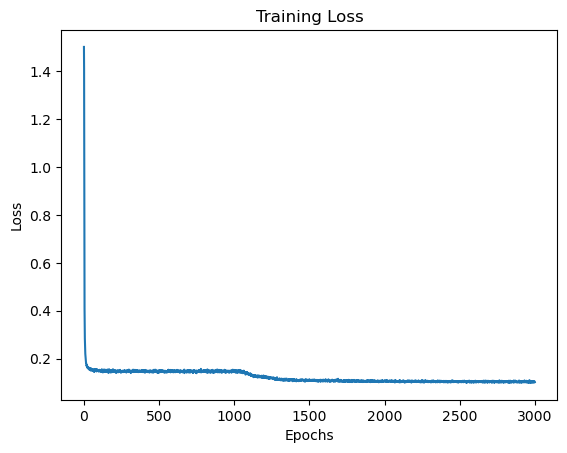

In [13]:
#One or more hidden layers
# Training the model
#One or more hidden layers
# Training the model
import time
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

# Initialize an empty list to store the loss values
losses = []

num_epochs = 3000
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()  # Start timing the epoch
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    
    epoch_loss = 0.0  # Initialize epoch loss to zero
    
    for inputs, targets in progress_bar:
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backward pass with scaled loss
        scaler.scale(loss).backward()

        # Optimizer step with scaler
        scaler.step(optimizer)
        scaler.update()

        # Clear optimizer gradients
        optimizer.zero_grad()

        epoch_loss += loss.item()  # Accumulate the loss for the epoch
        # Update the progress bar with the latest loss information
        progress_bar.set_postfix({'loss': loss.item()})
    
    losses.append(epoch_loss / len(train_loader))  # Calculate average epoch loss
    
    end_time = time.time()  # End timing the epoch
    epoch_duration = end_time - start_time  # Calculate the duration of the epoch
    
    # Print summary with duration
    print(f'Completed Epoch {epoch+1}, Loss: {losses[-1]:.4f}, Duration: {epoch_duration:.2f} seconds')

# Plot the loss values
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = StockRNN().to(device)  # Instantiate the model and move it to the appropriate device (GPU or CPU)
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 31855


In [15]:
import torch
import torch.nn as nn

# Define your model class
class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=4, hidden_size=50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, 5)  # Assuming 5 action classes
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x, _ = self.rnn(x)
        if x.dim() == 3:  # Proper 3D tensor (batch, sequence, features)
            x = x[:, -1, :]
        x = self.leaky_relu(x)
        x = self.fc(x)
        return x

# Initialize and load the model on the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StockRNN().to(device)

# Ensure the model is in evaluation mode before saving if no further training is planned
#model.eval()

# Save the entire model
torch.save(model, 'C:/Users/gunne/OneDrive/Desktop/bitcoin/trained/complete_model.pth')

# Print confirmation that the model has been saved
print("Model saved successfully!")


Model saved successfully!


In [21]:
#Output
# Testing the model
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
accuracy = total_correct / total_samples * 100
print(f'Accuracy on test data: {accuracy:.2f}%')
print("Sample outputs:", outputs[:5])
print("Sample predictions:", predicted[:5])
print("Sample targets:", targets[:5])


Accuracy on test data: 0.00%
Sample outputs: tensor([[-0.0319, -0.0289,  0.0812,  0.0382, -0.0716],
        [-0.0152, -0.0401,  0.1064,  0.0184, -0.0644],
        [-0.0070, -0.0476,  0.1142,  0.0110, -0.0622],
        [-0.0029, -0.0525,  0.1153,  0.0087, -0.0618],
        [-0.0007, -0.0556,  0.1142,  0.0081, -0.0618]], device='cuda:0')
Sample predictions: tensor([2, 2, 2, 2, 2], device='cuda:0')
Sample targets: tensor([-0.0928, -0.2469, -0.0346, -0.1303, -0.0911], device='cuda:0')


In [17]:
#making sure the model is not overfitting:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'features' and 'labels' are your full dataset loaded correctly
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# Further split train set into train and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    train_features, train_labels, test_size=0.1, random_state=42)

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")
print(f"Test Set: {len(test_dataset)} samples")


Training Set: 56451 samples
Validation Set: 6273 samples
Test Set: 15681 samples


In [18]:
import torch
from sklearn.metrics import f1_score

# Ensure the model is in evaluation mode
model.eval()

# Lists to collect all predictions and actual labels
all_predictions = []
all_targets = []

# Disable gradient computation for inference to save memory and computations
with torch.no_grad():
    for inputs, targets in test_loader:
        # Move inputs and targets to the GPU where the model is
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Compute the model output
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Move predictions and actuals back to CPU for F1 calculation (optional, if required for performance reasons)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calculate the F1 Score using the 'weighted' average to account for class imbalance
f1 = f1_score(all_targets, all_predictions, average='weighted')

print(f'F1 Score on test data: {f1:.4f}')

F1 Score on test data: 0.0000


In [19]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

X, y = datasets.load_iris(return_X_y=True)

clf = DecisionTreeClassifier(random_state=64)

k_folds = KFold(n_splits = 10)

scores = cross_val_score(clf, X, y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))


Cross Validation Scores:  [1.         1.         1.         0.93333333 0.93333333 0.8
 1.         0.86666667 0.93333333 1.        ]
Average CV Score:  0.9466666666666667
Number of CV Scores used in Average:  10


In [20]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import torch.nn as nn

# Define the model class
class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=4, hidden_size=50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, 5)  # Assuming 5 action classes
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x, _ = self.rnn(x)
        if x.dim() == 3:
            x = x[:, -1, :]
        x = self.leaky_relu(x)
        x = self.fc(x)
        return x

# Set the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load the model and ensure it's on the correct device
model_path = r"C:\Users\gunne\OneDrive\Desktop\bitcoin\trained\complete_model.pth"
model = torch.load(model_path).to(device)
model.eval()  # Set the model to evaluation mode

# Load your untrained dataset
data_path = r"C:\Users\gunne\OneDrive\Desktop\bitcoin\trained\walk_cleaned.csv"
data = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')
data.fillna(method='ffill', inplace=True)  # Forward fill to handle missing data

# Prepare data according to model's input requirements
features = data[['OPEN', 'HIGH', 'LOW', 'CLOSE']].values
targets = data['Change_Open_Close'].values  # Assuming this is what you predict

# Convert to PyTorch tensors and send them to the correct device
features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
targets_tensor = torch.tensor(targets, dtype=torch.float).to(device)

# Setup DataLoader
batch_size = 64
dataset = TensorDataset(features_tensor, targets_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(features_tensor):
    train_data, test_data = features_tensor[train_idx], features_tensor[test_idx]
    train_targets, test_targets = targets_tensor[train_idx], targets_tensor[test_idx]

    # DataLoaders for training and testing
    train_dataset = TensorDataset(train_data, train_targets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(test_data, test_targets)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate model performance on new data
    total_profit = 0.0
    for features, targets in test_loader:
        outputs = model(features)
        for i in range(len(outputs)):
            action_predicted = outputs[i].argmax().item()  # Assuming model outputs class probabilities
            actual_change = targets[i].item()
            if action_predicted == 0:  # Buy action
                if actual_change > 0:
                    total_profit += actual_change  # Profit if the price goes up after buying
            elif action_predicted == 1:  # Sell action
                if actual_change < 0:
                    total_profit -= actual_change  # Profit if the price goes down after selling

    print(f"Total Profit for this fold: {total_profit}")
    print("Model outputs:", outputs)
    print("Predicted actions:", outputs.argmax(dim=1))

    if total_profit >= 16.5:
        print("Target daily profit achieved.")
    else:
        print("Target not met.")


Using device: cuda
Total Profit for this fold: 0.0
Model outputs: tensor([[-0.0319, -0.0289,  0.0812,  0.0382, -0.0716],
        [-0.0152, -0.0400,  0.1063,  0.0184, -0.0643],
        [-0.0071, -0.0476,  0.1142,  0.0111, -0.0622],
        [-0.0029, -0.0525,  0.1154,  0.0087, -0.0618],
        [-0.0007, -0.0556,  0.1142,  0.0081, -0.0618],
        [ 0.0006, -0.0576,  0.1126,  0.0082, -0.0618],
        [ 0.0014, -0.0589,  0.1110,  0.0084, -0.0617],
        [ 0.0019, -0.0597,  0.1098,  0.0086, -0.0615],
        [ 0.0022, -0.0603,  0.1089,  0.0088, -0.0614],
        [ 0.0024, -0.0607,  0.1082,  0.0089, -0.0612],
        [ 0.0025, -0.0609,  0.1077,  0.0090, -0.0611],
        [ 0.0026, -0.0611,  0.1074,  0.0090, -0.0610],
        [ 0.0026, -0.0612,  0.1072,  0.0091, -0.0610],
        [ 0.0027, -0.0613,  0.1071,  0.0092, -0.0609],
        [ 0.0027, -0.0614,  0.1070,  0.0092, -0.0609],
        [ 0.0027, -0.0614,  0.1069,  0.0092, -0.0609],
        [ 0.0028, -0.0614,  0.1068,  0.0092, -0.0609],

In [ ]:
#walk forward validation for backtesting
#
"""
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assume data is loaded and preprocessed as discussed previously
# Initialize tracking variables outside the validation loop
trades_completed = 0
daily_profit = 0.0

# Define calculate_action function here or make sure it's available and appropriate
#This needs to be rid of 
def calculate_action(change, trades_completed, daily_profit):
    if trades_completed >= 33 or daily_profit >= 16.5:
        return 0  # Hold, since daily targets are achieved
    elif change <= -0.5:
        return 1  # Buy or cover
    elif change >= 0.5:
        return 2  # Sell or short
    else:
        return 0  # Hold

# Simulate updating these values based on each action taken
actions = []
for index, row in data.iterrows():
    action = calculate_action(row['Change_Open_Close'], trades_completed, daily_profit)
    actions.append(action)
    # Update trades_completed and daily_profit based on predefined logic
    trades_completed += 1 if action in [1, 2] else 0
    daily_profit += 0.5 if action in [1, 2] else 0  # Assuming each trade correctly achieves a 0.5% profit

data['Action'] = actions
features = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL', 'SPREAD', 'Change_Open_Close', 'Change_High_Low']].values
labels = data['Action'].values

# Convert to tensors and create the full dataset
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)
full_dataset = TensorDataset(features_tensor, labels_tensor)

# Parameters for walk-forward validation
n_splits = 10
split_size = len(full_dataset) // n_splits

# Walk-forward validation setup
model = StockRNN().to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

accuracies = []

for i in range(n_splits - 1):
    # Reset trade counters for each split to simulate a fresh start
    trades_completed = 0
    daily_profit = 0.0
    
    # Determine the training and test ranges
    train_start, train_end = 0, split_size * (i + 1)
    test_start, test_end = train_end, train_end + split_size

    # Create data subsets for the current split
    train_subset = TensorDataset(*full_dataset[train_start:train_end])
    test_subset = TensorDataset(*full_dataset[test_start:test_end])
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

    # Training phase
    for epoch in range(3):  # Adjust number of epochs per split as needed
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Testing phase
    model.eval()
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)
    
    accuracy = total_correct / total_samples * 100
    accuracies.append(accuracy)
    print(f"Validation for split {i+1}, Accuracy: {accuracy:.2f}%")

# Final Evaluation Results
#print("Walk-forward validation accuracies:", accuracies)
#print("Average Accuracy across splits:", np.mean(accuracies))
#
"""

In [ ]:
#BackTesting Scenarios with different datasets and get their predictions, if we get a daily profit of 16.5%/or a 30 day profit of 100k from 1k, we are golden. We wont jsut do bitcoin prices, but also other market validation history
import pandas as pd
import numpy as np
import torch

# Load historical data
data = pd.read_csv('C:/Users/gunne/OneDrive/Desktop/bitcoinh1_train.csv')

# Ensure the presence of a 'DATE' or 'TIMESTAMP' column
if 'DateTime' not in data.columns:
    data['DateTime'] = pd.to_datetime(data['TIMESTAMP']).dt.date  # Assuming TIMESTAMP exists

# Add a time column if it exists, for more detailed logs
if 'TIMESTAMP' in data.columns:
    data['TIME'] = pd.to_datetime(data['TIMESTAMP']).dt.time

# Compute necessary changes in terms of percentage
data['Change_Open_Close'] = ((data['CLOSE'] - data['OPEN']) / data['OPEN']) * 100

# Assuming your data has these features and they are all float-compatible
features = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL', 'SPREAD', 'Change_Open_Close']].values

# Convert to tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features_tensor = torch.tensor(features, dtype=torch.float32).to(device)

initial_capital = 1000
capital = initial_capital
positions = 0
entry_price = None
current_date = None
trades_completed_today = 0

model = torch.nn.Sequential(
    torch.nn.Linear(8, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 3)
)
model.to(device).eval()

with torch.no_grad():
    for i in range(len(features_tensor)):
        current_feature = features_tensor[i].unsqueeze(0)
        output = model(current_feature)
        current_price = data['CLOSE'].iloc[i]
        date = data['DateTime'].iloc[i]
        time = data['TIME'].iloc[i] if 'TIME' in data.columns else None
        change_percent = data['Change_Open_Close'].iloc[i]
        
        if current_date != date:
            current_date = date
            trades_completed_today = 0  # Reset daily trade count

        decision = torch.argmax(output).item()

        if trades_completed_today < 33:
            if capital > 0 and not positions:  # Checking buy conditions
                positions = capital / current_price
                capital = 0
                entry_price = current_price
                trades_completed_today += 1
                print(f"{date} {time} - Bought at ${current_price:.2f}, Entry Price ${entry_price:.2f}")

            if positions > 0:  # Checking sell conditions
                price_change_from_entry = (current_price / entry_price - 1) * 100
                if price_change_from_entry >= 0.5:
                    capital = positions * current_price
                    positions = 0
                    entry_price = None
                    trades_completed_today += 1
                    print(f"{date} {time} - Sold at ${current_price:.2f}, Gain: {price_change_from_entry:.2f}%, New Capital: ${capital:.2f}")

if positions > 0:
    capital = positions * data['CLOSE'].iloc[-1]
    print(f"Closing open position at ${data['CLOSE'].iloc[-1]:.2f}")

print(f"Final capital after trades on {current_date}: ${capital:.2f}")

In [ ]:
#make a blcok for the weights and biases 